In [18]:
# imports
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2 
import json

In [19]:
# function to extract subimages from parent images
def generate_subimages(filepath, output_filepath):

    # set id for non-unique text (e.g. multiple texts with value '1', don't want to overwrite)
    unique = 1

    # iterate through data directory
    for root, dirs, files in os.walk(filepath):
        for file in files:
            # locate test image
            if ('testimage' in file) and ('.jpeg' in file):
                # create filepath for image and corresponding image metadata
                filepath = os.path.join(root,file).replace('\\', '/')
                print('filepath:', filepath)
                file_split = file.split('.')
                json_filepath = os.path.join(root, file_split[0] + '.json').replace('\\', '/')
                print('json_filepath:', json_filepath)
                # load test image
                img = cv2.imread(filepath)
                # load corresponding test image metadata
                ocr = json.load(open(json_filepath,))

                # display image
                plt.imshow(img)
                plt.show()

                # obtain height and width of image
                hImg, wImg, _ = img.shape
                # isolate block metadata
                blocks = ocr['Blocks']
                # start count for iteration
                count = 1
                # iterate through blocks in metadata
                for block in blocks:
                    # isolate blocks of type 'LINE' that have a 75% confidence rating or higher
                    if block['BlockType'] == 'LINE' and float(block['Confidence']) >= 75:
                        # extract metadata from block
                        block_number = count
                        print('block_number:', block_number)
                        block_text = block['Text']
                        print('block_text:', block_text)
                        block_confidence = float(block['Confidence'])
                        print('block_confidence:', block_confidence)
                        block_width = float(block['Geometry']['BoundingBox']['Width'])
                        print('block_width:', block_width)
                        block_height = float(block['Geometry']['BoundingBox']['Height'])
                        print('block_height:', block_height)
                        block_left = float(block['Geometry']['BoundingBox']['Left'])
                        print('block_left:', block_left)
                        block_top = float(block['Geometry']['BoundingBox']['Top'])
                        print('block_top:', block_top)
                        block_polygon = block['Geometry']['Polygon']
                        print('block_polygon:', block_polygon)
                        block_polygon_x1 = float(block['Geometry']['Polygon'][0]['X'])
                        print('block_polygon_x1:', block_polygon_x1)
                        block_polygon_y1 = float(block['Geometry']['Polygon'][0]['Y'])
                        print('block_polygon_y1:', block_polygon_y1)
                        block_polygon_x2 = float(block['Geometry']['Polygon'][1]['X'])
                        print('block_polygon_x2:', block_polygon_x2)
                        block_polygon_y2 = float(block['Geometry']['Polygon'][1]['Y'])
                        print('block_polygon_y2:', block_polygon_y2)
                        block_polygon_x3 = float(block['Geometry']['Polygon'][2]['X'])
                        print('block_polygon_x3:', block_polygon_x3)
                        block_polygon_y3 = float(block['Geometry']['Polygon'][2]['Y'])
                        print('block_polygon_y3:', block_polygon_y3)
                        block_polygon_x4 = float(block['Geometry']['Polygon'][3]['X'])
                        print('block_polygon_x4:', block_polygon_x4)
                        block_polygon_y4 = float(block['Geometry']['Polygon'][3]['Y'])
                        print('block_polygon_y4:', block_polygon_y4)
                        # use polygon x,y coordinates to find boundaries of block's text
                        left_boundary = int(block_polygon_x1*wImg)
                        top_boundary = int(block_polygon_y1*hImg)
                        right_boundary = int(block_polygon_x3*wImg)
                        bottom_boundary = int(block_polygon_y3*hImg)
                        print('left_boundary:', left_boundary)
                        print('right_boundary:', right_boundary)
                        print('bottom_boundary:', top_boundary)
                        print('top_boundary:', bottom_boundary)
                        # crop subimage
                        crop_img = img[top_boundary:bottom_boundary, left_boundary:right_boundary]
                        # top/bottom and left/right boundaries are switched for some of the test images, so if an empty array
                        # is returned, script will switch boundaries and re-crop
                        if str(crop_img) == '[]':
                            crop_img = img[bottom_boundary:top_boundary, right_boundary:left_boundary]
                        plt.imshow(crop_img)
                        plt.show()
                        # save valid alphanumeric subimage with text as filename - to be parsed through in main function
                        # include alnums with spaces as well
                        # include alnums with '/' as well
                        if (block_text.isalnum()) or (block_text.replace(' ','').isalnum()) or (block_text.replace('/','').replace(' ','').isalnum()):
                            print(block_text, 'is valid.  adding image to subdata with corresponding name')
                            if '/' in block_text:
                                print(block_text, 'is a date with a "/" present')
                                block_text = block_text.replace('/','xxxx')
                                print('new text:', block_text)
                            cv2.imwrite('{}/{}___{}.png'.format(output_filepath, block_text, unique), crop_img)
                            # increment unique by 1 to differentiate between different images of the same text
                            unique += 1

                        count += 1
                        print('\n')
        
# function to extract subimage paths to a list
def extract_subimage_filepaths(filepath):
    # create list of all subimage filepaths
    subimg_filepaths = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if file.endswith('.png'):
                subimg_filepath = os.path.join(root,file).replace('\\', '/')
                subimg_filepaths.append(subimg_filepath)
    return subimg_filepaths

def text_parser(filepath, subimg_filepath_list):
    # create output dictionary
    dic = {}

    for root, dirs, files in os.walk(filepath):
        for file in files:
            if ('testimage' in file) and ('.jpeg' in file):
                print('analyzing image', file)
                # create entry for file in dictionary
                filename = file.rsplit('.')[0]
                dic[filename] = []
                # filepath for image
                img_filepath = os.path.join(root,file).replace('\\', '/')
                # load image
                img = cv2.imread(img_filepath)
                for subimg_filepath in subimg_filepath_list:
                    print('subimg_filepath:', subimg_filepath)
                    subimg_text = subimg_filepath.rsplit('/')[-1].rsplit('___')[0]
                    # convert 'xxxx' in date strings back to '/'
                    if 'xxxx' in subimg_text:
                        subimg_text = subimg_text.replace('xxxx', '/')
                    print('subimg_text:', subimg_text)
                    subimg = cv2.imread(subimg_filepath)
                    # use cv2's matchTemplate function to check for presence of subimage within image
                    result = cv2.matchTemplate(img,subimg,cv2.TM_CCOEFF_NORMED)
                    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
                    # maxVal serves as confidence interval
                    # if confidence is greater than or equal to 90%, include in output
                    if maxVal >= 0.90:
                        # get x,y coordinates of highlest confidence match
                        (startX, startY) = maxLoc
                        # get x,y coordinates of subimage endpoint
                        endX = startX + subimg.shape[1]
                        endY = startY + subimg.shape[0]
                        # draw the bounding box on the image
                        cv2.rectangle(img, (startX, startY), (endX, endY), (255, 0, 0), 1)
                        # create tuple containing text and coordinates of subimg
                        subimg_tuple = (subimg_text, (startX, startY), (endX,endY))
                        dic[filename].append(subimg_tuple)

                    cv2.imwrite('{}{}_updated.jpeg'.format(filepath,file), img)
    return dic

# function to sort the list of tuples by its second item
def sort_list_by_y_value(list_of_tuples): 
      
    # getting length of list of tuples
    lst = len(list_of_tuples) 
    for i in range(0, lst): 
        # iterate through list and sort values by y value of second tuple
        for j in range(0, lst-i-1): 
            if (list_of_tuples[j][2][1] > list_of_tuples[j + 1][2][1]): 
                temp = list_of_tuples[j] 
                list_of_tuples[j]= list_of_tuples[j + 1] 
                list_of_tuples[j + 1]= temp 
    return list_of_tuples

# function to put tuples in correct row list based on Y value
def create_rows_from_y_values(lst):
    # generate blank list of lists
    list_of_lists = []
    # generate blank row list
    row_list = []
    # iterate through list of text and corresponding coordinate tuples
    for i in range(len(lst)):
        item = lst[i]
        print('item:', item)
        # identify endY value
        endY_item = item[2][1]
        print('endY_item:', endY_item)
        # identify next tuple
        try:
            next_item = lst[i+1]
        except:
            next_item = ['',('',''),('','')]
        print('next_item:', next_item)
        # identify y value of next tuple
        endY_next_item = next_item[2][1]
        print('endY_next_item:', endY_next_item)
        
        # display absolute difference between y coordinates
        if type(endY_next_item) == int:
            print('absolute_difference_between_endY_values:', abs(endY_item - endY_next_item))
        # logic for concurrent y coordinates (difference between y values is less than 2)
        if (type(endY_next_item) != str) and abs(endY_item - endY_next_item) < 2:
            print('concurrent row found')
            # add item to list
            row_list.append(item)
            # add next item to list
            row_list.append(next_item)
            print('row_list:', row_list)
        # logic for nonconcurrent y coordinates (difference between y values is greater than or equal to 2)
        else:
            print('nonconcurrent row found. creating new row')
            # add item to list
            row_list.append(item)
            # remove duplicates from list
            row_list = list(set(row_list))
            # add row to list of lists
            list_of_lists.append(row_list)
            # reset row list
            row_list = []


        print('\n')
    return list_of_lists

# function to sort lists in list of lists by x value
def sort_lists_by_x_value(lst_of_lsts):
    for i in range(len(lst_of_lsts)):
        # isolate individual row
        ind_lst = lst_of_lsts[i]
        # iterate through list and sort values by x value of first tuple
        for j in range(len(ind_lst)):
            lst_tuple = ind_lst[j]
            print(lst_tuple)
            for k in range(0, len(ind_lst)-j-1):
                if (ind_lst[k][1][0] > ind_lst[k + 1][1][0]):
                        temp = ind_lst[k]
                        ind_lst[k]= ind_lst[k + 1]
                        ind_lst[k + 1]= temp
            lst_of_lsts[i] = ind_lst
        print('\n')
        
    return lst_of_lsts

# function to limit lists of lists to text only
def extract_text_from_tuples(lst_of_lsts):
    # iterate through lists
    for i in range(len(lst_of_lsts)):
        # isolate individual list
        lst = lst_of_lsts[i]
        # replace (text, begin_coords, end_coords) with text only
        for j in range(len(lst)):
            lst_item  = lst[j]
            lst_item = lst_item[0]
            lst_of_lsts[i][j] = lst_item

    return lst_of_lsts

# function combining other functions and generating final output
def format_dictionary(dictionary):
    for k,v in dictionary.items():
        # isolate individual dictionary values (individual test image)
        lst = dictionary[k]
        # sort entire list by y value
        lst = sort_list_by_y_value(lst)
        # separate list into rows
        lst = create_rows_from_y_values(lst)
        # sort individual rows by x value
        lst_of_lsts = sort_lists_by_x_value(lst)
        # convert (text, begin_coords, end_coords) to text only
        lst_of_lsts = extract_text_from_tuples(lst_of_lsts)
        # replace dictionary value with ordered text list
        dictionary[k] = lst_of_lsts


    return dictionary

filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage1.jpeg
json_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage1.json


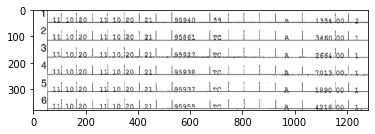

block_number: 1
block_text: 1
block_confidence: 85.57362365722656
block_width: 0.009786272421479225
block_height: 0.07181749492883682
block_left: 0.024548688903450966
block_top: 0.0
block_polygon: [{'X': 0.024548688903450966, 'Y': 0}, {'X': 0.03433496132493019, 'Y': 0}, {'X': 0.03433496132493019, 'Y': 0.07181749492883682}, {'X': 0.024548688903450966, 'Y': 0.07181749492883682}]
block_polygon_x1: 0.024548688903450966
block_polygon_y1: 0.0
block_polygon_x2: 0.03433496132493019
block_polygon_y2: 0.0
block_polygon_x3: 0.03433496132493019
block_polygon_y3: 0.07181749492883682
block_polygon_x4: 0.024548688903450966
block_polygon_y4: 0.07181749492883682
left_boundary: 31
right_boundary: 43
bottom_boundary: 0
top_boundary: 27


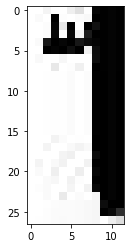

1 is valid.  adding image to subdata with corresponding name


block_number: 2
block_text: 11/10/20
block_confidence: 97.8393325805664
block_width: 0.10000991821289062
block_height: 0.1087951585650444
block_left: 0.05893949791789055
block_top: 0.022371428087353706
block_polygon: [{'X': 0.05893949791789055, 'Y': 0.022371428087353706}, {'X': 0.15894941985607147, 'Y': 0.022371428087353706}, {'X': 0.15894941985607147, 'Y': 0.13116659224033356}, {'X': 0.05893949791789055, 'Y': 0.13116659224033356}]
block_polygon_x1: 0.05893949791789055
block_polygon_y1: 0.022371428087353706
block_polygon_x2: 0.15894941985607147
block_polygon_y2: 0.022371428087353706
block_polygon_x3: 0.15894941985607147
block_polygon_y3: 0.13116659224033356
block_polygon_x4: 0.05893949791789055
block_polygon_y4: 0.13116659224033356
left_boundary: 75
right_boundary: 203
bottom_boundary: 8
top_boundary: 49


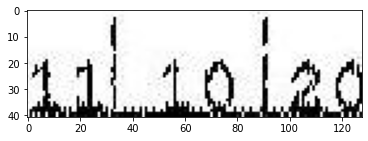

11/10/20 is valid.  adding image to subdata with corresponding name
11/10/20 is a date with a "/" present
new text: 11xxxx10xxxx20


block_number: 3
block_text: 11
block_confidence: 75.60562133789062
block_width: 0.022916823625564575
block_height: 0.058438971638679504
block_left: 0.19872471690177917
block_top: 0.06883066147565842
block_polygon: [{'X': 0.19872471690177917, 'Y': 0.06883066147565842}, {'X': 0.22164154052734375, 'Y': 0.06883066147565842}, {'X': 0.22164154052734375, 'Y': 0.12726964056491852}, {'X': 0.19872471690177917, 'Y': 0.12726964056491852}]
block_polygon_x1: 0.19872471690177917
block_polygon_y1: 0.06883066147565842
block_polygon_x2: 0.22164154052734375
block_polygon_y2: 0.06883066147565842
block_polygon_x3: 0.22164154052734375
block_polygon_y3: 0.12726964056491852
block_polygon_x4: 0.19872471690177917
block_polygon_y4: 0.12726964056491852
left_boundary: 254
right_boundary: 283
bottom_boundary: 26
top_boundary: 48


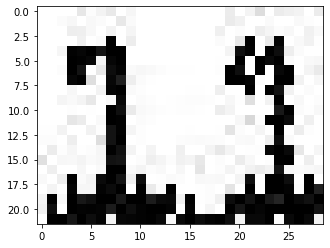

11 is valid.  adding image to subdata with corresponding name


block_number: 4
block_text: 10
block_confidence: 99.2193374633789
block_width: 0.023725852370262146
block_height: 0.06098395586013794
block_left: 0.23803015053272247
block_top: 0.06716204434633255
block_polygon: [{'X': 0.23803015053272247, 'Y': 0.06716204434633255}, {'X': 0.2617560029029846, 'Y': 0.06716204434633255}, {'X': 0.2617560029029846, 'Y': 0.1281459927558899}, {'X': 0.23803015053272247, 'Y': 0.1281459927558899}]
block_polygon_x1: 0.23803015053272247
block_polygon_y1: 0.06716204434633255
block_polygon_x2: 0.2617560029029846
block_polygon_y2: 0.06716204434633255
block_polygon_x3: 0.2617560029029846
block_polygon_y3: 0.1281459927558899
block_polygon_x4: 0.23803015053272247
block_polygon_y4: 0.1281459927558899
left_boundary: 304
right_boundary: 335
bottom_boundary: 25
top_boundary: 48


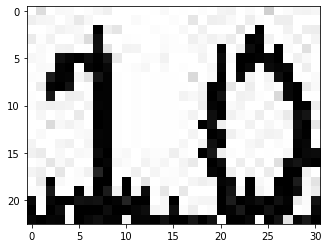

10 is valid.  adding image to subdata with corresponding name


block_number: 5
block_text: 20
block_confidence: 99.35765075683594
block_width: 0.02511751651763916
block_height: 0.06238541752099991
block_left: 0.27590423822402954
block_top: 0.06769810616970062
block_polygon: [{'X': 0.27590423822402954, 'Y': 0.06769810616970062}, {'X': 0.3010217547416687, 'Y': 0.06769810616970062}, {'X': 0.3010217547416687, 'Y': 0.13008353114128113}, {'X': 0.27590423822402954, 'Y': 0.13008353114128113}]
block_polygon_x1: 0.27590423822402954
block_polygon_y1: 0.06769810616970062
block_polygon_x2: 0.3010217547416687
block_polygon_y2: 0.06769810616970062
block_polygon_x3: 0.3010217547416687
block_polygon_y3: 0.13008353114128113
block_polygon_x4: 0.27590423822402954
block_polygon_y4: 0.13008353114128113
left_boundary: 353
right_boundary: 385
bottom_boundary: 25
top_boundary: 49


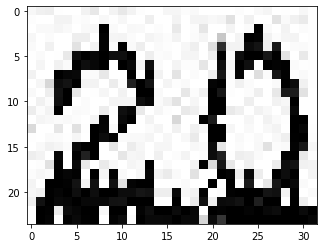

20 is valid.  adding image to subdata with corresponding name


block_number: 6
block_text: 2
block_confidence: 99.26250457763672
block_width: 0.017437350004911423
block_height: 0.08171667158603668
block_left: 0.02280484512448311
block_top: 0.16353411972522736
block_polygon: [{'X': 0.02280484512448311, 'Y': 0.16353411972522736}, {'X': 0.04024219512939453, 'Y': 0.16353411972522736}, {'X': 0.04024219512939453, 'Y': 0.24525079131126404}, {'X': 0.02280484512448311, 'Y': 0.24525079131126404}]
block_polygon_x1: 0.02280484512448311
block_polygon_y1: 0.16353411972522736
block_polygon_x2: 0.04024219512939453
block_polygon_y2: 0.16353411972522736
block_polygon_x3: 0.04024219512939453
block_polygon_y3: 0.24525079131126404
block_polygon_x4: 0.02280484512448311
block_polygon_y4: 0.24525079131126404
left_boundary: 29
right_boundary: 51
bottom_boundary: 62
top_boundary: 93


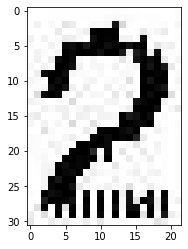

2 is valid.  adding image to subdata with corresponding name


block_number: 7
block_text: 11/10/20
block_confidence: 90.4999771118164
block_width: 0.09803685545921326
block_height: 0.10648660361766815
block_left: 0.06142878532409668
block_top: 0.19585904479026794
block_polygon: [{'X': 0.06142878532409668, 'Y': 0.19585904479026794}, {'X': 0.15946564078330994, 'Y': 0.19585904479026794}, {'X': 0.15946564078330994, 'Y': 0.3023456335067749}, {'X': 0.06142878532409668, 'Y': 0.3023456335067749}]
block_polygon_x1: 0.06142878532409668
block_polygon_y1: 0.19585904479026794
block_polygon_x2: 0.15946564078330994
block_polygon_y2: 0.19585904479026794
block_polygon_x3: 0.15946564078330994
block_polygon_y3: 0.3023456335067749
block_polygon_x4: 0.06142878532409668
block_polygon_y4: 0.3023456335067749
left_boundary: 78
right_boundary: 204
bottom_boundary: 74
top_boundary: 115


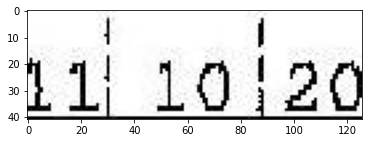

11/10/20 is valid.  adding image to subdata with corresponding name
11/10/20 is a date with a "/" present
new text: 11xxxx10xxxx20


block_number: 8
block_text: 11
block_confidence: 98.5534896850586
block_width: 0.02380390465259552
block_height: 0.06282155215740204
block_left: 0.1993495225906372
block_top: 0.23716185986995697
block_polygon: [{'X': 0.1993495225906372, 'Y': 0.23716185986995697}, {'X': 0.22315342724323273, 'Y': 0.23716185986995697}, {'X': 0.22315342724323273, 'Y': 0.299983412027359}, {'X': 0.1993495225906372, 'Y': 0.299983412027359}]
block_polygon_x1: 0.1993495225906372
block_polygon_y1: 0.23716185986995697
block_polygon_x2: 0.22315342724323273
block_polygon_y2: 0.23716185986995697
block_polygon_x3: 0.22315342724323273
block_polygon_y3: 0.299983412027359
block_polygon_x4: 0.1993495225906372
block_polygon_y4: 0.299983412027359
left_boundary: 255
right_boundary: 285
bottom_boundary: 90
top_boundary: 114


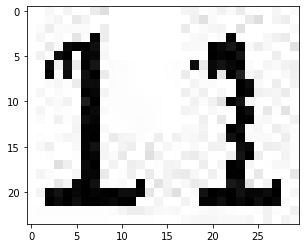

11 is valid.  adding image to subdata with corresponding name


block_number: 9
block_text: 10
block_confidence: 94.72238159179688
block_width: 0.024087712168693542
block_height: 0.0630335807800293
block_left: 0.23756714165210724
block_top: 0.23972740769386292
block_polygon: [{'X': 0.23756714165210724, 'Y': 0.23972740769386292}, {'X': 0.2616548538208008, 'Y': 0.23972740769386292}, {'X': 0.2616548538208008, 'Y': 0.3027609884738922}, {'X': 0.23756714165210724, 'Y': 0.3027609884738922}]
block_polygon_x1: 0.23756714165210724
block_polygon_y1: 0.23972740769386292
block_polygon_x2: 0.2616548538208008
block_polygon_y2: 0.23972740769386292
block_polygon_x3: 0.2616548538208008
block_polygon_y3: 0.3027609884738922
block_polygon_x4: 0.23756714165210724
block_polygon_y4: 0.3027609884738922
left_boundary: 304
right_boundary: 334
bottom_boundary: 91
top_boundary: 115


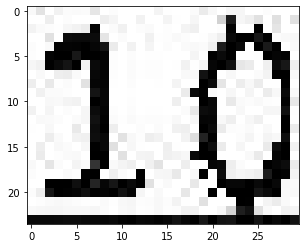

10 is valid.  adding image to subdata with corresponding name


block_number: 10
block_text: 20
block_confidence: 95.3401107788086
block_width: 0.02525705099105835
block_height: 0.06437550485134125
block_left: 0.27557170391082764
block_top: 0.2392122894525528
block_polygon: [{'X': 0.27557170391082764, 'Y': 0.2392122894525528}, {'X': 0.300828754901886, 'Y': 0.2392122894525528}, {'X': 0.300828754901886, 'Y': 0.30358779430389404}, {'X': 0.27557170391082764, 'Y': 0.30358779430389404}]
block_polygon_x1: 0.27557170391082764
block_polygon_y1: 0.2392122894525528
block_polygon_x2: 0.300828754901886
block_polygon_y2: 0.2392122894525528
block_polygon_x3: 0.300828754901886
block_polygon_y3: 0.30358779430389404
block_polygon_x4: 0.27557170391082764
block_polygon_y4: 0.30358779430389404
left_boundary: 352
right_boundary: 385
bottom_boundary: 91
top_boundary: 115


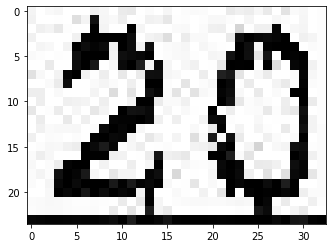

20 is valid.  adding image to subdata with corresponding name


block_number: 11
block_text: 21
block_confidence: 97.8143539428711
block_width: 0.024265199899673462
block_height: 0.06555919349193573
block_left: 0.33273041248321533
block_top: 0.23936156928539276
block_polygon: [{'X': 0.33273041248321533, 'Y': 0.23936156928539276}, {'X': 0.3569956123828888, 'Y': 0.23936156928539276}, {'X': 0.3569956123828888, 'Y': 0.3049207627773285}, {'X': 0.33273041248321533, 'Y': 0.3049207627773285}]
block_polygon_x1: 0.33273041248321533
block_polygon_y1: 0.23936156928539276
block_polygon_x2: 0.3569956123828888
block_polygon_y2: 0.23936156928539276
block_polygon_x3: 0.3569956123828888
block_polygon_y3: 0.3049207627773285
block_polygon_x4: 0.33273041248321533
block_polygon_y4: 0.3049207627773285
left_boundary: 425
right_boundary: 456
bottom_boundary: 91
top_boundary: 116


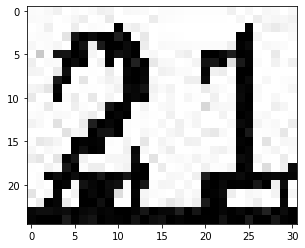

21 is valid.  adding image to subdata with corresponding name


block_number: 12
block_text: 95861
block_confidence: 84.71825408935547
block_width: 0.0626610815525055
block_height: 0.06367005407810211
block_left: 0.42152905464172363
block_top: 0.24099066853523254
block_polygon: [{'X': 0.42152905464172363, 'Y': 0.24099066853523254}, {'X': 0.4841901361942291, 'Y': 0.24099066853523254}, {'X': 0.4841901361942291, 'Y': 0.30466070771217346}, {'X': 0.42152905464172363, 'Y': 0.30466070771217346}]
block_polygon_x1: 0.42152905464172363
block_polygon_y1: 0.24099066853523254
block_polygon_x2: 0.4841901361942291
block_polygon_y2: 0.24099066853523254
block_polygon_x3: 0.4841901361942291
block_polygon_y3: 0.30466070771217346
block_polygon_x4: 0.42152905464172363
block_polygon_y4: 0.30466070771217346
left_boundary: 539
right_boundary: 619
bottom_boundary: 91
top_boundary: 116


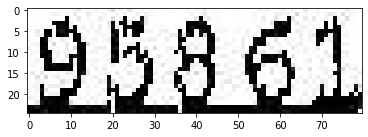

95861 is valid.  adding image to subdata with corresponding name


block_number: 13
block_text: IC
block_confidence: 95.908203125
block_width: 0.026208102703094482
block_height: 0.057596355676651
block_left: 0.5370414853096008
block_top: 0.24678801000118256
block_polygon: [{'X': 0.5370414853096008, 'Y': 0.24678801000118256}, {'X': 0.5632495880126953, 'Y': 0.24678801000118256}, {'X': 0.5632495880126953, 'Y': 0.30438435077667236}, {'X': 0.5370414853096008, 'Y': 0.30438435077667236}]
block_polygon_x1: 0.5370414853096008
block_polygon_y1: 0.24678801000118256
block_polygon_x2: 0.5632495880126953
block_polygon_y2: 0.24678801000118256
block_polygon_x3: 0.5632495880126953
block_polygon_y3: 0.30438435077667236
block_polygon_x4: 0.5370414853096008
block_polygon_y4: 0.30438435077667236
left_boundary: 687
right_boundary: 720
bottom_boundary: 94
top_boundary: 115


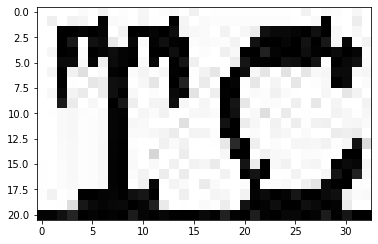

IC is valid.  adding image to subdata with corresponding name


block_number: 14
block_text: A
block_confidence: 99.35325622558594
block_width: 0.013669788837432861
block_height: 0.05022469162940979
block_left: 0.7506455183029175
block_top: 0.2525308132171631
block_polygon: [{'X': 0.7506455183029175, 'Y': 0.2525308132171631}, {'X': 0.7643153071403503, 'Y': 0.2525308132171631}, {'X': 0.7643153071403503, 'Y': 0.3027555048465729}, {'X': 0.7506455183029175, 'Y': 0.3027555048465729}]
block_polygon_x1: 0.7506455183029175
block_polygon_y1: 0.2525308132171631
block_polygon_x2: 0.7643153071403503
block_polygon_y2: 0.2525308132171631
block_polygon_x3: 0.7643153071403503
block_polygon_y3: 0.3027555048465729
block_polygon_x4: 0.7506455183029175
block_polygon_y4: 0.3027555048465729
left_boundary: 960
right_boundary: 978
bottom_boundary: 96
top_boundary: 115


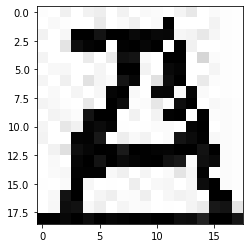

A is valid.  adding image to subdata with corresponding name


block_number: 15
block_text: 3460 too
block_confidence: 87.82278442382812
block_width: 0.0861373096704483
block_height: 0.08392934501171112
block_left: 0.842532753944397
block_top: 0.22555580735206604
block_polygon: [{'X': 0.842532753944397, 'Y': 0.22555580735206604}, {'X': 0.9286700487136841, 'Y': 0.22555580735206604}, {'X': 0.9286700487136841, 'Y': 0.30948513746261597}, {'X': 0.842532753944397, 'Y': 0.30948513746261597}]
block_polygon_x1: 0.842532753944397
block_polygon_y1: 0.22555580735206604
block_polygon_x2: 0.9286700487136841
block_polygon_y2: 0.22555580735206604
block_polygon_x3: 0.9286700487136841
block_polygon_y3: 0.30948513746261597
block_polygon_x4: 0.842532753944397
block_polygon_y4: 0.30948513746261597
left_boundary: 1078
right_boundary: 1188
bottom_boundary: 85
top_boundary: 117


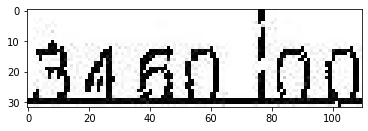

3460 too is valid.  adding image to subdata with corresponding name


block_number: 16
block_text: 7
block_confidence: 99.08140563964844
block_width: 0.006991207599639893
block_height: 0.056201159954071045
block_left: 0.9622787237167358
block_top: 0.24968720972537994
block_polygon: [{'X': 0.9622787237167358, 'Y': 0.24968720972537994}, {'X': 0.9692699313163757, 'Y': 0.24968720972537994}, {'X': 0.9692699313163757, 'Y': 0.3058883547782898}, {'X': 0.9622787237167358, 'Y': 0.3058883547782898}]
block_polygon_x1: 0.9622787237167358
block_polygon_y1: 0.24968720972537994
block_polygon_x2: 0.9692699313163757
block_polygon_y2: 0.24968720972537994
block_polygon_x3: 0.9692699313163757
block_polygon_y3: 0.3058883547782898
block_polygon_x4: 0.9622787237167358
block_polygon_y4: 0.3058883547782898
left_boundary: 1231
right_boundary: 1240
bottom_boundary: 95
top_boundary: 116


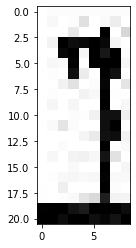

7 is valid.  adding image to subdata with corresponding name


block_number: 17
block_text: 3
block_confidence: 99.75055694580078
block_width: 0.016683537513017654
block_height: 0.08468940854072571
block_left: 0.02333102747797966
block_top: 0.3354865312576294
block_polygon: [{'X': 0.02333102747797966, 'Y': 0.3354865312576294}, {'X': 0.040014564990997314, 'Y': 0.3354865312576294}, {'X': 0.040014564990997314, 'Y': 0.4201759397983551}, {'X': 0.02333102747797966, 'Y': 0.4201759397983551}]
block_polygon_x1: 0.02333102747797966
block_polygon_y1: 0.3354865312576294
block_polygon_x2: 0.040014564990997314
block_polygon_y2: 0.3354865312576294
block_polygon_x3: 0.040014564990997314
block_polygon_y3: 0.4201759397983551
block_polygon_x4: 0.02333102747797966
block_polygon_y4: 0.4201759397983551
left_boundary: 29
right_boundary: 51
bottom_boundary: 127
top_boundary: 160


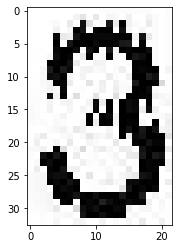

3 is valid.  adding image to subdata with corresponding name


block_number: 18
block_text: 1
block_confidence: 90.43460845947266
block_width: 0.008316561579704285
block_height: 0.05419224500656128
block_left: 0.2382691651582718
block_top: 0.41549137234687805
block_polygon: [{'X': 0.2382691651582718, 'Y': 0.41549137234687805}, {'X': 0.24658572673797607, 'Y': 0.41549137234687805}, {'X': 0.24658572673797607, 'Y': 0.46968361735343933}, {'X': 0.2382691651582718, 'Y': 0.46968361735343933}]
block_polygon_x1: 0.2382691651582718
block_polygon_y1: 0.41549137234687805
block_polygon_x2: 0.24658572673797607
block_polygon_y2: 0.41549137234687805
block_polygon_x3: 0.24658572673797607
block_polygon_y3: 0.46968361735343933
block_polygon_x4: 0.2382691651582718
block_polygon_y4: 0.46968361735343933
left_boundary: 304
right_boundary: 315
bottom_boundary: 158
top_boundary: 178


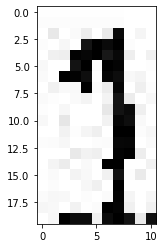

1 is valid.  adding image to subdata with corresponding name


block_number: 19
block_text: 0
block_confidence: 80.66831970214844
block_width: 0.011888831853866577
block_height: 0.055408477783203125
block_left: 0.25024881958961487
block_top: 0.41725999116897583
block_polygon: [{'X': 0.25024881958961487, 'Y': 0.41725999116897583}, {'X': 0.26213765144348145, 'Y': 0.41725999116897583}, {'X': 0.26213765144348145, 'Y': 0.47266846895217896}, {'X': 0.25024881958961487, 'Y': 0.47266846895217896}]
block_polygon_x1: 0.25024881958961487
block_polygon_y1: 0.41725999116897583
block_polygon_x2: 0.26213765144348145
block_polygon_y2: 0.41725999116897583
block_polygon_x3: 0.26213765144348145
block_polygon_y3: 0.47266846895217896
block_polygon_x4: 0.25024881958961487
block_polygon_y4: 0.47266846895217896
left_boundary: 320
right_boundary: 335
bottom_boundary: 158
top_boundary: 180


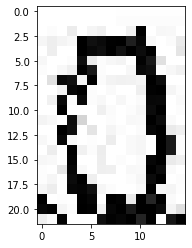

0 is valid.  adding image to subdata with corresponding name


block_number: 20
block_text: 20
block_confidence: 98.05633544921875
block_width: 0.02581039071083069
block_height: 0.06185632944107056
block_left: 0.2751956582069397
block_top: 0.4147958755493164
block_polygon: [{'X': 0.2751956582069397, 'Y': 0.4147958755493164}, {'X': 0.3010060489177704, 'Y': 0.4147958755493164}, {'X': 0.3010060489177704, 'Y': 0.47665220499038696}, {'X': 0.2751956582069397, 'Y': 0.47665220499038696}]
block_polygon_x1: 0.2751956582069397
block_polygon_y1: 0.4147958755493164
block_polygon_x2: 0.3010060489177704
block_polygon_y2: 0.4147958755493164
block_polygon_x3: 0.3010060489177704
block_polygon_y3: 0.47665220499038696
block_polygon_x4: 0.2751956582069397
block_polygon_y4: 0.47665220499038696
left_boundary: 352
right_boundary: 385
bottom_boundary: 158
top_boundary: 181


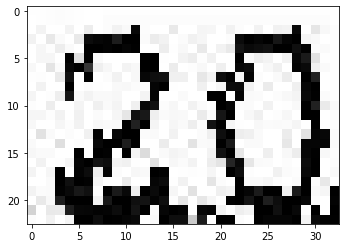

20 is valid.  adding image to subdata with corresponding name


block_number: 21
block_text: TC
block_confidence: 79.50303649902344
block_width: 0.02674645185470581
block_height: 0.055964112281799316
block_left: 0.5361343026161194
block_top: 0.41894102096557617
block_polygon: [{'X': 0.5361343026161194, 'Y': 0.41894102096557617}, {'X': 0.5628807544708252, 'Y': 0.41894102096557617}, {'X': 0.5628807544708252, 'Y': 0.4749051332473755}, {'X': 0.5361343026161194, 'Y': 0.4749051332473755}]
block_polygon_x1: 0.5361343026161194
block_polygon_y1: 0.41894102096557617
block_polygon_x2: 0.5628807544708252
block_polygon_y2: 0.41894102096557617
block_polygon_x3: 0.5628807544708252
block_polygon_y3: 0.4749051332473755
block_polygon_x4: 0.5361343026161194
block_polygon_y4: 0.4749051332473755
left_boundary: 686
right_boundary: 720
bottom_boundary: 159
top_boundary: 180


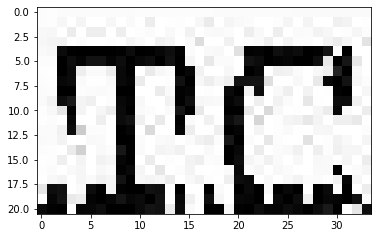

TC is valid.  adding image to subdata with corresponding name


block_number: 22
block_text: A
block_confidence: 82.60885620117188
block_width: 0.011837780475616455
block_height: 0.046303004026412964
block_left: 0.7507290244102478
block_top: 0.4297061562538147
block_polygon: [{'X': 0.7507290244102478, 'Y': 0.4297061562538147}, {'X': 0.7625668048858643, 'Y': 0.4297061562538147}, {'X': 0.7625668048858643, 'Y': 0.47600916028022766}, {'X': 0.7507290244102478, 'Y': 0.47600916028022766}]
block_polygon_x1: 0.7507290244102478
block_polygon_y1: 0.4297061562538147
block_polygon_x2: 0.7625668048858643
block_polygon_y2: 0.4297061562538147
block_polygon_x3: 0.7625668048858643
block_polygon_y3: 0.47600916028022766
block_polygon_x4: 0.7507290244102478
block_polygon_y4: 0.47600916028022766
left_boundary: 960
right_boundary: 976
bottom_boundary: 163
top_boundary: 181


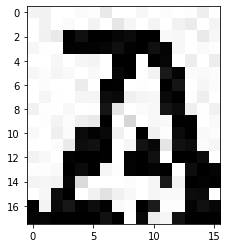

A is valid.  adding image to subdata with corresponding name


block_number: 23
block_text: 1
block_confidence: 98.9958724975586
block_width: 0.009292006492614746
block_height: 0.06151285767555237
block_left: 0.9612463712692261
block_top: 0.42664557695388794
block_polygon: [{'X': 0.9612463712692261, 'Y': 0.42664557695388794}, {'X': 0.9705383777618408, 'Y': 0.42664557695388794}, {'X': 0.9705383777618408, 'Y': 0.4881584346294403}, {'X': 0.9612463712692261, 'Y': 0.4881584346294403}]
block_polygon_x1: 0.9612463712692261
block_polygon_y1: 0.42664557695388794
block_polygon_x2: 0.9705383777618408
block_polygon_y2: 0.42664557695388794
block_polygon_x3: 0.9705383777618408
block_polygon_y3: 0.4881584346294403
block_polygon_x4: 0.9612463712692261
block_polygon_y4: 0.4881584346294403
left_boundary: 1230
right_boundary: 1242
bottom_boundary: 162
top_boundary: 185


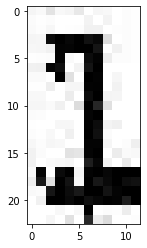

1 is valid.  adding image to subdata with corresponding name


block_number: 24
block_text: 4
block_confidence: 99.12641143798828
block_width: 0.017288733273744583
block_height: 0.08398091793060303
block_left: 0.023472752422094345
block_top: 0.5092818737030029
block_polygon: [{'X': 0.023472752422094345, 'Y': 0.5092818737030029}, {'X': 0.04076148569583893, 'Y': 0.5092818737030029}, {'X': 0.04076148569583893, 'Y': 0.593262791633606}, {'X': 0.023472752422094345, 'Y': 0.593262791633606}]
block_polygon_x1: 0.023472752422094345
block_polygon_y1: 0.5092818737030029
block_polygon_x2: 0.04076148569583893
block_polygon_y2: 0.5092818737030029
block_polygon_x3: 0.04076148569583893
block_polygon_y3: 0.593262791633606
block_polygon_x4: 0.023472752422094345
block_polygon_y4: 0.593262791633606
left_boundary: 30
right_boundary: 52
bottom_boundary: 194
top_boundary: 226


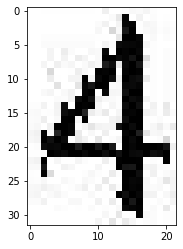

4 is valid.  adding image to subdata with corresponding name


block_number: 25
block_text: 11/10/20
block_confidence: 98.77052307128906
block_width: 0.10055862367153168
block_height: 0.10821890830993652
block_left: 0.059687625616788864
block_top: 0.5440912842750549
block_polygon: [{'X': 0.059687625616788864, 'Y': 0.5440912842750549}, {'X': 0.16024625301361084, 'Y': 0.5440912842750549}, {'X': 0.16024625301361084, 'Y': 0.6523101925849915}, {'X': 0.059687625616788864, 'Y': 0.6523101925849915}]
block_polygon_x1: 0.059687625616788864
block_polygon_y1: 0.5440912842750549
block_polygon_x2: 0.16024625301361084
block_polygon_y2: 0.5440912842750549
block_polygon_x3: 0.16024625301361084
block_polygon_y3: 0.6523101925849915
block_polygon_x4: 0.059687625616788864
block_polygon_y4: 0.6523101925849915
left_boundary: 76
right_boundary: 205
bottom_boundary: 207
top_boundary: 248


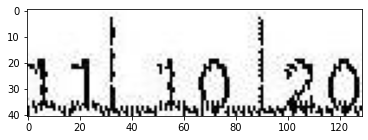

11/10/20 is valid.  adding image to subdata with corresponding name
11/10/20 is a date with a "/" present
new text: 11xxxx10xxxx20


block_number: 26
block_text: 11
block_confidence: 91.8036117553711
block_width: 0.02348378300666809
block_height: 0.07300102710723877
block_left: 0.1995393931865692
block_top: 0.5790899395942688
block_polygon: [{'X': 0.1995393931865692, 'Y': 0.5790899395942688}, {'X': 0.2230231761932373, 'Y': 0.5790899395942688}, {'X': 0.2230231761932373, 'Y': 0.6520909667015076}, {'X': 0.1995393931865692, 'Y': 0.6520909667015076}]
block_polygon_x1: 0.1995393931865692
block_polygon_y1: 0.5790899395942688
block_polygon_x2: 0.2230231761932373
block_polygon_y2: 0.5790899395942688
block_polygon_x3: 0.2230231761932373
block_polygon_y3: 0.6520909667015076
block_polygon_x4: 0.1995393931865692
block_polygon_y4: 0.6520909667015076
left_boundary: 255
right_boundary: 285
bottom_boundary: 220
top_boundary: 248


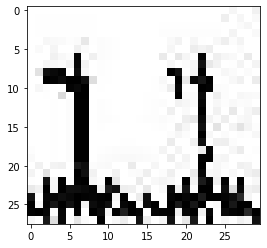

11 is valid.  adding image to subdata with corresponding name


block_number: 27
block_text: 10
block_confidence: 99.29203796386719
block_width: 0.023797273635864258
block_height: 0.05934232473373413
block_left: 0.23761585354804993
block_top: 0.5886092185974121
block_polygon: [{'X': 0.23761585354804993, 'Y': 0.5886092185974121}, {'X': 0.2614131271839142, 'Y': 0.5886092185974121}, {'X': 0.2614131271839142, 'Y': 0.6479515433311462}, {'X': 0.23761585354804993, 'Y': 0.6479515433311462}]
block_polygon_x1: 0.23761585354804993
block_polygon_y1: 0.5886092185974121
block_polygon_x2: 0.2614131271839142
block_polygon_y2: 0.5886092185974121
block_polygon_x3: 0.2614131271839142
block_polygon_y3: 0.6479515433311462
block_polygon_x4: 0.23761585354804993
block_polygon_y4: 0.6479515433311462
left_boundary: 304
right_boundary: 334
bottom_boundary: 224
top_boundary: 246


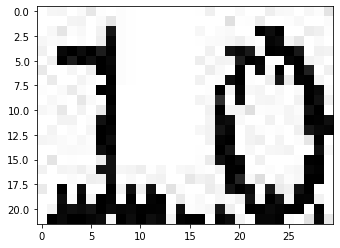

10 is valid.  adding image to subdata with corresponding name


block_number: 28
block_text: 20
block_confidence: 94.0290298461914
block_width: 0.026702821254730225
block_height: 0.07486128807067871
block_left: 0.27355295419692993
block_top: 0.5734789371490479
block_polygon: [{'X': 0.27355295419692993, 'Y': 0.5734789371490479}, {'X': 0.30025577545166016, 'Y': 0.5734789371490479}, {'X': 0.30025577545166016, 'Y': 0.6483402252197266}, {'X': 0.27355295419692993, 'Y': 0.6483402252197266}]
block_polygon_x1: 0.27355295419692993
block_polygon_y1: 0.5734789371490479
block_polygon_x2: 0.30025577545166016
block_polygon_y2: 0.5734789371490479
block_polygon_x3: 0.30025577545166016
block_polygon_y3: 0.6483402252197266
block_polygon_x4: 0.27355295419692993
block_polygon_y4: 0.6483402252197266
left_boundary: 350
right_boundary: 384
bottom_boundary: 218
top_boundary: 247


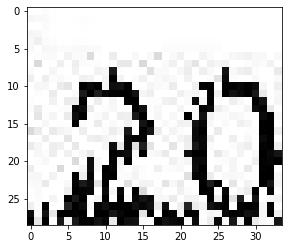

20 is valid.  adding image to subdata with corresponding name


block_number: 29
block_text: 21
block_confidence: 96.9884262084961
block_width: 0.02248045802116394
block_height: 0.05845099687576294
block_left: 0.33198240399360657
block_top: 0.5906598567962646
block_polygon: [{'X': 0.33198240399360657, 'Y': 0.5906598567962646}, {'X': 0.3544628620147705, 'Y': 0.5906598567962646}, {'X': 0.3544628620147705, 'Y': 0.6491108536720276}, {'X': 0.33198240399360657, 'Y': 0.6491108536720276}]
block_polygon_x1: 0.33198240399360657
block_polygon_y1: 0.5906598567962646
block_polygon_x2: 0.3544628620147705
block_polygon_y2: 0.5906598567962646
block_polygon_x3: 0.3544628620147705
block_polygon_y3: 0.6491108536720276
block_polygon_x4: 0.33198240399360657
block_polygon_y4: 0.6491108536720276
left_boundary: 424
right_boundary: 453
bottom_boundary: 225
top_boundary: 247


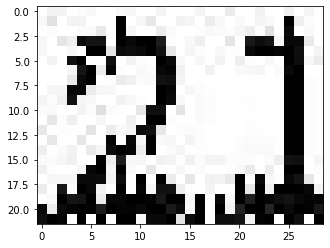

21 is valid.  adding image to subdata with corresponding name


block_number: 30
block_text: TO
block_confidence: 94.45578002929688
block_width: 0.026414573192596436
block_height: 0.05263042449951172
block_left: 0.5358019471168518
block_top: 0.5953033566474915
block_polygon: [{'X': 0.5358019471168518, 'Y': 0.5953033566474915}, {'X': 0.5622165203094482, 'Y': 0.5953033566474915}, {'X': 0.5622165203094482, 'Y': 0.6479337811470032}, {'X': 0.5358019471168518, 'Y': 0.6479337811470032}]
block_polygon_x1: 0.5358019471168518
block_polygon_y1: 0.5953033566474915
block_polygon_x2: 0.5622165203094482
block_polygon_y2: 0.5953033566474915
block_polygon_x3: 0.5622165203094482
block_polygon_y3: 0.6479337811470032
block_polygon_x4: 0.5358019471168518
block_polygon_y4: 0.6479337811470032
left_boundary: 685
right_boundary: 719
bottom_boundary: 226
top_boundary: 246


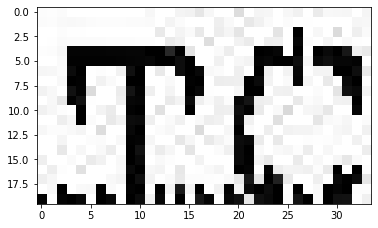

TO is valid.  adding image to subdata with corresponding name


block_number: 31
block_text: 5
block_confidence: 95.67555236816406
block_width: 0.015549207106232643
block_height: 0.07974457740783691
block_left: 0.024810006842017174
block_top: 0.6944076418876648
block_polygon: [{'X': 0.024810006842017174, 'Y': 0.6944076418876648}, {'X': 0.04035921394824982, 'Y': 0.6944076418876648}, {'X': 0.04035921394824982, 'Y': 0.7741522192955017}, {'X': 0.024810006842017174, 'Y': 0.7741522192955017}]
block_polygon_x1: 0.024810006842017174
block_polygon_y1: 0.6944076418876648
block_polygon_x2: 0.04035921394824982
block_polygon_y2: 0.6944076418876648
block_polygon_x3: 0.04035921394824982
block_polygon_y3: 0.7741522192955017
block_polygon_x4: 0.024810006842017174
block_polygon_y4: 0.7741522192955017
left_boundary: 31
right_boundary: 51
bottom_boundary: 264
top_boundary: 294


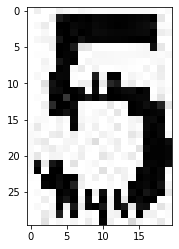

5 is valid.  adding image to subdata with corresponding name


block_number: 32
block_text: 11/10/20
block_confidence: 97.54750061035156
block_width: 0.10219407826662064
block_height: 0.1094900369644165
block_left: 0.058539263904094696
block_top: 0.7137170433998108
block_polygon: [{'X': 0.058539263904094696, 'Y': 0.7137170433998108}, {'X': 0.16073334217071533, 'Y': 0.7137170433998108}, {'X': 0.16073334217071533, 'Y': 0.8232070803642273}, {'X': 0.058539263904094696, 'Y': 0.8232070803642273}]
block_polygon_x1: 0.058539263904094696
block_polygon_y1: 0.7137170433998108
block_polygon_x2: 0.16073334217071533
block_polygon_y2: 0.7137170433998108
block_polygon_x3: 0.16073334217071533
block_polygon_y3: 0.8232070803642273
block_polygon_x4: 0.058539263904094696
block_polygon_y4: 0.8232070803642273
left_boundary: 74
right_boundary: 205
bottom_boundary: 271
top_boundary: 313


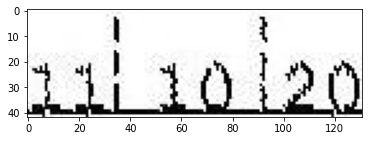

11/10/20 is valid.  adding image to subdata with corresponding name
11/10/20 is a date with a "/" present
new text: 11xxxx10xxxx20


block_number: 33
block_text: 11
block_confidence: 91.87847137451172
block_width: 0.022335484623908997
block_height: 0.05747324228286743
block_left: 0.19872751832008362
block_top: 0.7627432346343994
block_polygon: [{'X': 0.19872751832008362, 'Y': 0.7627432346343994}, {'X': 0.22106300294399261, 'Y': 0.7627432346343994}, {'X': 0.22106300294399261, 'Y': 0.8202164769172668}, {'X': 0.19872751832008362, 'Y': 0.8202164769172668}]
block_polygon_x1: 0.19872751832008362
block_polygon_y1: 0.7627432346343994
block_polygon_x2: 0.22106300294399261
block_polygon_y2: 0.7627432346343994
block_polygon_x3: 0.22106300294399261
block_polygon_y3: 0.8202164769172668
block_polygon_x4: 0.19872751832008362
block_polygon_y4: 0.8202164769172668
left_boundary: 254
right_boundary: 282
bottom_boundary: 290
top_boundary: 312


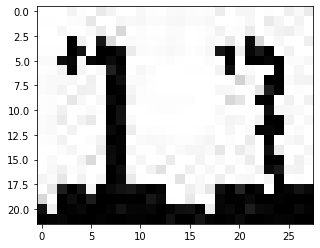

11 is valid.  adding image to subdata with corresponding name


block_number: 34
block_text: 10
block_confidence: 97.49394989013672
block_width: 0.022980839014053345
block_height: 0.06041145324707031
block_left: 0.23826074600219727
block_top: 0.7623476386070251
block_polygon: [{'X': 0.23826074600219727, 'Y': 0.7623476386070251}, {'X': 0.2612415850162506, 'Y': 0.7623476386070251}, {'X': 0.2612415850162506, 'Y': 0.8227590918540955}, {'X': 0.23826074600219727, 'Y': 0.8227590918540955}]
block_polygon_x1: 0.23826074600219727
block_polygon_y1: 0.7623476386070251
block_polygon_x2: 0.2612415850162506
block_polygon_y2: 0.7623476386070251
block_polygon_x3: 0.2612415850162506
block_polygon_y3: 0.8227590918540955
block_polygon_x4: 0.23826074600219727
block_polygon_y4: 0.8227590918540955
left_boundary: 304
right_boundary: 334
bottom_boundary: 290
top_boundary: 313


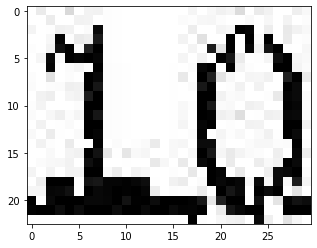

10 is valid.  adding image to subdata with corresponding name


block_number: 35
block_text: 20
block_confidence: 99.3650894165039
block_width: 0.024398744106292725
block_height: 0.062222063541412354
block_left: 0.276242196559906
block_top: 0.7624921798706055
block_polygon: [{'X': 0.276242196559906, 'Y': 0.7624921798706055}, {'X': 0.30064094066619873, 'Y': 0.7624921798706055}, {'X': 0.30064094066619873, 'Y': 0.8247142434120178}, {'X': 0.276242196559906, 'Y': 0.8247142434120178}]
block_polygon_x1: 0.276242196559906
block_polygon_y1: 0.7624921798706055
block_polygon_x2: 0.30064094066619873
block_polygon_y2: 0.7624921798706055
block_polygon_x3: 0.30064094066619873
block_polygon_y3: 0.8247142434120178
block_polygon_x4: 0.276242196559906
block_polygon_y4: 0.8247142434120178
left_boundary: 353
right_boundary: 384
bottom_boundary: 290
top_boundary: 314


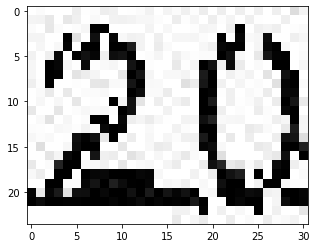

20 is valid.  adding image to subdata with corresponding name


block_number: 36
block_text: 2
block_confidence: 94.76414489746094
block_width: 0.011979818344116211
block_height: 0.05700349807739258
block_left: 0.3319093883037567
block_top: 0.7622151374816895
block_polygon: [{'X': 0.3319093883037567, 'Y': 0.7622151374816895}, {'X': 0.3438892066478729, 'Y': 0.7622151374816895}, {'X': 0.3438892066478729, 'Y': 0.819218635559082}, {'X': 0.3319093883037567, 'Y': 0.819218635559082}]
block_polygon_x1: 0.3319093883037567
block_polygon_y1: 0.7622151374816895
block_polygon_x2: 0.3438892066478729
block_polygon_y2: 0.7622151374816895
block_polygon_x3: 0.3438892066478729
block_polygon_y3: 0.819218635559082
block_polygon_x4: 0.3319093883037567
block_polygon_y4: 0.819218635559082
left_boundary: 424
right_boundary: 440
bottom_boundary: 290
top_boundary: 312


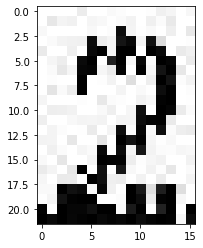

2 is valid.  adding image to subdata with corresponding name


block_number: 37
block_text: TC
block_confidence: 98.15945434570312
block_width: 0.0263403058052063
block_height: 0.051966845989227295
block_left: 0.5359336733818054
block_top: 0.7686918377876282
block_polygon: [{'X': 0.5359336733818054, 'Y': 0.7686918377876282}, {'X': 0.5622739791870117, 'Y': 0.7686918377876282}, {'X': 0.5622739791870117, 'Y': 0.8206586837768555}, {'X': 0.5359336733818054, 'Y': 0.8206586837768555}]
block_polygon_x1: 0.5359336733818054
block_polygon_y1: 0.7686918377876282
block_polygon_x2: 0.5622739791870117
block_polygon_y2: 0.7686918377876282
block_polygon_x3: 0.5622739791870117
block_polygon_y3: 0.8206586837768555
block_polygon_x4: 0.5359336733818054
block_polygon_y4: 0.8206586837768555
left_boundary: 685
right_boundary: 719
bottom_boundary: 292
top_boundary: 312


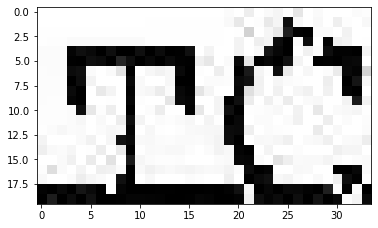

TC is valid.  adding image to subdata with corresponding name


block_number: 38
block_text: A
block_confidence: 90.18582916259766
block_width: 0.014961421489715576
block_height: 0.0610044002532959
block_left: 0.7495178580284119
block_top: 0.7694505453109741
block_polygon: [{'X': 0.7495178580284119, 'Y': 0.7694505453109741}, {'X': 0.7644792795181274, 'Y': 0.7694505453109741}, {'X': 0.7644792795181274, 'Y': 0.83045494556427}, {'X': 0.7495178580284119, 'Y': 0.83045494556427}]
block_polygon_x1: 0.7495178580284119
block_polygon_y1: 0.7694505453109741
block_polygon_x2: 0.7644792795181274
block_polygon_y2: 0.7694505453109741
block_polygon_x3: 0.7644792795181274
block_polygon_y3: 0.83045494556427
block_polygon_x4: 0.7495178580284119
block_polygon_y4: 0.83045494556427
left_boundary: 959
right_boundary: 978
bottom_boundary: 293
top_boundary: 316


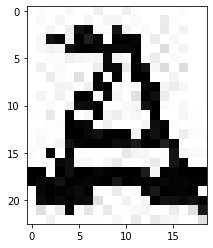

A is valid.  adding image to subdata with corresponding name


block_number: 39
block_text: 1890
block_confidence: 99.3638687133789
block_width: 0.049567997455596924
block_height: 0.06616532802581787
block_left: 0.8426281213760376
block_top: 0.7684125304222107
block_polygon: [{'X': 0.8426281213760376, 'Y': 0.7684125304222107}, {'X': 0.8921961188316345, 'Y': 0.7684125304222107}, {'X': 0.8921961188316345, 'Y': 0.8345778584480286}, {'X': 0.8426281213760376, 'Y': 0.8345778584480286}]
block_polygon_x1: 0.8426281213760376
block_polygon_y1: 0.7684125304222107
block_polygon_x2: 0.8921961188316345
block_polygon_y2: 0.7684125304222107
block_polygon_x3: 0.8921961188316345
block_polygon_y3: 0.8345778584480286
block_polygon_x4: 0.8426281213760376
block_polygon_y4: 0.8345778584480286
left_boundary: 1078
right_boundary: 1142
bottom_boundary: 292
top_boundary: 317


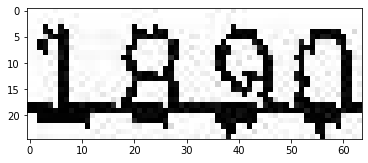

1890 is valid.  adding image to subdata with corresponding name


block_number: 40
block_text: 00
block_confidence: 88.13521575927734
block_width: 0.0240747332572937
block_height: 0.06767821311950684
block_left: 0.9045136570930481
block_top: 0.7682822346687317
block_polygon: [{'X': 0.9045136570930481, 'Y': 0.7682822346687317}, {'X': 0.9285883903503418, 'Y': 0.7682822346687317}, {'X': 0.9285883903503418, 'Y': 0.8359604477882385}, {'X': 0.9045136570930481, 'Y': 0.8359604477882385}]
block_polygon_x1: 0.9045136570930481
block_polygon_y1: 0.7682822346687317
block_polygon_x2: 0.9285883903503418
block_polygon_y2: 0.7682822346687317
block_polygon_x3: 0.9285883903503418
block_polygon_y3: 0.8359604477882385
block_polygon_x4: 0.9045136570930481
block_polygon_y4: 0.8359604477882385
left_boundary: 1157
right_boundary: 1188
bottom_boundary: 292
top_boundary: 318


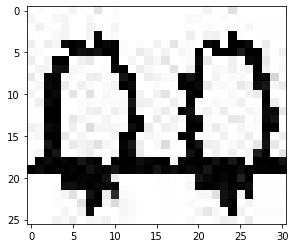

00 is valid.  adding image to subdata with corresponding name


block_number: 41
block_text: 1
block_confidence: 99.33048248291016
block_width: 0.011204898357391357
block_height: 0.06895452737808228
block_left: 0.9601669311523438
block_top: 0.7680234909057617
block_polygon: [{'X': 0.9601669311523438, 'Y': 0.7680234909057617}, {'X': 0.9713718295097351, 'Y': 0.7680234909057617}, {'X': 0.9713718295097351, 'Y': 0.836978018283844}, {'X': 0.9601669311523438, 'Y': 0.836978018283844}]
block_polygon_x1: 0.9601669311523438
block_polygon_y1: 0.7680234909057617
block_polygon_x2: 0.9713718295097351
block_polygon_y2: 0.7680234909057617
block_polygon_x3: 0.9713718295097351
block_polygon_y3: 0.836978018283844
block_polygon_x4: 0.9601669311523438
block_polygon_y4: 0.836978018283844
left_boundary: 1229
right_boundary: 1243
bottom_boundary: 292
top_boundary: 318


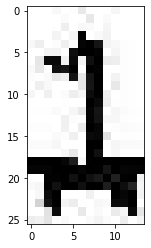

1 is valid.  adding image to subdata with corresponding name


block_number: 42
block_text: 6
block_confidence: 88.19722747802734
block_width: 0.016767144203186035
block_height: 0.08039277791976929
block_left: 0.02451646700501442
block_top: 0.8624551892280579
block_polygon: [{'X': 0.02451646700501442, 'Y': 0.8624551892280579}, {'X': 0.041283611208200455, 'Y': 0.8624551892280579}, {'X': 0.041283611208200455, 'Y': 0.9428479671478271}, {'X': 0.02451646700501442, 'Y': 0.9428479671478271}]
block_polygon_x1: 0.02451646700501442
block_polygon_y1: 0.8624551892280579
block_polygon_x2: 0.041283611208200455
block_polygon_y2: 0.8624551892280579
block_polygon_x3: 0.041283611208200455
block_polygon_y3: 0.9428479671478271
block_polygon_x4: 0.02451646700501442
block_polygon_y4: 0.9428479671478271
left_boundary: 31
right_boundary: 52
bottom_boundary: 328
top_boundary: 359


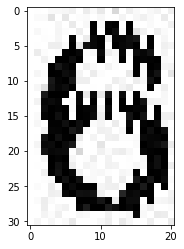

6 is valid.  adding image to subdata with corresponding name


block_number: 43
block_text: 11
block_confidence: 93.52969360351562
block_width: 0.022165566682815552
block_height: 0.05431598424911499
block_left: 0.19874528050422668
block_top: 0.9360386729240417
block_polygon: [{'X': 0.19874528050422668, 'Y': 0.9360386729240417}, {'X': 0.22091084718704224, 'Y': 0.9360386729240417}, {'X': 0.22091084718704224, 'Y': 0.9903546571731567}, {'X': 0.19874528050422668, 'Y': 0.9903546571731567}]
block_polygon_x1: 0.19874528050422668
block_polygon_y1: 0.9360386729240417
block_polygon_x2: 0.22091084718704224
block_polygon_y2: 0.9360386729240417
block_polygon_x3: 0.22091084718704224
block_polygon_y3: 0.9903546571731567
block_polygon_x4: 0.19874528050422668
block_polygon_y4: 0.9903546571731567
left_boundary: 254
right_boundary: 282
bottom_boundary: 356
top_boundary: 377


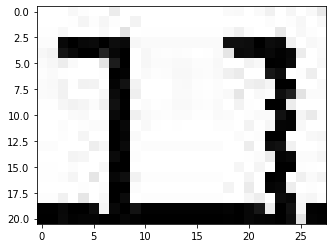

11 is valid.  adding image to subdata with corresponding name


block_number: 44
block_text: 10
block_confidence: 96.61309814453125
block_width: 0.02137523889541626
block_height: 0.05647587776184082
block_left: 0.2402963638305664
block_top: 0.934306263923645
block_polygon: [{'X': 0.2402963638305664, 'Y': 0.934306263923645}, {'X': 0.26167160272598267, 'Y': 0.934306263923645}, {'X': 0.26167160272598267, 'Y': 0.9907821416854858}, {'X': 0.2402963638305664, 'Y': 0.9907821416854858}]
block_polygon_x1: 0.2402963638305664
block_polygon_y1: 0.934306263923645
block_polygon_x2: 0.26167160272598267
block_polygon_y2: 0.934306263923645
block_polygon_x3: 0.26167160272598267
block_polygon_y3: 0.9907821416854858
block_polygon_x4: 0.2402963638305664
block_polygon_y4: 0.9907821416854858
left_boundary: 307
right_boundary: 334
bottom_boundary: 355
top_boundary: 377


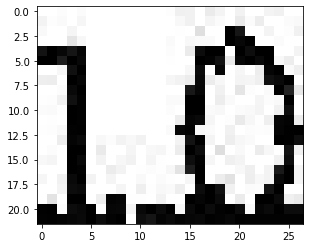

10 is valid.  adding image to subdata with corresponding name


block_number: 45
block_text: 20
block_confidence: 99.35394287109375
block_width: 0.02406001091003418
block_height: 0.06138277053833008
block_left: 0.276634156703949
block_top: 0.934950590133667
block_polygon: [{'X': 0.276634156703949, 'Y': 0.934950590133667}, {'X': 0.30069416761398315, 'Y': 0.934950590133667}, {'X': 0.30069416761398315, 'Y': 0.9963333606719971}, {'X': 0.276634156703949, 'Y': 0.9963333606719971}]
block_polygon_x1: 0.276634156703949
block_polygon_y1: 0.934950590133667
block_polygon_x2: 0.30069416761398315
block_polygon_y2: 0.934950590133667
block_polygon_x3: 0.30069416761398315
block_polygon_y3: 0.9963333606719971
block_polygon_x4: 0.276634156703949
block_polygon_y4: 0.9963333606719971
left_boundary: 354
right_boundary: 384
bottom_boundary: 356
top_boundary: 379


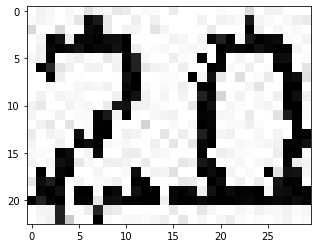

20 is valid.  adding image to subdata with corresponding name


block_number: 46
block_text: A
block_confidence: 99.35256958007812
block_width: 0.015132308006286621
block_height: 0.055848121643066406
block_left: 0.7492212057113647
block_top: 0.9428395628929138
block_polygon: [{'X': 0.7492212057113647, 'Y': 0.9428395628929138}, {'X': 0.7643535137176514, 'Y': 0.9428395628929138}, {'X': 0.7643535137176514, 'Y': 0.9986876845359802}, {'X': 0.7492212057113647, 'Y': 0.9986876845359802}]
block_polygon_x1: 0.7492212057113647
block_polygon_y1: 0.9428395628929138
block_polygon_x2: 0.7643535137176514
block_polygon_y2: 0.9428395628929138
block_polygon_x3: 0.7643535137176514
block_polygon_y3: 0.9986876845359802
block_polygon_x4: 0.7492212057113647
block_polygon_y4: 0.9986876845359802
left_boundary: 959
right_boundary: 978
bottom_boundary: 359
top_boundary: 380


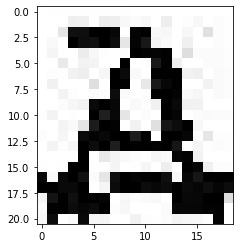

A is valid.  adding image to subdata with corresponding name


block_number: 47
block_text: 4216
block_confidence: 96.07954406738281
block_width: 0.05042588710784912
block_height: 0.05637925863265991
block_left: 0.8430107831954956
block_top: 0.9423084259033203
block_polygon: [{'X': 0.8430107831954956, 'Y': 0.9423084259033203}, {'X': 0.8934366703033447, 'Y': 0.9423084259033203}, {'X': 0.8934366703033447, 'Y': 0.9986876845359802}, {'X': 0.8430107831954956, 'Y': 0.9986876845359802}]
block_polygon_x1: 0.8430107831954956
block_polygon_y1: 0.9423084259033203
block_polygon_x2: 0.8934366703033447
block_polygon_y2: 0.9423084259033203
block_polygon_x3: 0.8934366703033447
block_polygon_y3: 0.9986876845359802
block_polygon_x4: 0.8430107831954956
block_polygon_y4: 0.9986876845359802
left_boundary: 1079
right_boundary: 1143
bottom_boundary: 359
top_boundary: 380


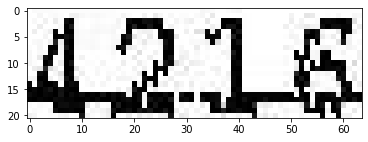

4216 is valid.  adding image to subdata with corresponding name


block_number: 48
block_text: 1
block_confidence: 93.70718383789062
block_width: 0.008942604064941406
block_height: 0.05634588003158569
block_left: 0.9606901407241821
block_top: 0.9423417448997498
block_polygon: [{'X': 0.9606901407241821, 'Y': 0.9423417448997498}, {'X': 0.9696327447891235, 'Y': 0.9423417448997498}, {'X': 0.9696327447891235, 'Y': 0.9986876249313354}, {'X': 0.9606901407241821, 'Y': 0.9986876249313354}]
block_polygon_x1: 0.9606901407241821
block_polygon_y1: 0.9423417448997498
block_polygon_x2: 0.9696327447891235
block_polygon_y2: 0.9423417448997498
block_polygon_x3: 0.9696327447891235
block_polygon_y3: 0.9986876249313354
block_polygon_x4: 0.9606901407241821
block_polygon_y4: 0.9986876249313354
left_boundary: 1229
right_boundary: 1241
bottom_boundary: 359
top_boundary: 380


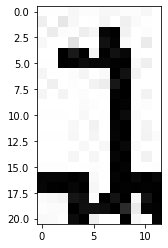

1 is valid.  adding image to subdata with corresponding name


filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage2.jpeg
json_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage2.json


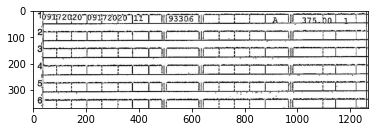

block_number: 1
block_text: 9
block_confidence: 97.65338897705078
block_width: 0.014572322368621826
block_height: 0.07836702466011047
block_left: 0.012460844591259956
block_top: 0.8780025243759155
block_polygon: [{'X': 0.027033166959881783, 'Y': 0.9563695788383484}, {'X': 0.012460844591259956, 'Y': 0.9563695788383484}, {'X': 0.012460844591259956, 'Y': 0.8780025243759155}, {'X': 0.027033166959881783, 'Y': 0.8780025243759155}]
block_polygon_x1: 0.027033166959881783
block_polygon_y1: 0.9563695788383484
block_polygon_x2: 0.012460844591259956
block_polygon_y2: 0.9563695788383484
block_polygon_x3: 0.012460844591259956
block_polygon_y3: 0.8780025243759155
block_polygon_x4: 0.027033166959881783
block_polygon_y4: 0.8780025243759155
left_boundary: 34
right_boundary: 15
bottom_boundary: 351
top_boundary: 323


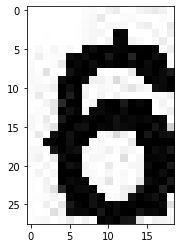

9 is valid.  adding image to subdata with corresponding name


block_number: 2
block_text: â‚¬
block_confidence: 76.90819549560547
block_width: 0.015154242515563965
block_height: 0.07436144351959229
block_left: 0.01229612436145544
block_top: 0.35687899589538574
block_polygon: [{'X': 0.02745036780834198, 'Y': 0.431240439414978}, {'X': 0.01229612436145544, 'Y': 0.431240439414978}, {'X': 0.01229612436145544, 'Y': 0.35687899589538574}, {'X': 0.02745036780834198, 'Y': 0.35687899589538574}]
block_polygon_x1: 0.02745036780834198
block_polygon_y1: 0.431240439414978
block_polygon_x2: 0.01229612436145544
block_polygon_y2: 0.431240439414978
block_polygon_x3: 0.01229612436145544
block_polygon_y3: 0.35687899589538574
block_polygon_x4: 0.02745036780834198
block_polygon_y4: 0.35687899589538574
left_boundary: 34
right_boundary: 15
bottom_boundary: 158
top_boundary: 131


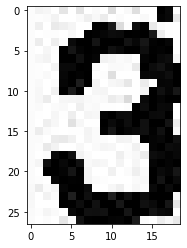



block_number: 3
block_text: I
block_confidence: 94.97144317626953
block_width: 0.011535365134477615
block_height: 0.06748330593109131
block_left: 0.9266452789306641
block_top: 0.07513239234685898
block_polygon: [{'X': 0.9381806254386902, 'Y': 0.14261570572853088}, {'X': 0.9266452789306641, 'Y': 0.14261570572853088}, {'X': 0.9266452789306641, 'Y': 0.07513239234685898}, {'X': 0.9381806254386902, 'Y': 0.07513239234685898}]
block_polygon_x1: 0.9381806254386902
block_polygon_y1: 0.14261570572853088
block_polygon_x2: 0.9266452789306641
block_polygon_y2: 0.14261570572853088
block_polygon_x3: 0.9266452789306641
block_polygon_y3: 0.07513239234685898
block_polygon_x4: 0.9381806254386902
block_polygon_y4: 0.07513239234685898
left_boundary: 1188
right_boundary: 1174
bottom_boundary: 52
top_boundary: 27


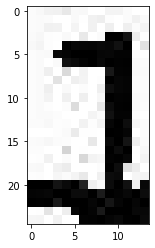

I is valid.  adding image to subdata with corresponding name


block_number: 4
block_text: 00 SZE
block_confidence: 80.1745834350586
block_width: 0.08911481499671936
block_height: 0.06655246019363403
block_left: 0.8022728562355042
block_top: 0.0701674371957779
block_polygon: [{'X': 0.8913876414299011, 'Y': 0.13671989738941193}, {'X': 0.8022728562355042, 'Y': 0.13671989738941193}, {'X': 0.8022728562355042, 'Y': 0.0701674371957779}, {'X': 0.8913876414299011, 'Y': 0.0701674371957779}]
block_polygon_x1: 0.8913876414299011
block_polygon_y1: 0.13671989738941193
block_polygon_x2: 0.8022728562355042
block_polygon_y2: 0.13671989738941193
block_polygon_x3: 0.8022728562355042
block_polygon_y3: 0.0701674371957779
block_polygon_x4: 0.8913876414299011
block_polygon_y4: 0.0701674371957779
left_boundary: 1129
right_boundary: 1016
bottom_boundary: 50
top_boundary: 25


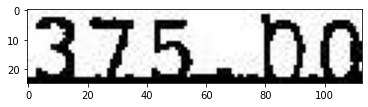

00 SZE is valid.  adding image to subdata with corresponding name


block_number: 5
block_text: II
block_confidence: 85.0113296508789
block_width: 0.028609514236450195
block_height: 0.07193922996520996
block_left: 0.2983599603176117
block_top: 0.0450509712100029
block_polygon: [{'X': 0.3269694745540619, 'Y': 0.11699020117521286}, {'X': 0.2983599603176117, 'Y': 0.11699020117521286}, {'X': 0.2983599603176117, 'Y': 0.0450509712100029}, {'X': 0.3269694745540619, 'Y': 0.0450509712100029}]
block_polygon_x1: 0.3269694745540619
block_polygon_y1: 0.11699020117521286
block_polygon_x2: 0.2983599603176117
block_polygon_y2: 0.11699020117521286
block_polygon_x3: 0.2983599603176117
block_polygon_y3: 0.0450509712100029
block_polygon_x4: 0.3269694745540619
block_polygon_y4: 0.0450509712100029
left_boundary: 414
right_boundary: 378
bottom_boundary: 43
top_boundary: 16


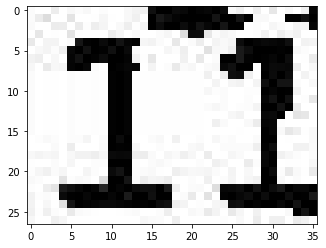

II is valid.  adding image to subdata with corresponding name


block_number: 6
block_text: 1
block_confidence: 93.36681365966797
block_width: 0.01154857873916626
block_height: 0.07461446523666382
block_left: 0.01319152768701315
block_top: 0.010934734717011452
block_polygon: [{'X': 0.024740107357501984, 'Y': 0.08554919809103012}, {'X': 0.01319152768701315, 'Y': 0.08554919809103012}, {'X': 0.01319152768701315, 'Y': 0.010934734717011452}, {'X': 0.024740107357501984, 'Y': 0.010934734717011452}]
block_polygon_x1: 0.024740107357501984
block_polygon_y1: 0.08554919809103012
block_polygon_x2: 0.01319152768701315
block_polygon_y2: 0.08554919809103012
block_polygon_x3: 0.01319152768701315
block_polygon_y3: 0.010934734717011452
block_polygon_x4: 0.024740107357501984
block_polygon_y4: 0.010934734717011452
left_boundary: 31
right_boundary: 16
bottom_boundary: 31
top_boundary: 4


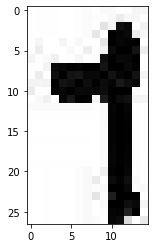

1 is valid.  adding image to subdata with corresponding name


filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage3.jpeg
json_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage3.json


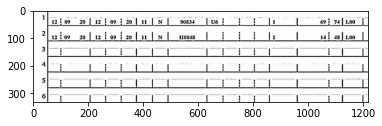

block_number: 1
block_text: 1
block_confidence: 99.8008041381836
block_width: 0.008465740829706192
block_height: 0.058555398136377335
block_left: 0.027056127786636353
block_top: 0.0419398657977581
block_polygon: [{'X': 0.027056127786636353, 'Y': 0.0419398657977581}, {'X': 0.035521868616342545, 'Y': 0.0419398657977581}, {'X': 0.035521868616342545, 'Y': 0.10049526393413544}, {'X': 0.027056127786636353, 'Y': 0.10049526393413544}]
block_polygon_x1: 0.027056127786636353
block_polygon_y1: 0.0419398657977581
block_polygon_x2: 0.035521868616342545
block_polygon_y2: 0.0419398657977581
block_polygon_x3: 0.035521868616342545
block_polygon_y3: 0.10049526393413544
block_polygon_x4: 0.027056127786636353
block_polygon_y4: 0.10049526393413544
left_boundary: 32
right_boundary: 43
bottom_boundary: 13
top_boundary: 33


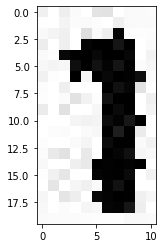

1 is valid.  adding image to subdata with corresponding name


block_number: 2
block_text: 12
block_confidence: 99.80215454101562
block_width: 0.017112456262111664
block_height: 0.049844011664390564
block_left: 0.056265734136104584
block_top: 0.09577487409114838
block_polygon: [{'X': 0.056265734136104584, 'Y': 0.09577487409114838}, {'X': 0.07337819039821625, 'Y': 0.09577487409114838}, {'X': 0.07337819039821625, 'Y': 0.14561888575553894}, {'X': 0.056265734136104584, 'Y': 0.14561888575553894}]
block_polygon_x1: 0.056265734136104584
block_polygon_y1: 0.09577487409114838
block_polygon_x2: 0.07337819039821625
block_polygon_y2: 0.09577487409114838
block_polygon_x3: 0.07337819039821625
block_polygon_y3: 0.14561888575553894
block_polygon_x4: 0.056265734136104584
block_polygon_y4: 0.14561888575553894
left_boundary: 68
right_boundary: 89
bottom_boundary: 31
top_boundary: 48


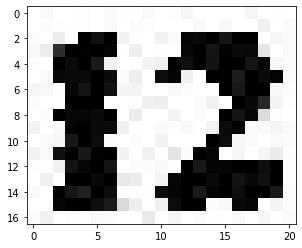

12 is valid.  adding image to subdata with corresponding name


block_number: 3
block_text: 09
block_confidence: 99.82522583007812
block_width: 0.018185392022132874
block_height: 0.048147983849048615
block_left: 0.09346379339694977
block_top: 0.09505363553762436
block_polygon: [{'X': 0.09346379339694977, 'Y': 0.09505363553762436}, {'X': 0.11164918541908264, 'Y': 0.09505363553762436}, {'X': 0.11164918541908264, 'Y': 0.14320161938667297}, {'X': 0.09346379339694977, 'Y': 0.14320161938667297}]
block_polygon_x1: 0.09346379339694977
block_polygon_y1: 0.09505363553762436
block_polygon_x2: 0.11164918541908264
block_polygon_y2: 0.09505363553762436
block_polygon_x3: 0.11164918541908264
block_polygon_y3: 0.14320161938667297
block_polygon_x4: 0.09346379339694977
block_polygon_y4: 0.14320161938667297
left_boundary: 113
right_boundary: 135
bottom_boundary: 31
top_boundary: 47


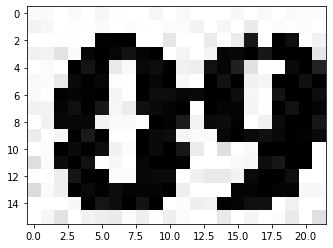

09 is valid.  adding image to subdata with corresponding name


block_number: 4
block_text: 20
block_confidence: 99.79145812988281
block_width: 0.01843401789665222
block_height: 0.04920109361410141
block_left: 0.13830123841762543
block_top: 0.09573552757501602
block_polygon: [{'X': 0.13830123841762543, 'Y': 0.09573552757501602}, {'X': 0.15673525631427765, 'Y': 0.09573552757501602}, {'X': 0.15673525631427765, 'Y': 0.14493662118911743}, {'X': 0.13830123841762543, 'Y': 0.14493662118911743}]
block_polygon_x1: 0.13830123841762543
block_polygon_y1: 0.09573552757501602
block_polygon_x2: 0.15673525631427765
block_polygon_y2: 0.09573552757501602
block_polygon_x3: 0.15673525631427765
block_polygon_y3: 0.14493662118911743
block_polygon_x4: 0.13830123841762543
block_polygon_y4: 0.14493662118911743
left_boundary: 168
right_boundary: 190
bottom_boundary: 31
top_boundary: 47


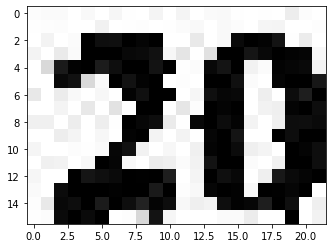

20 is valid.  adding image to subdata with corresponding name


block_number: 5
block_text: 12
block_confidence: 99.90374755859375
block_width: 0.016888990998268127
block_height: 0.049084775149822235
block_left: 0.1860038787126541
block_top: 0.09575431793928146
block_polygon: [{'X': 0.1860038787126541, 'Y': 0.09575431793928146}, {'X': 0.20289286971092224, 'Y': 0.09575431793928146}, {'X': 0.20289286971092224, 'Y': 0.1448390930891037}, {'X': 0.1860038787126541, 'Y': 0.1448390930891037}]
block_polygon_x1: 0.1860038787126541
block_polygon_y1: 0.09575431793928146
block_polygon_x2: 0.20289286971092224
block_polygon_y2: 0.09575431793928146
block_polygon_x3: 0.20289286971092224
block_polygon_y3: 0.1448390930891037
block_polygon_x4: 0.1860038787126541
block_polygon_y4: 0.1448390930891037
left_boundary: 226
right_boundary: 247
bottom_boundary: 31
top_boundary: 47


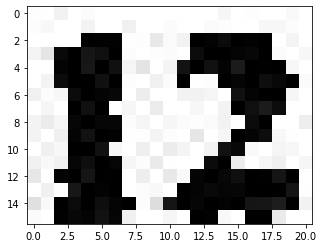

12 is valid.  adding image to subdata with corresponding name


block_number: 6
block_text: 09
block_confidence: 99.86143493652344
block_width: 0.01865355670452118
block_height: 0.049192287027835846
block_left: 0.22996288537979126
block_top: 0.09532197564840317
block_polygon: [{'X': 0.22996288537979126, 'Y': 0.09532197564840317}, {'X': 0.24861644208431244, 'Y': 0.09532197564840317}, {'X': 0.24861644208431244, 'Y': 0.144514262676239}, {'X': 0.22996288537979126, 'Y': 0.144514262676239}]
block_polygon_x1: 0.22996288537979126
block_polygon_y1: 0.09532197564840317
block_polygon_x2: 0.24861644208431244
block_polygon_y2: 0.09532197564840317
block_polygon_x3: 0.24861644208431244
block_polygon_y3: 0.144514262676239
block_polygon_x4: 0.22996288537979126
block_polygon_y4: 0.144514262676239
left_boundary: 280
right_boundary: 302
bottom_boundary: 31
top_boundary: 47


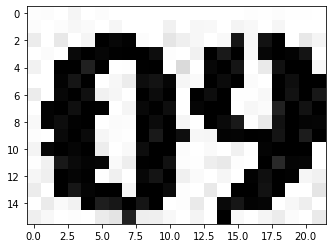

09 is valid.  adding image to subdata with corresponding name


block_number: 7
block_text: 20
block_confidence: 99.8008041381836
block_width: 0.018327444791793823
block_height: 0.04798543453216553
block_left: 0.277464896440506
block_top: 0.09660618007183075
block_polygon: [{'X': 0.277464896440506, 'Y': 0.09660618007183075}, {'X': 0.2957923412322998, 'Y': 0.09660618007183075}, {'X': 0.2957923412322998, 'Y': 0.14459161460399628}, {'X': 0.277464896440506, 'Y': 0.14459161460399628}]
block_polygon_x1: 0.277464896440506
block_polygon_y1: 0.09660618007183075
block_polygon_x2: 0.2957923412322998
block_polygon_y2: 0.09660618007183075
block_polygon_x3: 0.2957923412322998
block_polygon_y3: 0.14459161460399628
block_polygon_x4: 0.277464896440506
block_polygon_y4: 0.14459161460399628
left_boundary: 337
right_boundary: 360
bottom_boundary: 31
top_boundary: 47


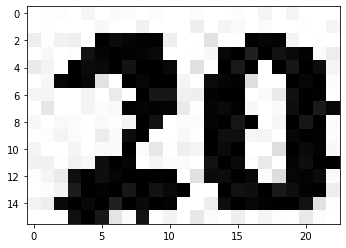

20 is valid.  adding image to subdata with corresponding name


block_number: 8
block_text: N
block_confidence: 99.75800323486328
block_width: 0.013627439737319946
block_height: 0.04876898229122162
block_left: 0.37326768040657043
block_top: 0.09525094926357269
block_polygon: [{'X': 0.37326768040657043, 'Y': 0.09525094926357269}, {'X': 0.3868951201438904, 'Y': 0.09525094926357269}, {'X': 0.3868951201438904, 'Y': 0.1440199315547943}, {'X': 0.37326768040657043, 'Y': 0.1440199315547943}]
block_polygon_x1: 0.37326768040657043
block_polygon_y1: 0.09525094926357269
block_polygon_x2: 0.3868951201438904
block_polygon_y2: 0.09525094926357269
block_polygon_x3: 0.3868951201438904
block_polygon_y3: 0.1440199315547943
block_polygon_x4: 0.37326768040657043
block_polygon_y4: 0.1440199315547943
left_boundary: 454
right_boundary: 471
bottom_boundary: 31
top_boundary: 47


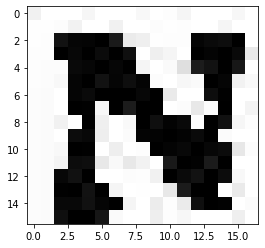

N is valid.  adding image to subdata with corresponding name


block_number: 9
block_text: U6
block_confidence: 99.73311614990234
block_width: 0.023035109043121338
block_height: 0.051952481269836426
block_left: 0.5309887528419495
block_top: 0.0936676487326622
block_polygon: [{'X': 0.5309887528419495, 'Y': 0.0936676487326622}, {'X': 0.5540238618850708, 'Y': 0.0936676487326622}, {'X': 0.5540238618850708, 'Y': 0.14562012255191803}, {'X': 0.5309887528419495, 'Y': 0.14562012255191803}]
block_polygon_x1: 0.5309887528419495
block_polygon_y1: 0.0936676487326622
block_polygon_x2: 0.5540238618850708
block_polygon_y2: 0.0936676487326622
block_polygon_x3: 0.5540238618850708
block_polygon_y3: 0.14562012255191803
block_polygon_x4: 0.5309887528419495
block_polygon_y4: 0.14562012255191803
left_boundary: 646
right_boundary: 674
bottom_boundary: 31
top_boundary: 48


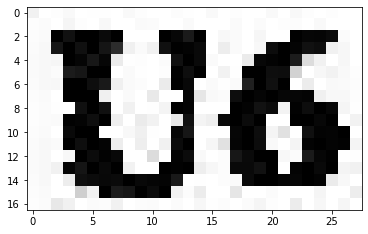

U6 is valid.  adding image to subdata with corresponding name


block_number: 10
block_text: 1
block_confidence: 98.75677490234375
block_width: 0.007060527801513672
block_height: 0.05096346139907837
block_left: 0.7157564163208008
block_top: 0.09533579647541046
block_polygon: [{'X': 0.7157564163208008, 'Y': 0.09533579647541046}, {'X': 0.7228169441223145, 'Y': 0.09533579647541046}, {'X': 0.7228169441223145, 'Y': 0.14629925787448883}, {'X': 0.7157564163208008, 'Y': 0.14629925787448883}]
block_polygon_x1: 0.7157564163208008
block_polygon_y1: 0.09533579647541046
block_polygon_x2: 0.7228169441223145
block_polygon_y2: 0.09533579647541046
block_polygon_x3: 0.7228169441223145
block_polygon_y3: 0.14629925787448883
block_polygon_x4: 0.7157564163208008
block_polygon_y4: 0.14629925787448883
left_boundary: 871
right_boundary: 880
bottom_boundary: 31
top_boundary: 48


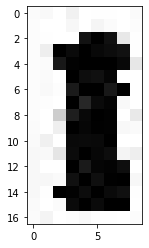

1 is valid.  adding image to subdata with corresponding name


block_number: 11
block_text: 69
block_confidence: 99.69743347167969
block_width: 0.018292725086212158
block_height: 0.04885989427566528
block_left: 0.856918454170227
block_top: 0.0951896458864212
block_polygon: [{'X': 0.856918454170227, 'Y': 0.0951896458864212}, {'X': 0.8752111792564392, 'Y': 0.0951896458864212}, {'X': 0.8752111792564392, 'Y': 0.1440495401620865}, {'X': 0.856918454170227, 'Y': 0.1440495401620865}]
block_polygon_x1: 0.856918454170227
block_polygon_y1: 0.0951896458864212
block_polygon_x2: 0.8752111792564392
block_polygon_y2: 0.0951896458864212
block_polygon_x3: 0.8752111792564392
block_polygon_y3: 0.1440495401620865
block_polygon_x4: 0.856918454170227
block_polygon_y4: 0.1440495401620865
left_boundary: 1043
right_boundary: 1066
bottom_boundary: 31
top_boundary: 47


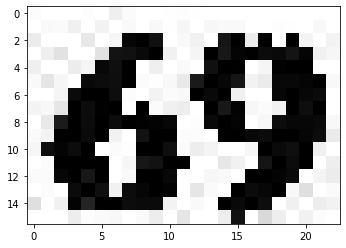

69 is valid.  adding image to subdata with corresponding name


block_number: 12
block_text: 74
block_confidence: 99.66685485839844
block_width: 0.01941061019897461
block_height: 0.05153738707304001
block_left: 0.8974061012268066
block_top: 0.09320249408483505
block_polygon: [{'X': 0.8974061012268066, 'Y': 0.09320249408483505}, {'X': 0.9168167114257812, 'Y': 0.09320249408483505}, {'X': 0.9168167114257812, 'Y': 0.14473988115787506}, {'X': 0.8974061012268066, 'Y': 0.14473988115787506}]
block_polygon_x1: 0.8974061012268066
block_polygon_y1: 0.09320249408483505
block_polygon_x2: 0.9168167114257812
block_polygon_y2: 0.09320249408483505
block_polygon_x3: 0.9168167114257812
block_polygon_y3: 0.14473988115787506
block_polygon_x4: 0.8974061012268066
block_polygon_y4: 0.14473988115787506
left_boundary: 1093
right_boundary: 1116
bottom_boundary: 30
top_boundary: 47


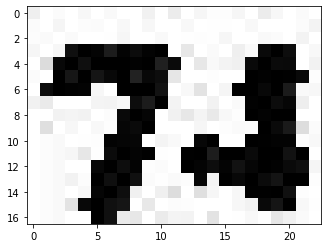

74 is valid.  adding image to subdata with corresponding name


block_number: 13
block_text: 1.00
block_confidence: 98.93648529052734
block_width: 0.02988576889038086
block_height: 0.05115388333797455
block_left: 0.9326024651527405
block_top: 0.09431867301464081
block_polygon: [{'X': 0.9326024651527405, 'Y': 0.09431867301464081}, {'X': 0.9624882340431213, 'Y': 0.09431867301464081}, {'X': 0.9624882340431213, 'Y': 0.14547255635261536}, {'X': 0.9326024651527405, 'Y': 0.14547255635261536}]
block_polygon_x1: 0.9326024651527405
block_polygon_y1: 0.09431867301464081
block_polygon_x2: 0.9624882340431213
block_polygon_y2: 0.09431867301464081
block_polygon_x3: 0.9624882340431213
block_polygon_y3: 0.14547255635261536
block_polygon_x4: 0.9326024651527405
block_polygon_y4: 0.14547255635261536
left_boundary: 1135
right_boundary: 1172
bottom_boundary: 31
top_boundary: 48


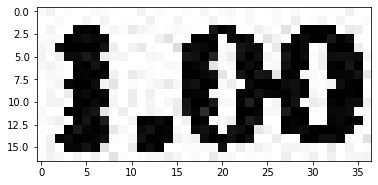



block_number: 14
block_text: 2
block_confidence: 99.82024383544922
block_width: 0.012130411341786385
block_height: 0.05808113515377045
block_left: 0.026033425703644753
block_top: 0.21694964170455933
block_polygon: [{'X': 0.026033425703644753, 'Y': 0.21694964170455933}, {'X': 0.03816383704543114, 'Y': 0.21694964170455933}, {'X': 0.03816383704543114, 'Y': 0.27503079175949097}, {'X': 0.026033425703644753, 'Y': 0.27503079175949097}]
block_polygon_x1: 0.026033425703644753
block_polygon_y1: 0.21694964170455933
block_polygon_x2: 0.03816383704543114
block_polygon_y2: 0.21694964170455933
block_polygon_x3: 0.03816383704543114
block_polygon_y3: 0.27503079175949097
block_polygon_x4: 0.026033425703644753
block_polygon_y4: 0.27503079175949097
left_boundary: 31
right_boundary: 46
bottom_boundary: 71
top_boundary: 91


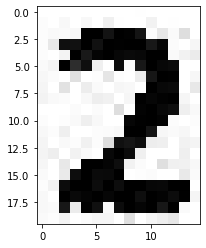

2 is valid.  adding image to subdata with corresponding name


block_number: 15
block_text: 12
block_confidence: 99.04830169677734
block_width: 0.01697784662246704
block_height: 0.04915124177932739
block_left: 0.05633532255887985
block_top: 0.26603469252586365
block_polygon: [{'X': 0.05633532255887985, 'Y': 0.26603469252586365}, {'X': 0.0733131691813469, 'Y': 0.26603469252586365}, {'X': 0.0733131691813469, 'Y': 0.31518593430519104}, {'X': 0.05633532255887985, 'Y': 0.31518593430519104}]
block_polygon_x1: 0.05633532255887985
block_polygon_y1: 0.26603469252586365
block_polygon_x2: 0.0733131691813469
block_polygon_y2: 0.26603469252586365
block_polygon_x3: 0.0733131691813469
block_polygon_y3: 0.31518593430519104
block_polygon_x4: 0.05633532255887985
block_polygon_y4: 0.31518593430519104
left_boundary: 68
right_boundary: 89
bottom_boundary: 88
top_boundary: 104


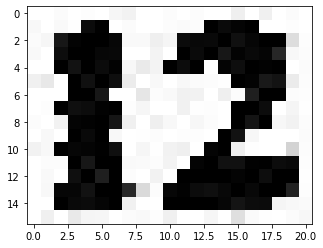

12 is valid.  adding image to subdata with corresponding name


block_number: 16
block_text: 09
block_confidence: 99.56782531738281
block_width: 0.018797680735588074
block_height: 0.048745423555374146
block_left: 0.09244426339864731
block_top: 0.26512399315834045
block_polygon: [{'X': 0.09244426339864731, 'Y': 0.26512399315834045}, {'X': 0.11124193668365479, 'Y': 0.26512399315834045}, {'X': 0.11124193668365479, 'Y': 0.3138694167137146}, {'X': 0.09244426339864731, 'Y': 0.3138694167137146}]
block_polygon_x1: 0.09244426339864731
block_polygon_y1: 0.26512399315834045
block_polygon_x2: 0.11124193668365479
block_polygon_y2: 0.26512399315834045
block_polygon_x3: 0.11124193668365479
block_polygon_y3: 0.3138694167137146
block_polygon_x4: 0.09244426339864731
block_polygon_y4: 0.3138694167137146
left_boundary: 112
right_boundary: 135
bottom_boundary: 87
top_boundary: 103


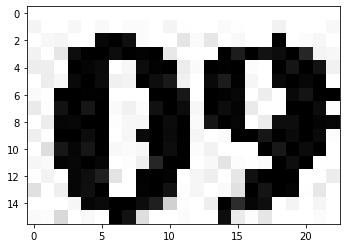

09 is valid.  adding image to subdata with corresponding name


block_number: 17
block_text: 20
block_confidence: 99.6980972290039
block_width: 0.01837576925754547
block_height: 0.04903528094291687
block_left: 0.13830091059207916
block_top: 0.26562631130218506
block_polygon: [{'X': 0.13830091059207916, 'Y': 0.26562631130218506}, {'X': 0.15667667984962463, 'Y': 0.26562631130218506}, {'X': 0.15667667984962463, 'Y': 0.31466159224510193}, {'X': 0.13830091059207916, 'Y': 0.31466159224510193}]
block_polygon_x1: 0.13830091059207916
block_polygon_y1: 0.26562631130218506
block_polygon_x2: 0.15667667984962463
block_polygon_y2: 0.26562631130218506
block_polygon_x3: 0.15667667984962463
block_polygon_y3: 0.31466159224510193
block_polygon_x4: 0.13830091059207916
block_polygon_y4: 0.31466159224510193
left_boundary: 168
right_boundary: 190
bottom_boundary: 87
top_boundary: 104


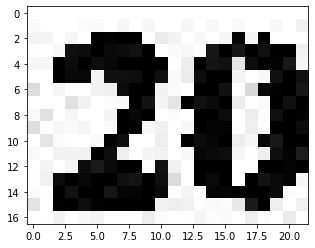

20 is valid.  adding image to subdata with corresponding name


block_number: 18
block_text: 12
block_confidence: 99.86492156982422
block_width: 0.017205029726028442
block_height: 0.048924386501312256
block_left: 0.18573680520057678
block_top: 0.26527416706085205
block_polygon: [{'X': 0.18573680520057678, 'Y': 0.26527416706085205}, {'X': 0.20294183492660522, 'Y': 0.26527416706085205}, {'X': 0.20294183492660522, 'Y': 0.3141985535621643}, {'X': 0.18573680520057678, 'Y': 0.3141985535621643}]
block_polygon_x1: 0.18573680520057678
block_polygon_y1: 0.26527416706085205
block_polygon_x2: 0.20294183492660522
block_polygon_y2: 0.26527416706085205
block_polygon_x3: 0.20294183492660522
block_polygon_y3: 0.3141985535621643
block_polygon_x4: 0.18573680520057678
block_polygon_y4: 0.3141985535621643
left_boundary: 226
right_boundary: 247
bottom_boundary: 87
top_boundary: 103


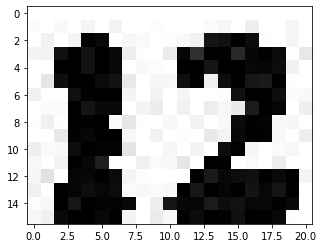

12 is valid.  adding image to subdata with corresponding name


block_number: 19
block_text: 09
block_confidence: 99.82926940917969
block_width: 0.018468603491783142
block_height: 0.048906415700912476
block_left: 0.23015578091144562
block_top: 0.26526227593421936
block_polygon: [{'X': 0.23015578091144562, 'Y': 0.26526227593421936}, {'X': 0.24862438440322876, 'Y': 0.26526227593421936}, {'X': 0.24862438440322876, 'Y': 0.31416869163513184}, {'X': 0.23015578091144562, 'Y': 0.31416869163513184}]
block_polygon_x1: 0.23015578091144562
block_polygon_y1: 0.26526227593421936
block_polygon_x2: 0.24862438440322876
block_polygon_y2: 0.26526227593421936
block_polygon_x3: 0.24862438440322876
block_polygon_y3: 0.31416869163513184
block_polygon_x4: 0.23015578091144562
block_polygon_y4: 0.31416869163513184
left_boundary: 280
right_boundary: 302
bottom_boundary: 87
top_boundary: 103


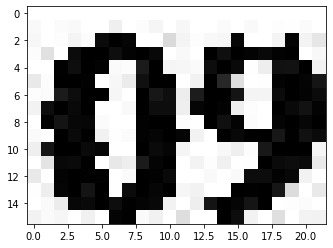

09 is valid.  adding image to subdata with corresponding name


block_number: 20
block_text: 20
block_confidence: 99.71636962890625
block_width: 0.018443703651428223
block_height: 0.04909840226173401
block_left: 0.2767729163169861
block_top: 0.2656156122684479
block_polygon: [{'X': 0.2767729163169861, 'Y': 0.2656156122684479}, {'X': 0.2952166199684143, 'Y': 0.2656156122684479}, {'X': 0.2952166199684143, 'Y': 0.3147140145301819}, {'X': 0.2767729163169861, 'Y': 0.3147140145301819}]
block_polygon_x1: 0.2767729163169861
block_polygon_y1: 0.2656156122684479
block_polygon_x2: 0.2952166199684143
block_polygon_y2: 0.2656156122684479
block_polygon_x3: 0.2952166199684143
block_polygon_y3: 0.3147140145301819
block_polygon_x4: 0.2767729163169861
block_polygon_y4: 0.3147140145301819
left_boundary: 337
right_boundary: 359
bottom_boundary: 87
top_boundary: 104


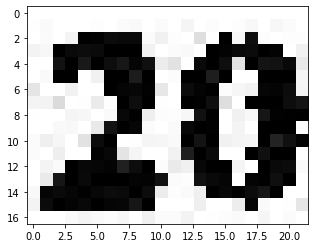

20 is valid.  adding image to subdata with corresponding name


block_number: 21
block_text: N
block_confidence: 99.4827880859375
block_width: 0.01382136344909668
block_height: 0.048759669065475464
block_left: 0.37316685914993286
block_top: 0.2643342912197113
block_polygon: [{'X': 0.37316685914993286, 'Y': 0.2643342912197113}, {'X': 0.38698822259902954, 'Y': 0.2643342912197113}, {'X': 0.38698822259902954, 'Y': 0.31309399008750916}, {'X': 0.37316685914993286, 'Y': 0.31309399008750916}]
block_polygon_x1: 0.37316685914993286
block_polygon_y1: 0.2643342912197113
block_polygon_x2: 0.38698822259902954
block_polygon_y2: 0.2643342912197113
block_polygon_x3: 0.38698822259902954
block_polygon_y3: 0.31309399008750916
block_polygon_x4: 0.37316685914993286
block_polygon_y4: 0.31309399008750916
left_boundary: 454
right_boundary: 471
bottom_boundary: 87
top_boundary: 103


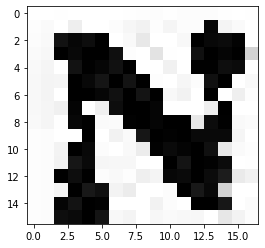

N is valid.  adding image to subdata with corresponding name


block_number: 22
block_text: 110048
block_confidence: 87.17826843261719
block_width: 0.04842713475227356
block_height: 0.051408201456069946
block_left: 0.43608587980270386
block_top: 0.2639164328575134
block_polygon: [{'X': 0.43608587980270386, 'Y': 0.2639164328575134}, {'X': 0.4845130145549774, 'Y': 0.2639164328575134}, {'X': 0.4845130145549774, 'Y': 0.3153246343135834}, {'X': 0.43608587980270386, 'Y': 0.3153246343135834}]
block_polygon_x1: 0.43608587980270386
block_polygon_y1: 0.2639164328575134
block_polygon_x2: 0.4845130145549774
block_polygon_y2: 0.2639164328575134
block_polygon_x3: 0.4845130145549774
block_polygon_y3: 0.3153246343135834
block_polygon_x4: 0.43608587980270386
block_polygon_y4: 0.3153246343135834
left_boundary: 531
right_boundary: 590
bottom_boundary: 87
top_boundary: 104


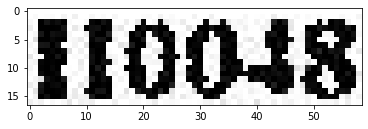

110048 is valid.  adding image to subdata with corresponding name


block_number: 23
block_text: 1
block_confidence: 98.78826904296875
block_width: 0.009123027324676514
block_height: 0.05692565441131592
block_left: 0.7145559191703796
block_top: 0.26095765829086304
block_polygon: [{'X': 0.7145559191703796, 'Y': 0.26095765829086304}, {'X': 0.7236789464950562, 'Y': 0.26095765829086304}, {'X': 0.7236789464950562, 'Y': 0.31788331270217896}, {'X': 0.7145559191703796, 'Y': 0.31788331270217896}]
block_polygon_x1: 0.7145559191703796
block_polygon_y1: 0.26095765829086304
block_polygon_x2: 0.7236789464950562
block_polygon_y2: 0.26095765829086304
block_polygon_x3: 0.7236789464950562
block_polygon_y3: 0.31788331270217896
block_polygon_x4: 0.7145559191703796
block_polygon_y4: 0.31788331270217896
left_boundary: 870
right_boundary: 881
bottom_boundary: 86
top_boundary: 105


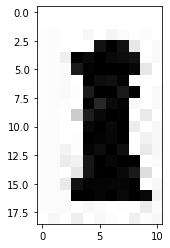

1 is valid.  adding image to subdata with corresponding name


block_number: 24
block_text: 14
block_confidence: 99.46063232421875
block_width: 0.01712554693222046
block_height: 0.049840331077575684
block_left: 0.8581909537315369
block_top: 0.26463931798934937
block_polygon: [{'X': 0.8581909537315369, 'Y': 0.26463931798934937}, {'X': 0.8753165006637573, 'Y': 0.26463931798934937}, {'X': 0.8753165006637573, 'Y': 0.31447964906692505}, {'X': 0.8581909537315369, 'Y': 0.31447964906692505}]
block_polygon_x1: 0.8581909537315369
block_polygon_y1: 0.26463931798934937
block_polygon_x2: 0.8753165006637573
block_polygon_y2: 0.26463931798934937
block_polygon_x3: 0.8753165006637573
block_polygon_y3: 0.31447964906692505
block_polygon_x4: 0.8581909537315369
block_polygon_y4: 0.31447964906692505
left_boundary: 1045
right_boundary: 1066
bottom_boundary: 87
top_boundary: 104


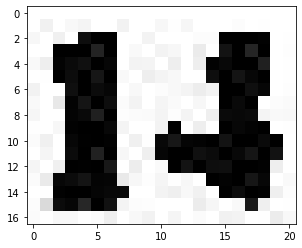

14 is valid.  adding image to subdata with corresponding name


block_number: 25
block_text: 48
block_confidence: 99.26620483398438
block_width: 0.01805657148361206
block_height: 0.04965245723724365
block_left: 0.898045539855957
block_top: 0.2645823061466217
block_polygon: [{'X': 0.898045539855957, 'Y': 0.2645823061466217}, {'X': 0.9161021113395691, 'Y': 0.2645823061466217}, {'X': 0.9161021113395691, 'Y': 0.31423476338386536}, {'X': 0.898045539855957, 'Y': 0.31423476338386536}]
block_polygon_x1: 0.898045539855957
block_polygon_y1: 0.2645823061466217
block_polygon_x2: 0.9161021113395691
block_polygon_y2: 0.2645823061466217
block_polygon_x3: 0.9161021113395691
block_polygon_y3: 0.31423476338386536
block_polygon_x4: 0.898045539855957
block_polygon_y4: 0.31423476338386536
left_boundary: 1093
right_boundary: 1115
bottom_boundary: 87
top_boundary: 104


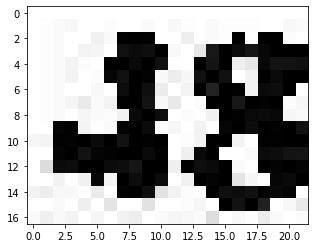

48 is valid.  adding image to subdata with corresponding name


block_number: 26
block_text: 1.00
block_confidence: 99.45489501953125
block_width: 0.03031212091445923
block_height: 0.05004081130027771
block_left: 0.9322333335876465
block_top: 0.26496610045433044
block_polygon: [{'X': 0.9322333335876465, 'Y': 0.26496610045433044}, {'X': 0.9625454545021057, 'Y': 0.26496610045433044}, {'X': 0.9625454545021057, 'Y': 0.31500688195228577}, {'X': 0.9322333335876465, 'Y': 0.31500688195228577}]
block_polygon_x1: 0.9322333335876465
block_polygon_y1: 0.26496610045433044
block_polygon_x2: 0.9625454545021057
block_polygon_y2: 0.26496610045433044
block_polygon_x3: 0.9625454545021057
block_polygon_y3: 0.31500688195228577
block_polygon_x4: 0.9322333335876465
block_polygon_y4: 0.31500688195228577
left_boundary: 1135
right_boundary: 1172
bottom_boundary: 87
top_boundary: 104


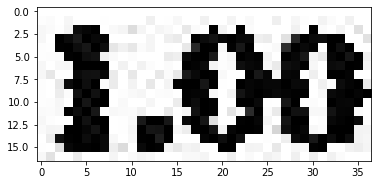



block_number: 27
block_text: 3
block_confidence: 99.7282943725586
block_width: 0.011070415377616882
block_height: 0.06010589003562927
block_left: 0.02600126713514328
block_top: 0.3899514973163605
block_polygon: [{'X': 0.02600126713514328, 'Y': 0.3899514973163605}, {'X': 0.03707168251276016, 'Y': 0.3899514973163605}, {'X': 0.03707168251276016, 'Y': 0.45005738735198975}, {'X': 0.02600126713514328, 'Y': 0.45005738735198975}]
block_polygon_x1: 0.02600126713514328
block_polygon_y1: 0.3899514973163605
block_polygon_x2: 0.03707168251276016
block_polygon_y2: 0.3899514973163605
block_polygon_x3: 0.03707168251276016
block_polygon_y3: 0.45005738735198975
block_polygon_x4: 0.02600126713514328
block_polygon_y4: 0.45005738735198975
left_boundary: 31
right_boundary: 45
bottom_boundary: 129
top_boundary: 148


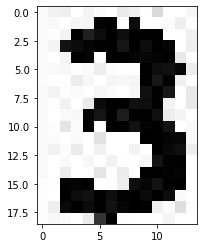

3 is valid.  adding image to subdata with corresponding name


block_number: 28
block_text: 4
block_confidence: 99.1146011352539
block_width: 0.012498456984758377
block_height: 0.06008034944534302
block_left: 0.026122387498617172
block_top: 0.5547935962677002
block_polygon: [{'X': 0.026122387498617172, 'Y': 0.5547935962677002}, {'X': 0.03862084448337555, 'Y': 0.5547935962677002}, {'X': 0.03862084448337555, 'Y': 0.614874005317688}, {'X': 0.026122387498617172, 'Y': 0.614874005317688}]
block_polygon_x1: 0.026122387498617172
block_polygon_y1: 0.5547935962677002
block_polygon_x2: 0.03862084448337555
block_polygon_y2: 0.5547935962677002
block_polygon_x3: 0.03862084448337555
block_polygon_y3: 0.614874005317688
block_polygon_x4: 0.026122387498617172
block_polygon_y4: 0.614874005317688
left_boundary: 31
right_boundary: 47
bottom_boundary: 183
top_boundary: 203


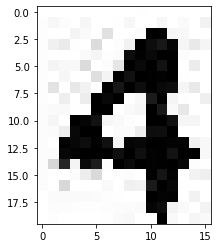

4 is valid.  adding image to subdata with corresponding name


block_number: 29
block_text: 5
block_confidence: 99.41886138916016
block_width: 0.011632081121206284
block_height: 0.06226491928100586
block_left: 0.026615004986524582
block_top: 0.7305779457092285
block_polygon: [{'X': 0.026615004986524582, 'Y': 0.7305779457092285}, {'X': 0.038247086107730865, 'Y': 0.7305779457092285}, {'X': 0.038247086107730865, 'Y': 0.7928428649902344}, {'X': 0.026615004986524582, 'Y': 0.7928428649902344}]
block_polygon_x1: 0.026615004986524582
block_polygon_y1: 0.7305779457092285
block_polygon_x2: 0.038247086107730865
block_polygon_y2: 0.7305779457092285
block_polygon_x3: 0.038247086107730865
block_polygon_y3: 0.7928428649902344
block_polygon_x4: 0.026615004986524582
block_polygon_y4: 0.7928428649902344
left_boundary: 32
right_boundary: 46
bottom_boundary: 241
top_boundary: 262


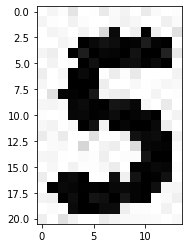

5 is valid.  adding image to subdata with corresponding name


block_number: 30
block_text: 6
block_confidence: 99.86483764648438
block_width: 0.012339945882558823
block_height: 0.05755525827407837
block_left: 0.026324424892663956
block_top: 0.905708372592926
block_polygon: [{'X': 0.026324424892663956, 'Y': 0.905708372592926}, {'X': 0.03866437077522278, 'Y': 0.905708372592926}, {'X': 0.03866437077522278, 'Y': 0.9632636308670044}, {'X': 0.026324424892663956, 'Y': 0.9632636308670044}]
block_polygon_x1: 0.026324424892663956
block_polygon_y1: 0.905708372592926
block_polygon_x2: 0.03866437077522278
block_polygon_y2: 0.905708372592926
block_polygon_x3: 0.03866437077522278
block_polygon_y3: 0.9632636308670044
block_polygon_x4: 0.026324424892663956
block_polygon_y4: 0.9632636308670044
left_boundary: 32
right_boundary: 47
bottom_boundary: 299
top_boundary: 318


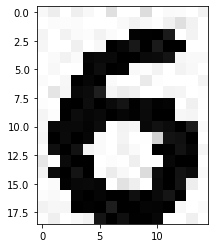

6 is valid.  adding image to subdata with corresponding name


block_number: 31
block_text: I
block_confidence: 77.9361343383789
block_width: 0.006128191947937012
block_height: 0.07759267091751099
block_left: 0.7856528759002686
block_top: 0.9208967089653015
block_polygon: [{'X': 0.7856528759002686, 'Y': 0.9208967089653015}, {'X': 0.7917810678482056, 'Y': 0.9208967089653015}, {'X': 0.7917810678482056, 'Y': 0.9984893798828125}, {'X': 0.7856528759002686, 'Y': 0.9984893798828125}]
block_polygon_x1: 0.7856528759002686
block_polygon_y1: 0.9208967089653015
block_polygon_x2: 0.7917810678482056
block_polygon_y2: 0.9208967089653015
block_polygon_x3: 0.7917810678482056
block_polygon_y3: 0.9984893798828125
block_polygon_x4: 0.7856528759002686
block_polygon_y4: 0.9984893798828125
left_boundary: 956
right_boundary: 964
bottom_boundary: 304
top_boundary: 330


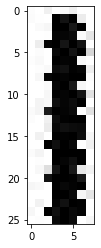

I is valid.  adding image to subdata with corresponding name


filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage4.jpeg
json_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage4.json


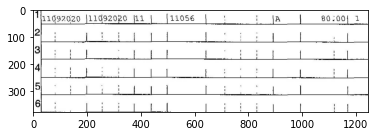

block_number: 1
block_text: 1
block_confidence: 87.19756317138672
block_width: 0.011432262137532234
block_height: 0.07549625635147095
block_left: 0.006261997390538454
block_top: 0.007341647055000067
block_polygon: [{'X': 0.006261997390538454, 'Y': 0.007341647055000067}, {'X': 0.0176942590624094, 'Y': 0.007341647055000067}, {'X': 0.0176942590624094, 'Y': 0.08283790946006775}, {'X': 0.006261997390538454, 'Y': 0.08283790946006775}]
block_polygon_x1: 0.006261997390538454
block_polygon_y1: 0.007341647055000067
block_polygon_x2: 0.0176942590624094
block_polygon_y2: 0.007341647055000067
block_polygon_x3: 0.0176942590624094
block_polygon_y3: 0.08283790946006775
block_polygon_x4: 0.006261997390538454
block_polygon_y4: 0.08283790946006775
left_boundary: 7
right_boundary: 22
bottom_boundary: 2
top_boundary: 31


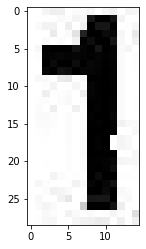

1 is valid.  adding image to subdata with corresponding name


block_number: 2
block_text: 11092020
block_confidence: 93.77307891845703
block_width: 0.10917685180902481
block_height: 0.06888999044895172
block_left: 0.031295839697122574
block_top: 0.049898941069841385
block_polygon: [{'X': 0.031295839697122574, 'Y': 0.049898941069841385}, {'X': 0.14047269523143768, 'Y': 0.049898941069841385}, {'X': 0.14047269523143768, 'Y': 0.11878892779350281}, {'X': 0.031295839697122574, 'Y': 0.11878892779350281}]
block_polygon_x1: 0.031295839697122574
block_polygon_y1: 0.049898941069841385
block_polygon_x2: 0.14047269523143768
block_polygon_y2: 0.049898941069841385
block_polygon_x3: 0.14047269523143768
block_polygon_y3: 0.11878892779350281
block_polygon_x4: 0.031295839697122574
block_polygon_y4: 0.11878892779350281
left_boundary: 38
right_boundary: 174
bottom_boundary: 18
top_boundary: 44


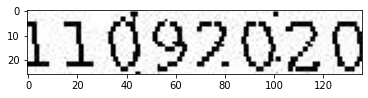

11092020 is valid.  adding image to subdata with corresponding name


block_number: 3
block_text: 11092020 1 1
block_confidence: 94.09996032714844
block_width: 0.16419976949691772
block_height: 0.088602215051651
block_left: 0.16726113855838776
block_top: 0.042005863040685654
block_polygon: [{'X': 0.16726113855838776, 'Y': 0.042005863040685654}, {'X': 0.3314608931541443, 'Y': 0.042005863040685654}, {'X': 0.3314608931541443, 'Y': 0.13060808181762695}, {'X': 0.16726113855838776, 'Y': 0.13060808181762695}]
block_polygon_x1: 0.16726113855838776
block_polygon_y1: 0.042005863040685654
block_polygon_x2: 0.3314608931541443
block_polygon_y2: 0.042005863040685654
block_polygon_x3: 0.3314608931541443
block_polygon_y3: 0.13060808181762695
block_polygon_x4: 0.16726113855838776
block_polygon_y4: 0.13060808181762695
left_boundary: 208
right_boundary: 412
bottom_boundary: 15
top_boundary: 49


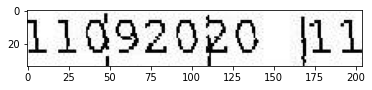

11092020 1 1 is valid.  adding image to subdata with corresponding name


block_number: 4
block_text: 11056
block_confidence: 99.60649871826172
block_width: 0.07337701320648193
block_height: 0.060885217040777206
block_left: 0.40873485803604126
block_top: 0.04891866818070412
block_polygon: [{'X': 0.40873485803604126, 'Y': 0.04891866818070412}, {'X': 0.4821118712425232, 'Y': 0.04891866818070412}, {'X': 0.4821118712425232, 'Y': 0.10980388522148132}, {'X': 0.40873485803604126, 'Y': 0.10980388522148132}]
block_polygon_x1: 0.40873485803604126
block_polygon_y1: 0.04891866818070412
block_polygon_x2: 0.4821118712425232
block_polygon_y2: 0.04891866818070412
block_polygon_x3: 0.4821118712425232
block_polygon_y3: 0.10980388522148132
block_polygon_x4: 0.40873485803604126
block_polygon_y4: 0.10980388522148132
left_boundary: 508
right_boundary: 600
bottom_boundary: 18
top_boundary: 41


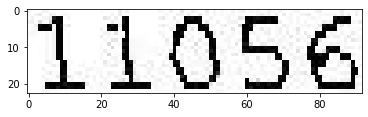

11056 is valid.  adding image to subdata with corresponding name


block_number: 5
block_text: A
block_confidence: 99.70378112792969
block_width: 0.016474902629852295
block_height: 0.05419562757015228
block_left: 0.722213089466095
block_top: 0.06001406908035278
block_polygon: [{'X': 0.722213089466095, 'Y': 0.06001406908035278}, {'X': 0.7386879920959473, 'Y': 0.06001406908035278}, {'X': 0.7386879920959473, 'Y': 0.11420969665050507}, {'X': 0.722213089466095, 'Y': 0.11420969665050507}]
block_polygon_x1: 0.722213089466095
block_polygon_y1: 0.06001406908035278
block_polygon_x2: 0.7386879920959473
block_polygon_y2: 0.06001406908035278
block_polygon_x3: 0.7386879920959473
block_polygon_y3: 0.11420969665050507
block_polygon_x4: 0.722213089466095
block_polygon_y4: 0.11420969665050507
left_boundary: 899
right_boundary: 919
bottom_boundary: 22
top_boundary: 43


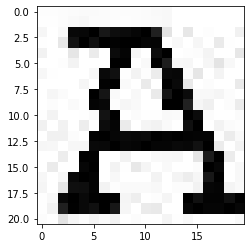

A is valid.  adding image to subdata with corresponding name


block_number: 6
block_text: 80:00 1
block_confidence: 86.58715057373047
block_width: 0.1139797493815422
block_height: 0.06801168620586395
block_left: 0.85997474193573
block_top: 0.04982851818203926
block_polygon: [{'X': 0.85997474193573, 'Y': 0.04982851818203926}, {'X': 0.9739544987678528, 'Y': 0.04982851818203926}, {'X': 0.9739544987678528, 'Y': 0.11784020811319351}, {'X': 0.85997474193573, 'Y': 0.11784020811319351}]
block_polygon_x1: 0.85997474193573
block_polygon_y1: 0.04982851818203926
block_polygon_x2: 0.9739544987678528
block_polygon_y2: 0.04982851818203926
block_polygon_x3: 0.9739544987678528
block_polygon_y3: 0.11784020811319351
block_polygon_x4: 0.85997474193573
block_polygon_y4: 0.11784020811319351
left_boundary: 1070
right_boundary: 1212
bottom_boundary: 18
top_boundary: 44


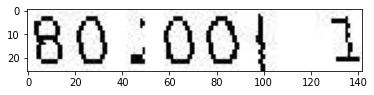



block_number: 7
block_text: 2
block_confidence: 99.38465118408203
block_width: 0.017890531569719315
block_height: 0.07279706001281738
block_left: 0.003905221354216337
block_top: 0.18015533685684204
block_polygon: [{'X': 0.003905221354216337, 'Y': 0.18015533685684204}, {'X': 0.02179575338959694, 'Y': 0.18015533685684204}, {'X': 0.02179575338959694, 'Y': 0.2529523968696594}, {'X': 0.003905221354216337, 'Y': 0.2529523968696594}]
block_polygon_x1: 0.003905221354216337
block_polygon_y1: 0.18015533685684204
block_polygon_x2: 0.02179575338959694
block_polygon_y2: 0.18015533685684204
block_polygon_x3: 0.02179575338959694
block_polygon_y3: 0.2529523968696594
block_polygon_x4: 0.003905221354216337
block_polygon_y4: 0.2529523968696594
left_boundary: 4
right_boundary: 27
bottom_boundary: 68
top_boundary: 95


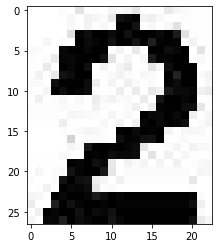

2 is valid.  adding image to subdata with corresponding name


block_number: 8
block_text: 3
block_confidence: 99.6978759765625
block_width: 0.017139263451099396
block_height: 0.07646921277046204
block_left: 0.004612529184669256
block_top: 0.35178783535957336
block_polygon: [{'X': 0.004612529184669256, 'Y': 0.35178783535957336}, {'X': 0.02175179123878479, 'Y': 0.35178783535957336}, {'X': 0.02175179123878479, 'Y': 0.4282570481300354}, {'X': 0.004612529184669256, 'Y': 0.4282570481300354}]
block_polygon_x1: 0.004612529184669256
block_polygon_y1: 0.35178783535957336
block_polygon_x2: 0.02175179123878479
block_polygon_y2: 0.35178783535957336
block_polygon_x3: 0.02175179123878479
block_polygon_y3: 0.4282570481300354
block_polygon_x4: 0.004612529184669256
block_polygon_y4: 0.4282570481300354
left_boundary: 5
right_boundary: 27
bottom_boundary: 132
top_boundary: 161


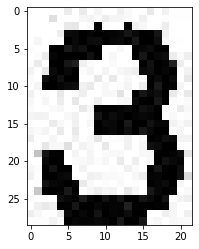

3 is valid.  adding image to subdata with corresponding name


block_number: 9
block_text: 4
block_confidence: 99.79137420654297
block_width: 0.016748540103435516
block_height: 0.08185452222824097
block_left: 0.0050923763774335384
block_top: 0.5229070782661438
block_polygon: [{'X': 0.0050923763774335384, 'Y': 0.5229070782661438}, {'X': 0.021840916946530342, 'Y': 0.5229070782661438}, {'X': 0.021840916946530342, 'Y': 0.6047616004943848}, {'X': 0.0050923763774335384, 'Y': 0.6047616004943848}]
block_polygon_x1: 0.0050923763774335384
block_polygon_y1: 0.5229070782661438
block_polygon_x2: 0.021840916946530342
block_polygon_y2: 0.5229070782661438
block_polygon_x3: 0.021840916946530342
block_polygon_y3: 0.6047616004943848
block_polygon_x4: 0.0050923763774335384
block_polygon_y4: 0.6047616004943848
left_boundary: 6
right_boundary: 27
bottom_boundary: 197
top_boundary: 228


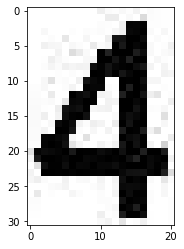

4 is valid.  adding image to subdata with corresponding name


block_number: 10
block_text: 5
block_confidence: 99.301513671875
block_width: 0.016723157837986946
block_height: 0.07285481691360474
block_left: 0.005646095145493746
block_top: 0.7107526063919067
block_polygon: [{'X': 0.005646095145493746, 'Y': 0.7107526063919067}, {'X': 0.022369252517819405, 'Y': 0.7107526063919067}, {'X': 0.022369252517819405, 'Y': 0.7836074233055115}, {'X': 0.005646095145493746, 'Y': 0.7836074233055115}]
block_polygon_x1: 0.005646095145493746
block_polygon_y1: 0.7107526063919067
block_polygon_x2: 0.022369252517819405
block_polygon_y2: 0.7107526063919067
block_polygon_x3: 0.022369252517819405
block_polygon_y3: 0.7836074233055115
block_polygon_x4: 0.005646095145493746
block_polygon_y4: 0.7836074233055115
left_boundary: 7
right_boundary: 27
bottom_boundary: 268
top_boundary: 296


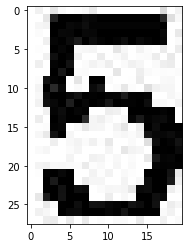

5 is valid.  adding image to subdata with corresponding name


block_number: 11
block_text: 6
block_confidence: 99.29652404785156
block_width: 0.01748460717499256
block_height: 0.07678884267807007
block_left: 0.005948713514953852
block_top: 0.8773812651634216
block_polygon: [{'X': 0.005948713514953852, 'Y': 0.8773812651634216}, {'X': 0.023433320224285126, 'Y': 0.8773812651634216}, {'X': 0.023433320224285126, 'Y': 0.9541701078414917}, {'X': 0.005948713514953852, 'Y': 0.9541701078414917}]
block_polygon_x1: 0.005948713514953852
block_polygon_y1: 0.8773812651634216
block_polygon_x2: 0.023433320224285126
block_polygon_y2: 0.8773812651634216
block_polygon_x3: 0.023433320224285126
block_polygon_y3: 0.9541701078414917
block_polygon_x4: 0.005948713514953852
block_polygon_y4: 0.9541701078414917
left_boundary: 7
right_boundary: 29
bottom_boundary: 331
top_boundary: 360


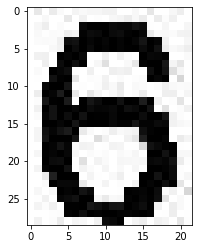

6 is valid.  adding image to subdata with corresponding name


filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage5.jpeg
json_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/testimage5.json


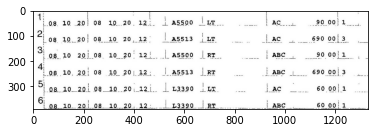

block_number: 1
block_text: 08. 10 20
block_confidence: 81.10911560058594
block_width: 0.10930992662906647
block_height: 0.06098372861742973
block_left: 0.04610957205295563
block_top: 0.10565091669559479
block_polygon: [{'X': 0.04610957205295563, 'Y': 0.10565091669559479}, {'X': 0.1554194986820221, 'Y': 0.10565091669559479}, {'X': 0.1554194986820221, 'Y': 0.16663464903831482}, {'X': 0.04610957205295563, 'Y': 0.16663464903831482}]
block_polygon_x1: 0.04610957205295563
block_polygon_y1: 0.10565091669559479
block_polygon_x2: 0.1554194986820221
block_polygon_y2: 0.10565091669559479
block_polygon_x3: 0.1554194986820221
block_polygon_y3: 0.16663464903831482
block_polygon_x4: 0.04610957205295563
block_polygon_y4: 0.16663464903831482
left_boundary: 61
right_boundary: 206
bottom_boundary: 41
top_boundary: 64


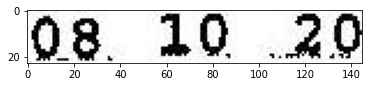



block_number: 2
block_text: 08
block_confidence: 99.27503967285156
block_width: 0.022593393921852112
block_height: 0.05196670442819595
block_left: 0.18071050941944122
block_top: 0.10477419942617416
block_polygon: [{'X': 0.18071050941944122, 'Y': 0.10477419942617416}, {'X': 0.20330390334129333, 'Y': 0.10477419942617416}, {'X': 0.20330390334129333, 'Y': 0.15674090385437012}, {'X': 0.18071050941944122, 'Y': 0.15674090385437012}]
block_polygon_x1: 0.18071050941944122
block_polygon_y1: 0.10477419942617416
block_polygon_x2: 0.20330390334129333
block_polygon_y2: 0.10477419942617416
block_polygon_x3: 0.20330390334129333
block_polygon_y3: 0.15674090385437012
block_polygon_x4: 0.18071050941944122
block_polygon_y4: 0.15674090385437012
left_boundary: 240
right_boundary: 270
bottom_boundary: 40
top_boundary: 61


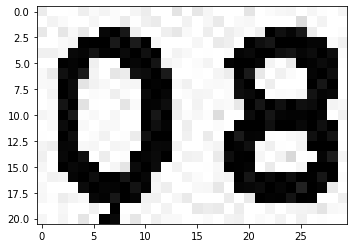

08 is valid.  adding image to subdata with corresponding name


block_number: 3
block_text: 10
block_confidence: 99.5618667602539
block_width: 0.02291250228881836
block_height: 0.05015917867422104
block_left: 0.22590655088424683
block_top: 0.10446170717477798
block_polygon: [{'X': 0.22590655088424683, 'Y': 0.10446170717477798}, {'X': 0.24881905317306519, 'Y': 0.10446170717477798}, {'X': 0.24881905317306519, 'Y': 0.15462088584899902}, {'X': 0.22590655088424683, 'Y': 0.15462088584899902}]
block_polygon_x1: 0.22590655088424683
block_polygon_y1: 0.10446170717477798
block_polygon_x2: 0.24881905317306519
block_polygon_y2: 0.10446170717477798
block_polygon_x3: 0.24881905317306519
block_polygon_y3: 0.15462088584899902
block_polygon_x4: 0.22590655088424683
block_polygon_y4: 0.15462088584899902
left_boundary: 300
right_boundary: 330
bottom_boundary: 40
top_boundary: 60


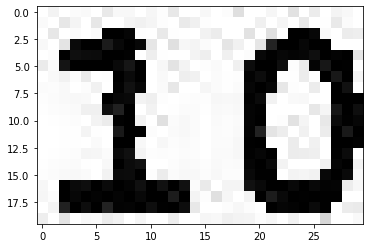

10 is valid.  adding image to subdata with corresponding name


block_number: 4
block_text: 20
block_confidence: 99.61729431152344
block_width: 0.022832870483398438
block_height: 0.050936855375766754
block_left: 0.2689025402069092
block_top: 0.1039757952094078
block_polygon: [{'X': 0.2689025402069092, 'Y': 0.1039757952094078}, {'X': 0.2917354106903076, 'Y': 0.1039757952094078}, {'X': 0.2917354106903076, 'Y': 0.15491265058517456}, {'X': 0.2689025402069092, 'Y': 0.15491265058517456}]
block_polygon_x1: 0.2689025402069092
block_polygon_y1: 0.1039757952094078
block_polygon_x2: 0.2917354106903076
block_polygon_y2: 0.1039757952094078
block_polygon_x3: 0.2917354106903076
block_polygon_y3: 0.15491265058517456
block_polygon_x4: 0.2689025402069092
block_polygon_y4: 0.15491265058517456
left_boundary: 357
right_boundary: 388
bottom_boundary: 40
top_boundary: 60


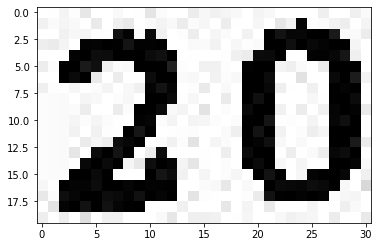

20 is valid.  adding image to subdata with corresponding name


block_number: 5
block_text: 12
block_confidence: 99.491943359375
block_width: 0.02457377314567566
block_height: 0.05081138014793396
block_left: 0.3157758116722107
block_top: 0.10184365510940552
block_polygon: [{'X': 0.3157758116722107, 'Y': 0.10184365510940552}, {'X': 0.34034958481788635, 'Y': 0.10184365510940552}, {'X': 0.34034958481788635, 'Y': 0.15265503525733948}, {'X': 0.3157758116722107, 'Y': 0.15265503525733948}]
block_polygon_x1: 0.3157758116722107
block_polygon_y1: 0.10184365510940552
block_polygon_x2: 0.34034958481788635
block_polygon_y2: 0.10184365510940552
block_polygon_x3: 0.34034958481788635
block_polygon_y3: 0.15265503525733948
block_polygon_x4: 0.3157758116722107
block_polygon_y4: 0.15265503525733948
left_boundary: 419
right_boundary: 452
bottom_boundary: 39
top_boundary: 59


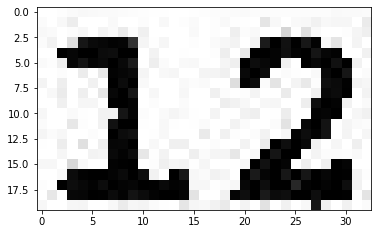

12 is valid.  adding image to subdata with corresponding name


block_number: 6
block_text: A5500
block_confidence: 99.50599670410156
block_width: 0.06521740555763245
block_height: 0.05243537575006485
block_left: 0.4131225645542145
block_top: 0.10063018649816513
block_polygon: [{'X': 0.4131225645542145, 'Y': 0.10063018649816513}, {'X': 0.4783399701118469, 'Y': 0.10063018649816513}, {'X': 0.4783399701118469, 'Y': 0.15306556224822998}, {'X': 0.4131225645542145, 'Y': 0.15306556224822998}]
block_polygon_x1: 0.4131225645542145
block_polygon_y1: 0.10063018649816513
block_polygon_x2: 0.4783399701118469
block_polygon_y2: 0.10063018649816513
block_polygon_x3: 0.4783399701118469
block_polygon_y3: 0.15306556224822998
block_polygon_x4: 0.4131225645542145
block_polygon_y4: 0.15306556224822998
left_boundary: 549
right_boundary: 636
bottom_boundary: 39
top_boundary: 59


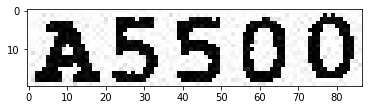

A5500 is valid.  adding image to subdata with corresponding name


block_number: 7
block_text: LT
block_confidence: 99.8839111328125
block_width: 0.025420546531677246
block_height: 0.0504792183637619
block_left: 0.5187447667121887
block_top: 0.10128386318683624
block_polygon: [{'X': 0.5187447667121887, 'Y': 0.10128386318683624}, {'X': 0.544165313243866, 'Y': 0.10128386318683624}, {'X': 0.544165313243866, 'Y': 0.15176308155059814}, {'X': 0.5187447667121887, 'Y': 0.15176308155059814}]
block_polygon_x1: 0.5187447667121887
block_polygon_y1: 0.10128386318683624
block_polygon_x2: 0.544165313243866
block_polygon_y2: 0.10128386318683624
block_polygon_x3: 0.544165313243866
block_polygon_y3: 0.15176308155059814
block_polygon_x4: 0.5187447667121887
block_polygon_y4: 0.15176308155059814
left_boundary: 689
right_boundary: 723
bottom_boundary: 39
top_boundary: 59


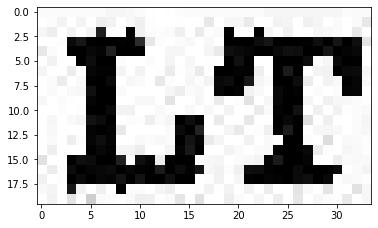

LT is valid.  adding image to subdata with corresponding name


block_number: 8
block_text: AC
block_confidence: 99.85014343261719
block_width: 0.02679508924484253
block_height: 0.0496678352355957
block_left: 0.7132515907287598
block_top: 0.10136792063713074
block_polygon: [{'X': 0.7132515907287598, 'Y': 0.10136792063713074}, {'X': 0.7400466799736023, 'Y': 0.10136792063713074}, {'X': 0.7400466799736023, 'Y': 0.15103575587272644}, {'X': 0.7132515907287598, 'Y': 0.15103575587272644}]
block_polygon_x1: 0.7132515907287598
block_polygon_y1: 0.10136792063713074
block_polygon_x2: 0.7400466799736023
block_polygon_y2: 0.10136792063713074
block_polygon_x3: 0.7400466799736023
block_polygon_y3: 0.15103575587272644
block_polygon_x4: 0.7132515907287598
block_polygon_y4: 0.15103575587272644
left_boundary: 948
right_boundary: 984
bottom_boundary: 39
top_boundary: 58


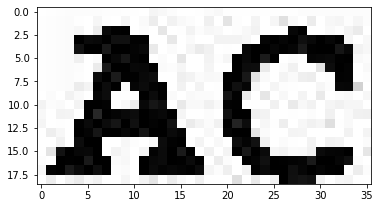

AC is valid.  adding image to subdata with corresponding name


block_number: 9
block_text: 90 00
block_confidence: 90.91691589355469
block_width: 0.05900293588638306
block_height: 0.058024369180202484
block_left: 0.8449582457542419
block_top: 0.09385371953248978
block_polygon: [{'X': 0.8449582457542419, 'Y': 0.09385371953248978}, {'X': 0.903961181640625, 'Y': 0.09385371953248978}, {'X': 0.903961181640625, 'Y': 0.15187808871269226}, {'X': 0.8449582457542419, 'Y': 0.15187808871269226}]
block_polygon_x1: 0.8449582457542419
block_polygon_y1: 0.09385371953248978
block_polygon_x2: 0.903961181640625
block_polygon_y2: 0.09385371953248978
block_polygon_x3: 0.903961181640625
block_polygon_y3: 0.15187808871269226
block_polygon_x4: 0.8449582457542419
block_polygon_y4: 0.15187808871269226
left_boundary: 1123
right_boundary: 1202
bottom_boundary: 36
top_boundary: 59


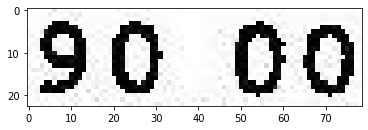

90 00 is valid.  adding image to subdata with corresponding name


block_number: 10
block_text: 1
block_confidence: 99.6928482055664
block_width: 0.011285006999969482
block_height: 0.05117201805114746
block_left: 0.921653151512146
block_top: 0.09730592370033264
block_polygon: [{'X': 0.921653151512146, 'Y': 0.09730592370033264}, {'X': 0.9329381585121155, 'Y': 0.09730592370033264}, {'X': 0.9329381585121155, 'Y': 0.1484779417514801}, {'X': 0.921653151512146, 'Y': 0.1484779417514801}]
block_polygon_x1: 0.921653151512146
block_polygon_y1: 0.09730592370033264
block_polygon_x2: 0.9329381585121155
block_polygon_y2: 0.09730592370033264
block_polygon_x3: 0.9329381585121155
block_polygon_y3: 0.1484779417514801
block_polygon_x4: 0.921653151512146
block_polygon_y4: 0.1484779417514801
left_boundary: 1225
right_boundary: 1240
bottom_boundary: 37
top_boundary: 57


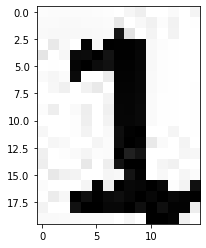

1 is valid.  adding image to subdata with corresponding name


block_number: 11
block_text: 08 10 20
block_confidence: 99.37003326416016
block_width: 0.10946941375732422
block_height: 0.05770564079284668
block_left: 0.046119511127471924
block_top: 0.2700539529323578
block_polygon: [{'X': 0.046119511127471924, 'Y': 0.2700539529323578}, {'X': 0.15558892488479614, 'Y': 0.2700539529323578}, {'X': 0.15558892488479614, 'Y': 0.32775959372520447}, {'X': 0.046119511127471924, 'Y': 0.32775959372520447}]
block_polygon_x1: 0.046119511127471924
block_polygon_y1: 0.2700539529323578
block_polygon_x2: 0.15558892488479614
block_polygon_y2: 0.2700539529323578
block_polygon_x3: 0.15558892488479614
block_polygon_y3: 0.32775959372520447
block_polygon_x4: 0.046119511127471924
block_polygon_y4: 0.32775959372520447
left_boundary: 61
right_boundary: 206
bottom_boundary: 105
top_boundary: 127


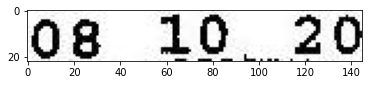

08 10 20 is valid.  adding image to subdata with corresponding name


block_number: 12
block_text: 08
block_confidence: 99.16838073730469
block_width: 0.022400781512260437
block_height: 0.05191674828529358
block_left: 0.18100479245185852
block_top: 0.26947125792503357
block_polygon: [{'X': 0.18100479245185852, 'Y': 0.26947125792503357}, {'X': 0.20340557396411896, 'Y': 0.26947125792503357}, {'X': 0.20340557396411896, 'Y': 0.32138800621032715}, {'X': 0.18100479245185852, 'Y': 0.32138800621032715}]
block_polygon_x1: 0.18100479245185852
block_polygon_y1: 0.26947125792503357
block_polygon_x2: 0.20340557396411896
block_polygon_y2: 0.26947125792503357
block_polygon_x3: 0.20340557396411896
block_polygon_y3: 0.32138800621032715
block_polygon_x4: 0.18100479245185852
block_polygon_y4: 0.32138800621032715
left_boundary: 240
right_boundary: 270
bottom_boundary: 105
top_boundary: 125


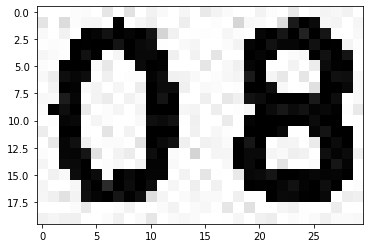

08 is valid.  adding image to subdata with corresponding name


block_number: 13
block_text: 10
block_confidence: 99.12447357177734
block_width: 0.022344142198562622
block_height: 0.04880562424659729
block_left: 0.22649499773979187
block_top: 0.26956799626350403
block_polygon: [{'X': 0.22649499773979187, 'Y': 0.26956799626350403}, {'X': 0.2488391399383545, 'Y': 0.26956799626350403}, {'X': 0.2488391399383545, 'Y': 0.3183736205101013}, {'X': 0.22649499773979187, 'Y': 0.3183736205101013}]
block_polygon_x1: 0.22649499773979187
block_polygon_y1: 0.26956799626350403
block_polygon_x2: 0.2488391399383545
block_polygon_y2: 0.26956799626350403
block_polygon_x3: 0.2488391399383545
block_polygon_y3: 0.3183736205101013
block_polygon_x4: 0.22649499773979187
block_polygon_y4: 0.3183736205101013
left_boundary: 301
right_boundary: 330
bottom_boundary: 105
top_boundary: 124


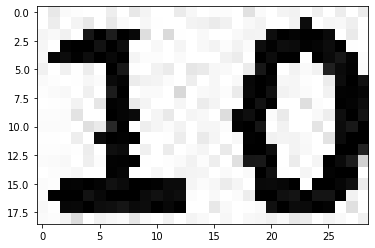

10 is valid.  adding image to subdata with corresponding name


block_number: 14
block_text: 20
block_confidence: 99.52392578125
block_width: 0.024164587259292603
block_height: 0.04855373501777649
block_left: 0.2688780426979065
block_top: 0.269717812538147
block_polygon: [{'X': 0.2688780426979065, 'Y': 0.269717812538147}, {'X': 0.2930426299571991, 'Y': 0.269717812538147}, {'X': 0.2930426299571991, 'Y': 0.31827154755592346}, {'X': 0.2688780426979065, 'Y': 0.31827154755592346}]
block_polygon_x1: 0.2688780426979065
block_polygon_y1: 0.269717812538147
block_polygon_x2: 0.2930426299571991
block_polygon_y2: 0.269717812538147
block_polygon_x3: 0.2930426299571991
block_polygon_y3: 0.31827154755592346
block_polygon_x4: 0.2688780426979065
block_polygon_y4: 0.31827154755592346
left_boundary: 357
right_boundary: 389
bottom_boundary: 105
top_boundary: 124


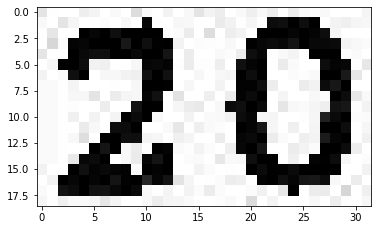

20 is valid.  adding image to subdata with corresponding name


block_number: 15
block_text: 12
block_confidence: 99.28718566894531
block_width: 0.023390233516693115
block_height: 0.04776504635810852
block_left: 0.3160565495491028
block_top: 0.2696540057659149
block_polygon: [{'X': 0.3160565495491028, 'Y': 0.2696540057659149}, {'X': 0.3394467830657959, 'Y': 0.2696540057659149}, {'X': 0.3394467830657959, 'Y': 0.31741905212402344}, {'X': 0.3160565495491028, 'Y': 0.31741905212402344}]
block_polygon_x1: 0.3160565495491028
block_polygon_y1: 0.2696540057659149
block_polygon_x2: 0.3394467830657959
block_polygon_y2: 0.2696540057659149
block_polygon_x3: 0.3394467830657959
block_polygon_y3: 0.31741905212402344
block_polygon_x4: 0.3160565495491028
block_polygon_y4: 0.31741905212402344
left_boundary: 420
right_boundary: 451
bottom_boundary: 105
top_boundary: 123


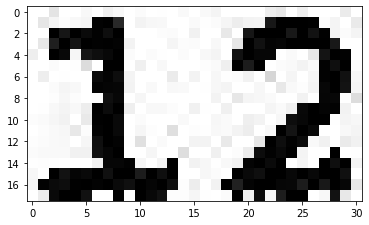

12 is valid.  adding image to subdata with corresponding name


block_number: 16
block_text: A5513
block_confidence: 99.22772979736328
block_width: 0.06423184275627136
block_height: 0.05182114243507385
block_left: 0.4132792353630066
block_top: 0.26657918095588684
block_polygon: [{'X': 0.4132792353630066, 'Y': 0.26657918095588684}, {'X': 0.47751107811927795, 'Y': 0.26657918095588684}, {'X': 0.47751107811927795, 'Y': 0.3184003233909607}, {'X': 0.4132792353630066, 'Y': 0.3184003233909607}]
block_polygon_x1: 0.4132792353630066
block_polygon_y1: 0.26657918095588684
block_polygon_x2: 0.47751107811927795
block_polygon_y2: 0.26657918095588684
block_polygon_x3: 0.47751107811927795
block_polygon_y3: 0.3184003233909607
block_polygon_x4: 0.4132792353630066
block_polygon_y4: 0.3184003233909607
left_boundary: 549
right_boundary: 635
bottom_boundary: 103
top_boundary: 124


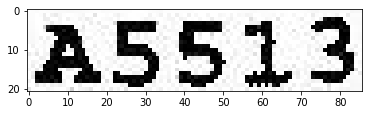

A5513 is valid.  adding image to subdata with corresponding name


block_number: 17
block_text: LT
block_confidence: 99.88105010986328
block_width: 0.025327086448669434
block_height: 0.047297656536102295
block_left: 0.518826425075531
block_top: 0.2684222161769867
block_polygon: [{'X': 0.518826425075531, 'Y': 0.2684222161769867}, {'X': 0.5441535115242004, 'Y': 0.2684222161769867}, {'X': 0.5441535115242004, 'Y': 0.315719872713089}, {'X': 0.518826425075531, 'Y': 0.315719872713089}]
block_polygon_x1: 0.518826425075531
block_polygon_y1: 0.2684222161769867
block_polygon_x2: 0.5441535115242004
block_polygon_y2: 0.2684222161769867
block_polygon_x3: 0.5441535115242004
block_polygon_y3: 0.315719872713089
block_polygon_x4: 0.518826425075531
block_polygon_y4: 0.315719872713089
left_boundary: 690
right_boundary: 723
bottom_boundary: 104
top_boundary: 123


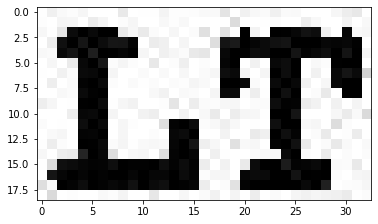

LT is valid.  adding image to subdata with corresponding name


block_number: 18
block_text: AC
block_confidence: 99.7966079711914
block_width: 0.027086377143859863
block_height: 0.049428343772888184
block_left: 0.7129747271537781
block_top: 0.2676945924758911
block_polygon: [{'X': 0.7129747271537781, 'Y': 0.2676945924758911}, {'X': 0.7400611042976379, 'Y': 0.2676945924758911}, {'X': 0.7400611042976379, 'Y': 0.3171229362487793}, {'X': 0.7129747271537781, 'Y': 0.3171229362487793}]
block_polygon_x1: 0.7129747271537781
block_polygon_y1: 0.2676945924758911
block_polygon_x2: 0.7400611042976379
block_polygon_y2: 0.2676945924758911
block_polygon_x3: 0.7400611042976379
block_polygon_y3: 0.3171229362487793
block_polygon_x4: 0.7129747271537781
block_polygon_y4: 0.3171229362487793
left_boundary: 948
right_boundary: 984
bottom_boundary: 104
top_boundary: 123


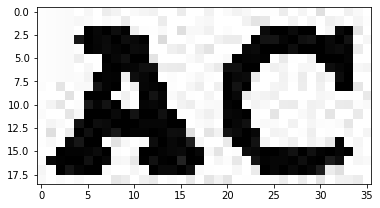

AC is valid.  adding image to subdata with corresponding name


block_number: 19
block_text: 690 00
block_confidence: 92.47492218017578
block_width: 0.07175588607788086
block_height: 0.05191516876220703
block_left: 0.8321129083633423
block_top: 0.2612507939338684
block_polygon: [{'X': 0.8321129083633423, 'Y': 0.2612507939338684}, {'X': 0.9038687944412231, 'Y': 0.2612507939338684}, {'X': 0.9038687944412231, 'Y': 0.31316596269607544}, {'X': 0.8321129083633423, 'Y': 0.31316596269607544}]
block_polygon_x1: 0.8321129083633423
block_polygon_y1: 0.2612507939338684
block_polygon_x2: 0.9038687944412231
block_polygon_y2: 0.2612507939338684
block_polygon_x3: 0.9038687944412231
block_polygon_y3: 0.31316596269607544
block_polygon_x4: 0.8321129083633423
block_polygon_y4: 0.31316596269607544
left_boundary: 1106
right_boundary: 1202
bottom_boundary: 101
top_boundary: 122


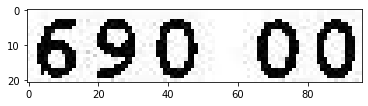

690 00 is valid.  adding image to subdata with corresponding name


block_number: 20
block_text: 3
block_confidence: 99.42427062988281
block_width: 0.010462641716003418
block_height: 0.05030345916748047
block_left: 0.9216770529747009
block_top: 0.264460027217865
block_polygon: [{'X': 0.9216770529747009, 'Y': 0.264460027217865}, {'X': 0.9321396946907043, 'Y': 0.264460027217865}, {'X': 0.9321396946907043, 'Y': 0.31476348638534546}, {'X': 0.9216770529747009, 'Y': 0.31476348638534546}]
block_polygon_x1: 0.9216770529747009
block_polygon_y1: 0.264460027217865
block_polygon_x2: 0.9321396946907043
block_polygon_y2: 0.264460027217865
block_polygon_x3: 0.9321396946907043
block_polygon_y3: 0.31476348638534546
block_polygon_x4: 0.9216770529747009
block_polygon_y4: 0.31476348638534546
left_boundary: 1225
right_boundary: 1239
bottom_boundary: 103
top_boundary: 122


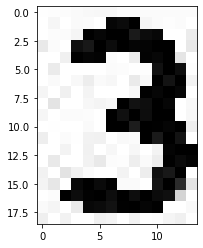

3 is valid.  adding image to subdata with corresponding name


block_number: 21
block_text: 3
block_confidence: 95.078125
block_width: 0.016357125714421272
block_height: 0.07556849718093872
block_left: 0.012953102588653564
block_top: 0.3659851849079132
block_polygon: [{'X': 0.012953102588653564, 'Y': 0.3659851849079132}, {'X': 0.029310228303074837, 'Y': 0.3659851849079132}, {'X': 0.029310228303074837, 'Y': 0.44155368208885193}, {'X': 0.012953102588653564, 'Y': 0.44155368208885193}]
block_polygon_x1: 0.012953102588653564
block_polygon_y1: 0.3659851849079132
block_polygon_x2: 0.029310228303074837
block_polygon_y2: 0.3659851849079132
block_polygon_x3: 0.029310228303074837
block_polygon_y3: 0.44155368208885193
block_polygon_x4: 0.012953102588653564
block_polygon_y4: 0.44155368208885193
left_boundary: 17
right_boundary: 38
bottom_boundary: 142
top_boundary: 172


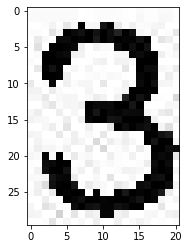

3 is valid.  adding image to subdata with corresponding name


block_number: 22
block_text: 08 10 20
block_confidence: 99.45902252197266
block_width: 0.10903750360012054
block_height: 0.06121310219168663
block_left: 0.04721622169017792
block_top: 0.4284062683582306
block_polygon: [{'X': 0.04721622169017792, 'Y': 0.4284062683582306}, {'X': 0.15625372529029846, 'Y': 0.4284062683582306}, {'X': 0.15625372529029846, 'Y': 0.4896193742752075}, {'X': 0.04721622169017792, 'Y': 0.4896193742752075}]
block_polygon_x1: 0.04721622169017792
block_polygon_y1: 0.4284062683582306
block_polygon_x2: 0.15625372529029846
block_polygon_y2: 0.4284062683582306
block_polygon_x3: 0.15625372529029846
block_polygon_y3: 0.4896193742752075
block_polygon_x4: 0.04721622169017792
block_polygon_y4: 0.4896193742752075
left_boundary: 62
right_boundary: 207
bottom_boundary: 167
top_boundary: 190


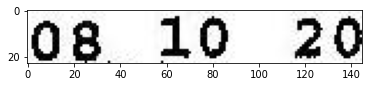

08 10 20 is valid.  adding image to subdata with corresponding name


block_number: 23
block_text: 08
block_confidence: 99.39289093017578
block_width: 0.022555485367774963
block_height: 0.05158871412277222
block_left: 0.18159621953964233
block_top: 0.43237993121147156
block_polygon: [{'X': 0.18159621953964233, 'Y': 0.43237993121147156}, {'X': 0.2041517049074173, 'Y': 0.43237993121147156}, {'X': 0.2041517049074173, 'Y': 0.4839686453342438}, {'X': 0.18159621953964233, 'Y': 0.4839686453342438}]
block_polygon_x1: 0.18159621953964233
block_polygon_y1: 0.43237993121147156
block_polygon_x2: 0.2041517049074173
block_polygon_y2: 0.43237993121147156
block_polygon_x3: 0.2041517049074173
block_polygon_y3: 0.4839686453342438
block_polygon_x4: 0.18159621953964233
block_polygon_y4: 0.4839686453342438
left_boundary: 241
right_boundary: 271
bottom_boundary: 168
top_boundary: 188


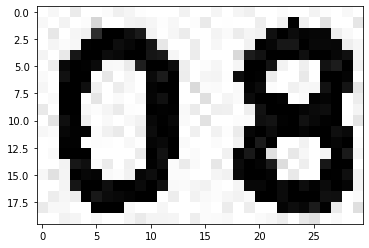

08 is valid.  adding image to subdata with corresponding name


block_number: 24
block_text: 10
block_confidence: 96.22183227539062
block_width: 0.022787824273109436
block_height: 0.05058225989341736
block_left: 0.22700445353984833
block_top: 0.43178319931030273
block_polygon: [{'X': 0.22700445353984833, 'Y': 0.43178319931030273}, {'X': 0.24979227781295776, 'Y': 0.43178319931030273}, {'X': 0.24979227781295776, 'Y': 0.4823654592037201}, {'X': 0.22700445353984833, 'Y': 0.4823654592037201}]
block_polygon_x1: 0.22700445353984833
block_polygon_y1: 0.43178319931030273
block_polygon_x2: 0.24979227781295776
block_polygon_y2: 0.43178319931030273
block_polygon_x3: 0.24979227781295776
block_polygon_y3: 0.4823654592037201
block_polygon_x4: 0.22700445353984833
block_polygon_y4: 0.4823654592037201
left_boundary: 301
right_boundary: 332
bottom_boundary: 168
top_boundary: 188


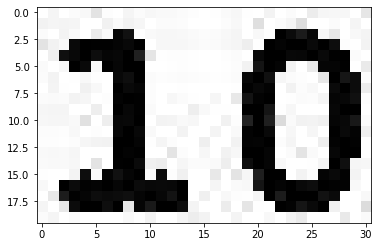

10 is valid.  adding image to subdata with corresponding name


block_number: 25
block_text: 20
block_confidence: 96.677001953125
block_width: 0.023696333169937134
block_height: 0.050044119358062744
block_left: 0.26990726590156555
block_top: 0.43183577060699463
block_polygon: [{'X': 0.26990726590156555, 'Y': 0.43183577060699463}, {'X': 0.2936035990715027, 'Y': 0.43183577060699463}, {'X': 0.2936035990715027, 'Y': 0.4818798899650574}, {'X': 0.26990726590156555, 'Y': 0.4818798899650574}]
block_polygon_x1: 0.26990726590156555
block_polygon_y1: 0.43183577060699463
block_polygon_x2: 0.2936035990715027
block_polygon_y2: 0.43183577060699463
block_polygon_x3: 0.2936035990715027
block_polygon_y3: 0.4818798899650574
block_polygon_x4: 0.26990726590156555
block_polygon_y4: 0.4818798899650574
left_boundary: 358
right_boundary: 390
bottom_boundary: 168
top_boundary: 187


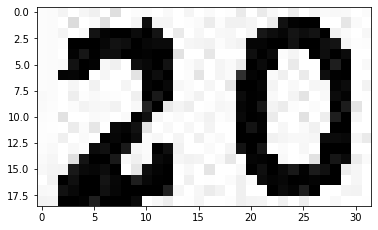

20 is valid.  adding image to subdata with corresponding name


block_number: 26
block_text: 12
block_confidence: 99.19404602050781
block_width: 0.023296326398849487
block_height: 0.049008965492248535
block_left: 0.3167518675327301
block_top: 0.4311257302761078
block_polygon: [{'X': 0.3167518675327301, 'Y': 0.4311257302761078}, {'X': 0.3400481939315796, 'Y': 0.4311257302761078}, {'X': 0.3400481939315796, 'Y': 0.4801346957683563}, {'X': 0.3167518675327301, 'Y': 0.4801346957683563}]
block_polygon_x1: 0.3167518675327301
block_polygon_y1: 0.4311257302761078
block_polygon_x2: 0.3400481939315796
block_polygon_y2: 0.4311257302761078
block_polygon_x3: 0.3400481939315796
block_polygon_y3: 0.4801346957683563
block_polygon_x4: 0.3167518675327301
block_polygon_y4: 0.4801346957683563
left_boundary: 421
right_boundary: 452
bottom_boundary: 168
top_boundary: 187


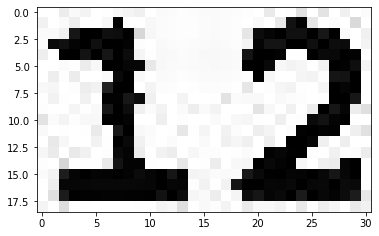

12 is valid.  adding image to subdata with corresponding name


block_number: 27
block_text: A5500
block_confidence: 99.41071319580078
block_width: 0.06480821967124939
block_height: 0.05523189902305603
block_left: 0.41386258602142334
block_top: 0.4277711808681488
block_polygon: [{'X': 0.41386258602142334, 'Y': 0.4277711808681488}, {'X': 0.47867080569267273, 'Y': 0.4277711808681488}, {'X': 0.47867080569267273, 'Y': 0.48300307989120483}, {'X': 0.41386258602142334, 'Y': 0.48300307989120483}]
block_polygon_x1: 0.41386258602142334
block_polygon_y1: 0.4277711808681488
block_polygon_x2: 0.47867080569267273
block_polygon_y2: 0.4277711808681488
block_polygon_x3: 0.47867080569267273
block_polygon_y3: 0.48300307989120483
block_polygon_x4: 0.41386258602142334
block_polygon_y4: 0.48300307989120483
left_boundary: 550
right_boundary: 636
bottom_boundary: 166
top_boundary: 188


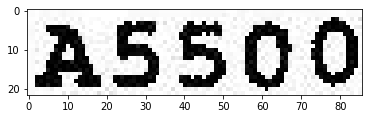

A5500 is valid.  adding image to subdata with corresponding name


block_number: 28
block_text: RT
block_confidence: 99.89799499511719
block_width: 0.025108695030212402
block_height: 0.04895591735839844
block_left: 0.5195431113243103
block_top: 0.43203312158584595
block_polygon: [{'X': 0.5195431113243103, 'Y': 0.43203312158584595}, {'X': 0.5446518063545227, 'Y': 0.43203312158584595}, {'X': 0.5446518063545227, 'Y': 0.4809890389442444}, {'X': 0.5195431113243103, 'Y': 0.4809890389442444}]
block_polygon_x1: 0.5195431113243103
block_polygon_y1: 0.43203312158584595
block_polygon_x2: 0.5446518063545227
block_polygon_y2: 0.43203312158584595
block_polygon_x3: 0.5446518063545227
block_polygon_y3: 0.4809890389442444
block_polygon_x4: 0.5195431113243103
block_polygon_y4: 0.4809890389442444
left_boundary: 690
right_boundary: 724
bottom_boundary: 168
top_boundary: 187


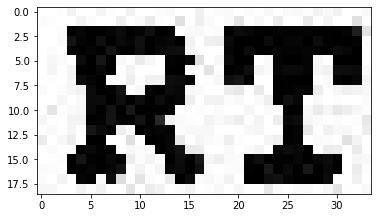

RT is valid.  adding image to subdata with corresponding name


block_number: 29
block_text: ABC
block_confidence: 99.62298583984375
block_width: 0.04072970151901245
block_height: 0.0510430634021759
block_left: 0.713316798210144
block_top: 0.42817509174346924
block_polygon: [{'X': 0.713316798210144, 'Y': 0.42817509174346924}, {'X': 0.7540464997291565, 'Y': 0.42817509174346924}, {'X': 0.7540464997291565, 'Y': 0.47921815514564514}, {'X': 0.713316798210144, 'Y': 0.47921815514564514}]
block_polygon_x1: 0.713316798210144
block_polygon_y1: 0.42817509174346924
block_polygon_x2: 0.7540464997291565
block_polygon_y2: 0.42817509174346924
block_polygon_x3: 0.7540464997291565
block_polygon_y3: 0.47921815514564514
block_polygon_x4: 0.713316798210144
block_polygon_y4: 0.47921815514564514
left_boundary: 948
right_boundary: 1002
bottom_boundary: 166
top_boundary: 186


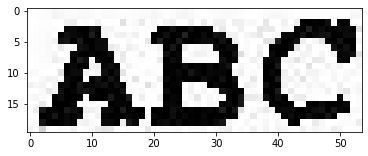

ABC is valid.  adding image to subdata with corresponding name


block_number: 30
block_text: 90 00
block_confidence: 76.07257080078125
block_width: 0.05847591161727905
block_height: 0.05558815598487854
block_left: 0.8459385633468628
block_top: 0.4222085475921631
block_polygon: [{'X': 0.8459385633468628, 'Y': 0.4222085475921631}, {'X': 0.9044144749641418, 'Y': 0.4222085475921631}, {'X': 0.9044144749641418, 'Y': 0.4777967035770416}, {'X': 0.8459385633468628, 'Y': 0.4777967035770416}]
block_polygon_x1: 0.8459385633468628
block_polygon_y1: 0.4222085475921631
block_polygon_x2: 0.9044144749641418
block_polygon_y2: 0.4222085475921631
block_polygon_x3: 0.9044144749641418
block_polygon_y3: 0.4777967035770416
block_polygon_x4: 0.8459385633468628
block_polygon_y4: 0.4777967035770416
left_boundary: 1125
right_boundary: 1202
bottom_boundary: 164
top_boundary: 186


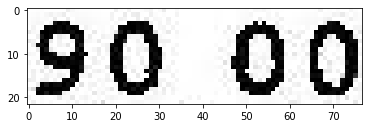

90 00 is valid.  adding image to subdata with corresponding name


block_number: 31
block_text: 1
block_confidence: 98.85388946533203
block_width: 0.012465298175811768
block_height: 0.048014938831329346
block_left: 0.9216158986091614
block_top: 0.42731359601020813
block_polygon: [{'X': 0.9216158986091614, 'Y': 0.42731359601020813}, {'X': 0.9340811967849731, 'Y': 0.42731359601020813}, {'X': 0.9340811967849731, 'Y': 0.4753285348415375}, {'X': 0.9216158986091614, 'Y': 0.4753285348415375}]
block_polygon_x1: 0.9216158986091614
block_polygon_y1: 0.42731359601020813
block_polygon_x2: 0.9340811967849731
block_polygon_y2: 0.42731359601020813
block_polygon_x3: 0.9340811967849731
block_polygon_y3: 0.4753285348415375
block_polygon_x4: 0.9216158986091614
block_polygon_y4: 0.4753285348415375
left_boundary: 1225
right_boundary: 1242
bottom_boundary: 166
top_boundary: 185


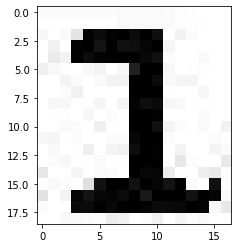

1 is valid.  adding image to subdata with corresponding name


block_number: 32
block_text: 4
block_confidence: 90.28258514404297
block_width: 0.014672071672976017
block_height: 0.06840664148330688
block_left: 0.014277325011789799
block_top: 0.5358509421348572
block_polygon: [{'X': 0.014277325011789799, 'Y': 0.5358509421348572}, {'X': 0.028949396684765816, 'Y': 0.5358509421348572}, {'X': 0.028949396684765816, 'Y': 0.6042575836181641}, {'X': 0.014277325011789799, 'Y': 0.6042575836181641}]
block_polygon_x1: 0.014277325011789799
block_polygon_y1: 0.5358509421348572
block_polygon_x2: 0.028949396684765816
block_polygon_y2: 0.5358509421348572
block_polygon_x3: 0.028949396684765816
block_polygon_y3: 0.6042575836181641
block_polygon_x4: 0.014277325011789799
block_polygon_y4: 0.6042575836181641
left_boundary: 18
right_boundary: 38
bottom_boundary: 208
top_boundary: 235


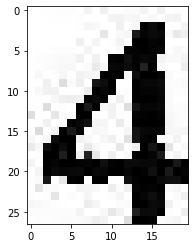

4 is valid.  adding image to subdata with corresponding name


block_number: 33
block_text: 08 10 20
block_confidence: 85.45471954345703
block_width: 0.11099446564912796
block_height: 0.056183237582445145
block_left: 0.047121454030275345
block_top: 0.6059290170669556
block_polygon: [{'X': 0.047121454030275345, 'Y': 0.6059290170669556}, {'X': 0.1581159234046936, 'Y': 0.6059290170669556}, {'X': 0.1581159234046936, 'Y': 0.6621122360229492}, {'X': 0.047121454030275345, 'Y': 0.6621122360229492}]
block_polygon_x1: 0.047121454030275345
block_polygon_y1: 0.6059290170669556
block_polygon_x2: 0.1581159234046936
block_polygon_y2: 0.6059290170669556
block_polygon_x3: 0.1581159234046936
block_polygon_y3: 0.6621122360229492
block_polygon_x4: 0.047121454030275345
block_polygon_y4: 0.6621122360229492
left_boundary: 62
right_boundary: 210
bottom_boundary: 236
top_boundary: 258


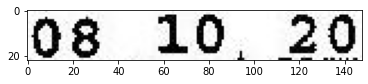

08 10 20 is valid.  adding image to subdata with corresponding name


block_number: 34
block_text: 08
block_confidence: 99.18236541748047
block_width: 0.02240578830242157
block_height: 0.05145835876464844
block_left: 0.18167950212955475
block_top: 0.6033324003219604
block_polygon: [{'X': 0.18167950212955475, 'Y': 0.6033324003219604}, {'X': 0.20408529043197632, 'Y': 0.6033324003219604}, {'X': 0.20408529043197632, 'Y': 0.6547907590866089}, {'X': 0.18167950212955475, 'Y': 0.6547907590866089}]
block_polygon_x1: 0.18167950212955475
block_polygon_y1: 0.6033324003219604
block_polygon_x2: 0.20408529043197632
block_polygon_y2: 0.6033324003219604
block_polygon_x3: 0.20408529043197632
block_polygon_y3: 0.6547907590866089
block_polygon_x4: 0.18167950212955475
block_polygon_y4: 0.6547907590866089
left_boundary: 241
right_boundary: 271
bottom_boundary: 235
top_boundary: 255


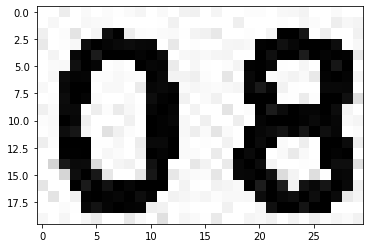

08 is valid.  adding image to subdata with corresponding name


block_number: 35
block_text: 10
block_confidence: 98.62908172607422
block_width: 0.022359877824783325
block_height: 0.049293339252471924
block_left: 0.2269478738307953
block_top: 0.604728639125824
block_polygon: [{'X': 0.2269478738307953, 'Y': 0.604728639125824}, {'X': 0.2493077516555786, 'Y': 0.604728639125824}, {'X': 0.2493077516555786, 'Y': 0.6540219783782959}, {'X': 0.2269478738307953, 'Y': 0.6540219783782959}]
block_polygon_x1: 0.2269478738307953
block_polygon_y1: 0.604728639125824
block_polygon_x2: 0.2493077516555786
block_polygon_y2: 0.604728639125824
block_polygon_x3: 0.2493077516555786
block_polygon_y3: 0.6540219783782959
block_polygon_x4: 0.2269478738307953
block_polygon_y4: 0.6540219783782959
left_boundary: 301
right_boundary: 331
bottom_boundary: 235
top_boundary: 255


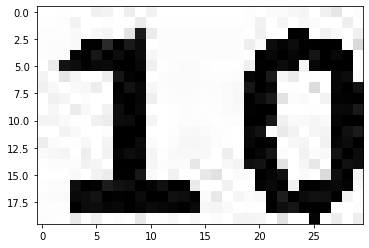

10 is valid.  adding image to subdata with corresponding name


block_number: 36
block_text: 20
block_confidence: 97.4305419921875
block_width: 0.022750824689865112
block_height: 0.051132798194885254
block_left: 0.27010396122932434
block_top: 0.603800892829895
block_polygon: [{'X': 0.27010396122932434, 'Y': 0.603800892829895}, {'X': 0.29285478591918945, 'Y': 0.603800892829895}, {'X': 0.29285478591918945, 'Y': 0.6549336910247803}, {'X': 0.27010396122932434, 'Y': 0.6549336910247803}]
block_polygon_x1: 0.27010396122932434
block_polygon_y1: 0.603800892829895
block_polygon_x2: 0.29285478591918945
block_polygon_y2: 0.603800892829895
block_polygon_x3: 0.29285478591918945
block_polygon_y3: 0.6549336910247803
block_polygon_x4: 0.27010396122932434
block_polygon_y4: 0.6549336910247803
left_boundary: 359
right_boundary: 389
bottom_boundary: 235
top_boundary: 255


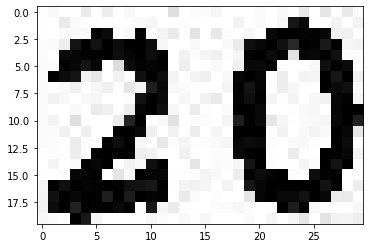

20 is valid.  adding image to subdata with corresponding name


block_number: 37
block_text: 12
block_confidence: 99.67020416259766
block_width: 0.0240040123462677
block_height: 0.049660563468933105
block_left: 0.31682175397872925
block_top: 0.6046573519706726
block_polygon: [{'X': 0.31682175397872925, 'Y': 0.6046573519706726}, {'X': 0.34082576632499695, 'Y': 0.6046573519706726}, {'X': 0.34082576632499695, 'Y': 0.6543179154396057}, {'X': 0.31682175397872925, 'Y': 0.6543179154396057}]
block_polygon_x1: 0.31682175397872925
block_polygon_y1: 0.6046573519706726
block_polygon_x2: 0.34082576632499695
block_polygon_y2: 0.6046573519706726
block_polygon_x3: 0.34082576632499695
block_polygon_y3: 0.6543179154396057
block_polygon_x4: 0.31682175397872925
block_polygon_y4: 0.6543179154396057
left_boundary: 421
right_boundary: 453
bottom_boundary: 235
top_boundary: 255


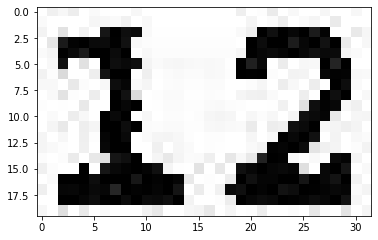

12 is valid.  adding image to subdata with corresponding name


block_number: 38
block_text: A5513
block_confidence: 99.71124267578125
block_width: 0.06466063857078552
block_height: 0.053564369678497314
block_left: 0.41357743740081787
block_top: 0.6012775301933289
block_polygon: [{'X': 0.41357743740081787, 'Y': 0.6012775301933289}, {'X': 0.4782380759716034, 'Y': 0.6012775301933289}, {'X': 0.4782380759716034, 'Y': 0.6548418998718262}, {'X': 0.41357743740081787, 'Y': 0.6548418998718262}]
block_polygon_x1: 0.41357743740081787
block_polygon_y1: 0.6012775301933289
block_polygon_x2: 0.4782380759716034
block_polygon_y2: 0.6012775301933289
block_polygon_x3: 0.4782380759716034
block_polygon_y3: 0.6548418998718262
block_polygon_x4: 0.41357743740081787
block_polygon_y4: 0.6548418998718262
left_boundary: 550
right_boundary: 636
bottom_boundary: 234
top_boundary: 255


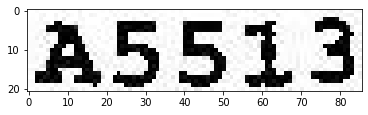

A5513 is valid.  adding image to subdata with corresponding name


block_number: 39
block_text: RT
block_confidence: 99.85387420654297
block_width: 0.025195419788360596
block_height: 0.04970294237136841
block_left: 0.5196741819381714
block_top: 0.6045954823493958
block_polygon: [{'X': 0.5196741819381714, 'Y': 0.6045954823493958}, {'X': 0.544869601726532, 'Y': 0.6045954823493958}, {'X': 0.544869601726532, 'Y': 0.6542984247207642}, {'X': 0.5196741819381714, 'Y': 0.6542984247207642}]
block_polygon_x1: 0.5196741819381714
block_polygon_y1: 0.6045954823493958
block_polygon_x2: 0.544869601726532
block_polygon_y2: 0.6045954823493958
block_polygon_x3: 0.544869601726532
block_polygon_y3: 0.6542984247207642
block_polygon_x4: 0.5196741819381714
block_polygon_y4: 0.6542984247207642
left_boundary: 691
right_boundary: 724
bottom_boundary: 235
top_boundary: 255


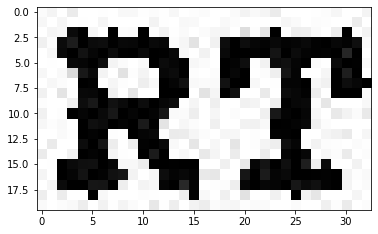

RT is valid.  adding image to subdata with corresponding name


block_number: 40
block_text: ABC
block_confidence: 99.49908447265625
block_width: 0.039919495582580566
block_height: 0.049358904361724854
block_left: 0.7133543491363525
block_top: 0.6036883592605591
block_polygon: [{'X': 0.7133543491363525, 'Y': 0.6036883592605591}, {'X': 0.7532738447189331, 'Y': 0.6036883592605591}, {'X': 0.7532738447189331, 'Y': 0.6530472636222839}, {'X': 0.7133543491363525, 'Y': 0.6530472636222839}]
block_polygon_x1: 0.7133543491363525
block_polygon_y1: 0.6036883592605591
block_polygon_x2: 0.7532738447189331
block_polygon_y2: 0.6036883592605591
block_polygon_x3: 0.7532738447189331
block_polygon_y3: 0.6530472636222839
block_polygon_x4: 0.7133543491363525
block_polygon_y4: 0.6530472636222839
left_boundary: 948
right_boundary: 1001
bottom_boundary: 235
top_boundary: 254


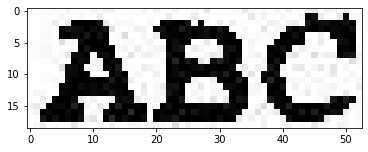

ABC is valid.  adding image to subdata with corresponding name


block_number: 41
block_text: 690 00 3
block_confidence: 92.1727294921875
block_width: 0.09988468140363693
block_height: 0.057709693908691406
block_left: 0.8332708477973938
block_top: 0.5972734093666077
block_polygon: [{'X': 0.8332708477973938, 'Y': 0.5972734093666077}, {'X': 0.9331555366516113, 'Y': 0.5972734093666077}, {'X': 0.9331555366516113, 'Y': 0.6549831032752991}, {'X': 0.8332708477973938, 'Y': 0.6549831032752991}]
block_polygon_x1: 0.8332708477973938
block_polygon_y1: 0.5972734093666077
block_polygon_x2: 0.9331555366516113
block_polygon_y2: 0.5972734093666077
block_polygon_x3: 0.9331555366516113
block_polygon_y3: 0.6549831032752991
block_polygon_x4: 0.8332708477973938
block_polygon_y4: 0.6549831032752991
left_boundary: 1108
right_boundary: 1241
bottom_boundary: 232
top_boundary: 255


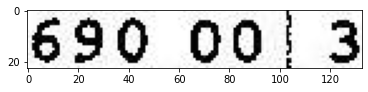

690 00 3 is valid.  adding image to subdata with corresponding name


block_number: 42
block_text: 5
block_confidence: 86.23245239257812
block_width: 0.01633644476532936
block_height: 0.07114005088806152
block_left: 0.014817388728260994
block_top: 0.7116398811340332
block_polygon: [{'X': 0.014817388728260994, 'Y': 0.7116398811340332}, {'X': 0.031153833493590355, 'Y': 0.7116398811340332}, {'X': 0.031153833493590355, 'Y': 0.7827799320220947}, {'X': 0.014817388728260994, 'Y': 0.7827799320220947}]
block_polygon_x1: 0.014817388728260994
block_polygon_y1: 0.7116398811340332
block_polygon_x2: 0.031153833493590355
block_polygon_y2: 0.7116398811340332
block_polygon_x3: 0.031153833493590355
block_polygon_y3: 0.7827799320220947
block_polygon_x4: 0.014817388728260994
block_polygon_y4: 0.7827799320220947
left_boundary: 19
right_boundary: 41
bottom_boundary: 277
top_boundary: 305


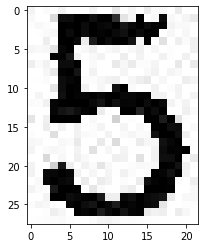

5 is valid.  adding image to subdata with corresponding name


block_number: 43
block_text: 08
block_confidence: 99.34903717041016
block_width: 0.022277742624282837
block_height: 0.05551975965499878
block_left: 0.1826452761888504
block_top: 0.7708722352981567
block_polygon: [{'X': 0.1826452761888504, 'Y': 0.7708722352981567}, {'X': 0.20492301881313324, 'Y': 0.7708722352981567}, {'X': 0.20492301881313324, 'Y': 0.8263919949531555}, {'X': 0.1826452761888504, 'Y': 0.8263919949531555}]
block_polygon_x1: 0.1826452761888504
block_polygon_y1: 0.7708722352981567
block_polygon_x2: 0.20492301881313324
block_polygon_y2: 0.7708722352981567
block_polygon_x3: 0.20492301881313324
block_polygon_y3: 0.8263919949531555
block_polygon_x4: 0.1826452761888504
block_polygon_y4: 0.8263919949531555
left_boundary: 242
right_boundary: 272
bottom_boundary: 300
top_boundary: 322


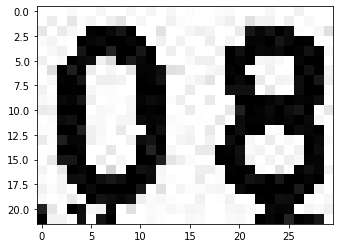

08 is valid.  adding image to subdata with corresponding name


block_number: 44
block_text: 10
block_confidence: 96.31790161132812
block_width: 0.022741779685020447
block_height: 0.052150189876556396
block_left: 0.22755254805088043
block_top: 0.7707129120826721
block_polygon: [{'X': 0.22755254805088043, 'Y': 0.7707129120826721}, {'X': 0.2502943277359009, 'Y': 0.7707129120826721}, {'X': 0.2502943277359009, 'Y': 0.8228631019592285}, {'X': 0.22755254805088043, 'Y': 0.8228631019592285}]
block_polygon_x1: 0.22755254805088043
block_polygon_y1: 0.7707129120826721
block_polygon_x2: 0.2502943277359009
block_polygon_y2: 0.7707129120826721
block_polygon_x3: 0.2502943277359009
block_polygon_y3: 0.8228631019592285
block_polygon_x4: 0.22755254805088043
block_polygon_y4: 0.8228631019592285
left_boundary: 302
right_boundary: 332
bottom_boundary: 300
top_boundary: 320


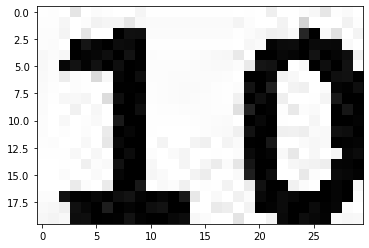

10 is valid.  adding image to subdata with corresponding name


block_number: 45
block_text: 20
block_confidence: 97.79010772705078
block_width: 0.023751169443130493
block_height: 0.053380727767944336
block_left: 0.2705797553062439
block_top: 0.7706156969070435
block_polygon: [{'X': 0.2705797553062439, 'Y': 0.7706156969070435}, {'X': 0.2943309247493744, 'Y': 0.7706156969070435}, {'X': 0.2943309247493744, 'Y': 0.8239964246749878}, {'X': 0.2705797553062439, 'Y': 0.8239964246749878}]
block_polygon_x1: 0.2705797553062439
block_polygon_y1: 0.7706156969070435
block_polygon_x2: 0.2943309247493744
block_polygon_y2: 0.7706156969070435
block_polygon_x3: 0.2943309247493744
block_polygon_y3: 0.8239964246749878
block_polygon_x4: 0.2705797553062439
block_polygon_y4: 0.8239964246749878
left_boundary: 359
right_boundary: 391
bottom_boundary: 300
top_boundary: 321


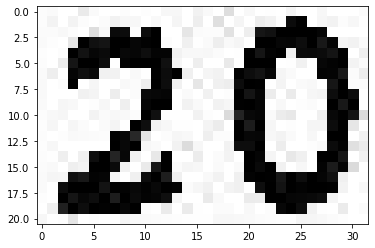

20 is valid.  adding image to subdata with corresponding name


block_number: 46
block_text: l 12
block_confidence: 89.74760437011719
block_width: 0.040908146649599075
block_height: 0.05713215097784996
block_left: 0.3003443777561188
block_top: 0.7711214423179626
block_polygon: [{'X': 0.3003443777561188, 'Y': 0.7711214423179626}, {'X': 0.34125253558158875, 'Y': 0.7711214423179626}, {'X': 0.34125253558158875, 'Y': 0.8282535672187805}, {'X': 0.3003443777561188, 'Y': 0.8282535672187805}]
block_polygon_x1: 0.3003443777561188
block_polygon_y1: 0.7711214423179626
block_polygon_x2: 0.34125253558158875
block_polygon_y2: 0.7711214423179626
block_polygon_x3: 0.34125253558158875
block_polygon_y3: 0.8282535672187805
block_polygon_x4: 0.3003443777561188
block_polygon_y4: 0.8282535672187805
left_boundary: 399
right_boundary: 453
bottom_boundary: 300
top_boundary: 323


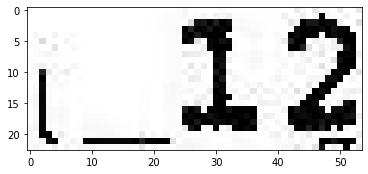

l 12 is valid.  adding image to subdata with corresponding name


block_number: 47
block_text: L3390
block_confidence: 98.51587677001953
block_width: 0.06555533409118652
block_height: 0.058879852294921875
block_left: 0.41446951031684875
block_top: 0.7666841149330139
block_polygon: [{'X': 0.41446951031684875, 'Y': 0.7666841149330139}, {'X': 0.4800248444080353, 'Y': 0.7666841149330139}, {'X': 0.4800248444080353, 'Y': 0.8255639672279358}, {'X': 0.41446951031684875, 'Y': 0.8255639672279358}]
block_polygon_x1: 0.41446951031684875
block_polygon_y1: 0.7666841149330139
block_polygon_x2: 0.4800248444080353
block_polygon_y2: 0.7666841149330139
block_polygon_x3: 0.4800248444080353
block_polygon_y3: 0.8255639672279358
block_polygon_x4: 0.41446951031684875
block_polygon_y4: 0.8255639672279358
left_boundary: 551
right_boundary: 638
bottom_boundary: 299
top_boundary: 321


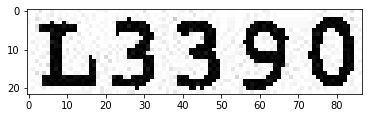

L3390 is valid.  adding image to subdata with corresponding name


block_number: 48
block_text: LT
block_confidence: 99.80359649658203
block_width: 0.02587890625
block_height: 0.05258071422576904
block_left: 0.5203050374984741
block_top: 0.7712960839271545
block_polygon: [{'X': 0.5203050374984741, 'Y': 0.7712960839271545}, {'X': 0.5461839437484741, 'Y': 0.7712960839271545}, {'X': 0.5461839437484741, 'Y': 0.8238767981529236}, {'X': 0.5203050374984741, 'Y': 0.8238767981529236}]
block_polygon_x1: 0.5203050374984741
block_polygon_y1: 0.7712960839271545
block_polygon_x2: 0.5461839437484741
block_polygon_y2: 0.7712960839271545
block_polygon_x3: 0.5461839437484741
block_polygon_y3: 0.8238767981529236
block_polygon_x4: 0.5203050374984741
block_polygon_y4: 0.8238767981529236
left_boundary: 692
right_boundary: 726
bottom_boundary: 300
top_boundary: 321


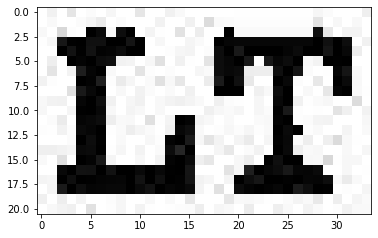

LT is valid.  adding image to subdata with corresponding name


block_number: 49
block_text: AC
block_confidence: 99.86517333984375
block_width: 0.02696174383163452
block_height: 0.04965776205062866
block_left: 0.7144157886505127
block_top: 0.7722676396369934
block_polygon: [{'X': 0.7144157886505127, 'Y': 0.7722676396369934}, {'X': 0.7413775324821472, 'Y': 0.7722676396369934}, {'X': 0.7413775324821472, 'Y': 0.8219254016876221}, {'X': 0.7144157886505127, 'Y': 0.8219254016876221}]
block_polygon_x1: 0.7144157886505127
block_polygon_y1: 0.7722676396369934
block_polygon_x2: 0.7413775324821472
block_polygon_y2: 0.7722676396369934
block_polygon_x3: 0.7413775324821472
block_polygon_y3: 0.8219254016876221
block_polygon_x4: 0.7144157886505127
block_polygon_y4: 0.8219254016876221
left_boundary: 950
right_boundary: 986
bottom_boundary: 301
top_boundary: 320


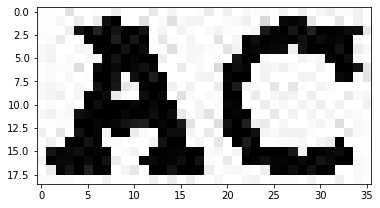

AC is valid.  adding image to subdata with corresponding name


block_number: 50
block_text: 60 00
block_confidence: 98.03812408447266
block_width: 0.057480812072753906
block_height: 0.054754793643951416
block_left: 0.8465096354484558
block_top: 0.7656324505805969
block_polygon: [{'X': 0.8465096354484558, 'Y': 0.7656324505805969}, {'X': 0.9039904475212097, 'Y': 0.7656324505805969}, {'X': 0.9039904475212097, 'Y': 0.8203872442245483}, {'X': 0.8465096354484558, 'Y': 0.8203872442245483}]
block_polygon_x1: 0.8465096354484558
block_polygon_y1: 0.7656324505805969
block_polygon_x2: 0.9039904475212097
block_polygon_y2: 0.7656324505805969
block_polygon_x3: 0.9039904475212097
block_polygon_y3: 0.8203872442245483
block_polygon_x4: 0.8465096354484558
block_polygon_y4: 0.8203872442245483
left_boundary: 1125
right_boundary: 1202
bottom_boundary: 298
top_boundary: 319


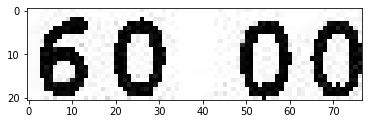

60 00 is valid.  adding image to subdata with corresponding name


block_number: 51
block_text: 1
block_confidence: 99.57099914550781
block_width: 0.011227905750274658
block_height: 0.05079406499862671
block_left: 0.923481822013855
block_top: 0.7678346037864685
block_polygon: [{'X': 0.923481822013855, 'Y': 0.7678346037864685}, {'X': 0.9347097277641296, 'Y': 0.7678346037864685}, {'X': 0.9347097277641296, 'Y': 0.8186286687850952}, {'X': 0.923481822013855, 'Y': 0.8186286687850952}]
block_polygon_x1: 0.923481822013855
block_polygon_y1: 0.7678346037864685
block_polygon_x2: 0.9347097277641296
block_polygon_y2: 0.7678346037864685
block_polygon_x3: 0.9347097277641296
block_polygon_y3: 0.8186286687850952
block_polygon_x4: 0.923481822013855
block_polygon_y4: 0.8186286687850952
left_boundary: 1228
right_boundary: 1243
bottom_boundary: 299
top_boundary: 319


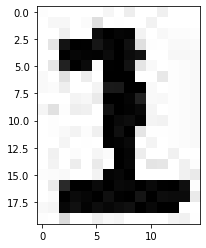

1 is valid.  adding image to subdata with corresponding name


block_number: 52
block_text: 6
block_confidence: 92.46973419189453
block_width: 0.017759323120117188
block_height: 0.07301414012908936
block_left: 0.014752478338778019
block_top: 0.8753291368484497
block_polygon: [{'X': 0.014752478338778019, 'Y': 0.8753291368484497}, {'X': 0.03251180052757263, 'Y': 0.8753291368484497}, {'X': 0.03251180052757263, 'Y': 0.9483432769775391}, {'X': 0.014752478338778019, 'Y': 0.9483432769775391}]
block_polygon_x1: 0.014752478338778019
block_polygon_y1: 0.8753291368484497
block_polygon_x2: 0.03251180052757263
block_polygon_y2: 0.8753291368484497
block_polygon_x3: 0.03251180052757263
block_polygon_y3: 0.9483432769775391
block_polygon_x4: 0.014752478338778019
block_polygon_y4: 0.9483432769775391
left_boundary: 19
right_boundary: 43
bottom_boundary: 341
top_boundary: 369


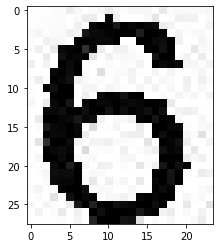

6 is valid.  adding image to subdata with corresponding name


block_number: 53
block_text: 08 10 20
block_confidence: 93.89468383789062
block_width: 0.10943238437175751
block_height: 0.05277233198285103
block_left: 0.04803799092769623
block_top: 0.94468754529953
block_polygon: [{'X': 0.04803799092769623, 'Y': 0.94468754529953}, {'X': 0.15747037529945374, 'Y': 0.94468754529953}, {'X': 0.15747037529945374, 'Y': 0.997459888458252}, {'X': 0.04803799092769623, 'Y': 0.997459888458252}]
block_polygon_x1: 0.04803799092769623
block_polygon_y1: 0.94468754529953
block_polygon_x2: 0.15747037529945374
block_polygon_y2: 0.94468754529953
block_polygon_x3: 0.15747037529945374
block_polygon_y3: 0.997459888458252
block_polygon_x4: 0.04803799092769623
block_polygon_y4: 0.997459888458252
left_boundary: 63
right_boundary: 209
bottom_boundary: 368
top_boundary: 389


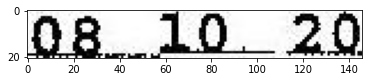

08 10 20 is valid.  adding image to subdata with corresponding name


block_number: 54
block_text: 10
block_confidence: 96.81233978271484
block_width: 0.022365063428878784
block_height: 0.05026900768280029
block_left: 0.22801068425178528
block_top: 0.942813515663147
block_polygon: [{'X': 0.22801068425178528, 'Y': 0.942813515663147}, {'X': 0.25037574768066406, 'Y': 0.942813515663147}, {'X': 0.25037574768066406, 'Y': 0.9930825233459473}, {'X': 0.22801068425178528, 'Y': 0.9930825233459473}]
block_polygon_x1: 0.22801068425178528
block_polygon_y1: 0.942813515663147
block_polygon_x2: 0.25037574768066406
block_polygon_y2: 0.942813515663147
block_polygon_x3: 0.25037574768066406
block_polygon_y3: 0.9930825233459473
block_polygon_x4: 0.22801068425178528
block_polygon_y4: 0.9930825233459473
left_boundary: 303
right_boundary: 332
bottom_boundary: 367
top_boundary: 387


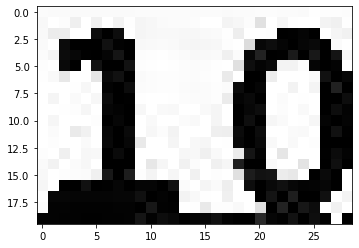

10 is valid.  adding image to subdata with corresponding name


block_number: 55
block_text: 20
block_confidence: 99.07815551757812
block_width: 0.022658854722976685
block_height: 0.05294454097747803
block_left: 0.27076059579849243
block_top: 0.9421831965446472
block_polygon: [{'X': 0.27076059579849243, 'Y': 0.9421831965446472}, {'X': 0.2934194505214691, 'Y': 0.9421831965446472}, {'X': 0.2934194505214691, 'Y': 0.9951277375221252}, {'X': 0.27076059579849243, 'Y': 0.9951277375221252}]
block_polygon_x1: 0.27076059579849243
block_polygon_y1: 0.9421831965446472
block_polygon_x2: 0.2934194505214691
block_polygon_y2: 0.9421831965446472
block_polygon_x3: 0.2934194505214691
block_polygon_y3: 0.9951277375221252
block_polygon_x4: 0.27076059579849243
block_polygon_y4: 0.9951277375221252
left_boundary: 360
right_boundary: 390
bottom_boundary: 367
top_boundary: 388


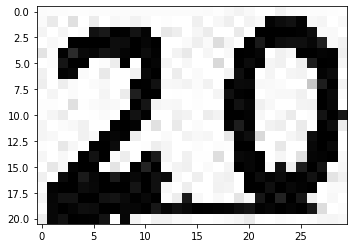

20 is valid.  adding image to subdata with corresponding name


block_number: 56
block_text: 12
block_confidence: 97.39173889160156
block_width: 0.024979054927825928
block_height: 0.052903056144714355
block_left: 0.31736820936203003
block_top: 0.9413177371025085
block_polygon: [{'X': 0.31736820936203003, 'Y': 0.9413177371025085}, {'X': 0.34234726428985596, 'Y': 0.9413177371025085}, {'X': 0.34234726428985596, 'Y': 0.9942207932472229}, {'X': 0.31736820936203003, 'Y': 0.9942207932472229}]
block_polygon_x1: 0.31736820936203003
block_polygon_y1: 0.9413177371025085
block_polygon_x2: 0.34234726428985596
block_polygon_y2: 0.9413177371025085
block_polygon_x3: 0.34234726428985596
block_polygon_y3: 0.9942207932472229
block_polygon_x4: 0.31736820936203003
block_polygon_y4: 0.9942207932472229
left_boundary: 422
right_boundary: 455
bottom_boundary: 367
top_boundary: 387


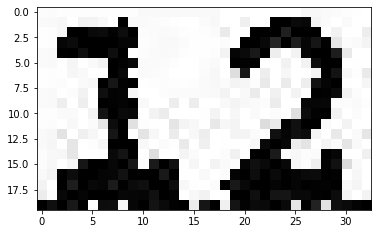

12 is valid.  adding image to subdata with corresponding name


block_number: 57
block_text: L3390
block_confidence: 94.87277221679688
block_width: 0.06409922242164612
block_height: 0.06003838777542114
block_left: 0.41496461629867554
block_top: 0.9390137791633606
block_polygon: [{'X': 0.41496461629867554, 'Y': 0.9390137791633606}, {'X': 0.47906383872032166, 'Y': 0.9390137791633606}, {'X': 0.47906383872032166, 'Y': 0.9990521669387817}, {'X': 0.41496461629867554, 'Y': 0.9990521669387817}]
block_polygon_x1: 0.41496461629867554
block_polygon_y1: 0.9390137791633606
block_polygon_x2: 0.47906383872032166
block_polygon_y2: 0.9390137791633606
block_polygon_x3: 0.47906383872032166
block_polygon_y3: 0.9990521669387817
block_polygon_x4: 0.41496461629867554
block_polygon_y4: 0.9990521669387817
left_boundary: 551
right_boundary: 637
bottom_boundary: 366
top_boundary: 389


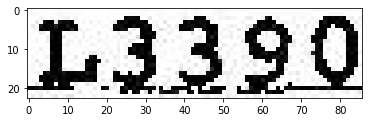

L3390 is valid.  adding image to subdata with corresponding name


block_number: 58
block_text: RT
block_confidence: 99.8436279296875
block_width: 0.025090515613555908
block_height: 0.04747438430786133
block_left: 0.5208722352981567
block_top: 0.9430651664733887
block_polygon: [{'X': 0.5208722352981567, 'Y': 0.9430651664733887}, {'X': 0.5459627509117126, 'Y': 0.9430651664733887}, {'X': 0.5459627509117126, 'Y': 0.99053955078125}, {'X': 0.5208722352981567, 'Y': 0.99053955078125}]
block_polygon_x1: 0.5208722352981567
block_polygon_y1: 0.9430651664733887
block_polygon_x2: 0.5459627509117126
block_polygon_y2: 0.9430651664733887
block_polygon_x3: 0.5459627509117126
block_polygon_y3: 0.99053955078125
block_polygon_x4: 0.5208722352981567
block_polygon_y4: 0.99053955078125
left_boundary: 692
right_boundary: 726
bottom_boundary: 367
top_boundary: 386


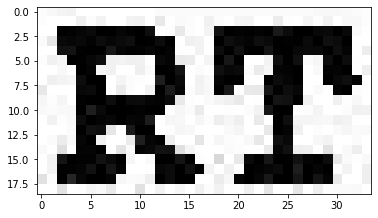

RT is valid.  adding image to subdata with corresponding name


block_number: 59
block_text: ABC
block_confidence: 99.74191284179688
block_width: 0.039660632610321045
block_height: 0.048727333545684814
block_left: 0.7143262624740601
block_top: 0.9399222135543823
block_polygon: [{'X': 0.7143262624740601, 'Y': 0.9399222135543823}, {'X': 0.7539868950843811, 'Y': 0.9399222135543823}, {'X': 0.7539868950843811, 'Y': 0.9886495471000671}, {'X': 0.7143262624740601, 'Y': 0.9886495471000671}]
block_polygon_x1: 0.7143262624740601
block_polygon_y1: 0.9399222135543823
block_polygon_x2: 0.7539868950843811
block_polygon_y2: 0.9399222135543823
block_polygon_x3: 0.7539868950843811
block_polygon_y3: 0.9886495471000671
block_polygon_x4: 0.7143262624740601
block_polygon_y4: 0.9886495471000671
left_boundary: 950
right_boundary: 1002
bottom_boundary: 366
top_boundary: 385


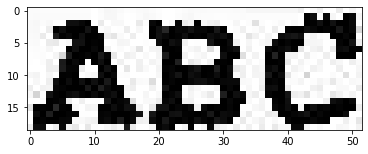

ABC is valid.  adding image to subdata with corresponding name


block_number: 60
block_text: 60 00 1
block_confidence: 97.18986511230469
block_width: 0.08743683248758316
block_height: 0.05720651149749756
block_left: 0.8466094732284546
block_top: 0.9333788156509399
block_polygon: [{'X': 0.8466094732284546, 'Y': 0.9333788156509399}, {'X': 0.9340463280677795, 'Y': 0.9333788156509399}, {'X': 0.9340463280677795, 'Y': 0.9905853271484375}, {'X': 0.8466094732284546, 'Y': 0.9905853271484375}]
block_polygon_x1: 0.8466094732284546
block_polygon_y1: 0.9333788156509399
block_polygon_x2: 0.9340463280677795
block_polygon_y2: 0.9333788156509399
block_polygon_x3: 0.9340463280677795
block_polygon_y3: 0.9905853271484375
block_polygon_x4: 0.8466094732284546
block_polygon_y4: 0.9905853271484375
left_boundary: 1125
right_boundary: 1242
bottom_boundary: 364
top_boundary: 386


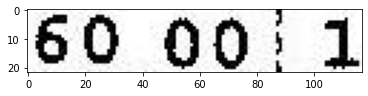

60 00 1 is valid.  adding image to subdata with corresponding name


analyzing image testimage1.jpeg
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/00 SZE___51.png
subimg_text: 00 SZE
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/00___40.png
subimg_text: 00
1.0
(1157, 292)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/08 10 20___102.png
subimg_text: 08 10 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/08 10 20___113.png
subimg_text: 08 10 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/08 10 20___124.png
subimg_text: 08 10 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/08 10 20___144.png
subimg_text: 08 10 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/08___103.png
subimg_text: 08
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_rec

subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___20.png
subimg_text: 20
1.0
(352, 158)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___28.png
subimg_text: 20
1.0
(350, 218)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___35.png
subimg_text: 20
1.0
(353, 290)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___45.png
subimg_text: 20
0.9999996423721313
(354, 356)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___5.png
subimg_text: 20
1.0
(353, 25)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___57.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___60.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___69.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Deskt

subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/LT___139.png
subimg_text: LT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/LT___98.png
subimg_text: LT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/N___61.png
subimg_text: N
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/N___73.png
subimg_text: N
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/RT___119.png
subimg_text: RT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/RT___130.png
subimg_text: RT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/RT___149.png
subimg_text: RT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/TC___21.png
subimg_text: TC
0.9999998211860657
(686, 159)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/TC___37.png
subim

subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___75.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___83.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___10.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___105.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___116.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___127.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___136.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___146.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___20.png
subimg_text: 20
subimg_filepath: C

subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/L3390___138.png
subimg_text: L3390
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/L3390___148.png
subimg_text: L3390
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/LT___108.png
subimg_text: LT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/LT___139.png
subimg_text: LT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/LT___98.png
subimg_text: LT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/N___61.png
subimg_text: N
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/N___73.png
subimg_text: N
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/RT___119.png
subimg_text: RT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/RT___130.png
subimg_text: RT
subim

subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___53.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___54.png
subimg_text: 1
0.9999998807907104
(32, 13)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___63.png
subimg_text: 1
1.0
(871, 31)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___75.png
subimg_text: 1
1.0
(870, 86)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___83.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___10.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___105.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/20___116.png
subimg_text: 20
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata

subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/II___52.png
subimg_text: II
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/I___50.png
subimg_text: I
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/I___82.png
subimg_text: I
1.0
(956, 304)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/l 12___137.png
subimg_text: l 12
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/L3390___138.png
subimg_text: L3390
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/L3390___148.png
subimg_text: L3390
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/LT___108.png
subimg_text: LT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/LT___139.png
subimg_text: LT
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/LT___98.png
sub

subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___18.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___23.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___41.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___48.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___53.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___54.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___63.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___75.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___83.png
subimg_text: 1
1.0
(7, 2)
subimg_filepath: C:/Users/

subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/A___38.png
subimg_text: A
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/A___46.png
subimg_text: A
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/A___87.png
subimg_text: A
0.999999463558197
(899, 22)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/IC___13.png
subimg_text: IC
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/II___52.png
subimg_text: II
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/I___50.png
subimg_text: I
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/I___82.png
subimg_text: I
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/l 12___137.png
subimg_text: l 12
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/L3390___138.png
subimg_t

subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/12___96.png
subimg_text: 12
1.0
(419, 39)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/14___76.png
subimg_text: 14
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1890___39.png
subimg_text: 1890
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___1.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___101.png
subimg_text: 1
0.999999463558197
(1225, 37)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___122.png
subimg_text: 1
1.0
(1225, 166)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___142.png
subimg_text: 1
1.0
(1228, 299)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/1___18.png
subimg_text: 1
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_r

1.0
(549, 39)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/A5513___107.png
subimg_text: A5513
1.0
(549, 103)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/A5513___129.png
subimg_text: A5513
1.0
(550, 234)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/ABC___120.png
subimg_text: ABC
0.9999999403953552
(948, 166)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/ABC___131.png
subimg_text: ABC
1.0
(948, 235)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/ABC___150.png
subimg_text: ABC
1.0
(950, 366)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/AC___109.png
subimg_text: AC
1.0
(948, 104)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata/AC___140.png
subimg_text: AC
0.9999999403953552
(950, 301)
subimg_filepath: C:/Users/iforrest/Desktop/Projects/img_recogni

('10', (304, 25), (335, 48))
('10', (304, 25), (335, 48))
('20', (353, 25), (385, 49))


('2', (29, 62), (51, 93))


('7', (1231, 95), (1240, 116))
('A', (960, 96), (978, 115))
('11', (255, 90), (285, 114))
('95861', (539, 91), (619, 116))
('20', (352, 91), (385, 115))
('95861', (539, 91), (619, 116))
('IC', (687, 94), (720, 115))
('A', (960, 96), (978, 115))
('3460 too', (1078, 85), (1188, 117))
('7', (1231, 95), (1240, 116))


('3', (29, 127), (51, 160))


('1', (304, 158), (315, 178))


('A', (960, 163), (976, 181))
('TC', (686, 159), (720, 180))
('TC', (686, 159), (720, 180))
('A', (960, 163), (976, 181))


('1', (1230, 162), (1242, 185))


('4', (30, 194), (52, 226))


('20', (350, 218), (384, 247))
('20', (350, 218), (384, 247))
('11', (255, 220), (285, 248))
('20', (350, 218), (384, 247))
('21', (424, 225), (453, 247))
('TO', (685, 226), (719, 246))


('5', (31, 264), (51, 294))


('20', (353, 290), (384, 314))
('11/10/20', (74, 271), (205, 313))
('11', (254, 290), (282, 312))
(

endY_next_item: 104
absolute_difference_between_endY_values: 0
concurrent row found
row_list: [('09', (112, 87), (135, 103)), ('09', (280, 87), (302, 103)), ('09', (280, 87), (302, 103)), ('12', (226, 87), (247, 103)), ('12', (226, 87), (247, 103)), ('N', (454, 87), (471, 103)), ('N', (454, 87), (471, 103)), ('110048', (531, 87), (590, 104)), ('110048', (531, 87), (590, 104)), ('12', (68, 88), (89, 104)), ('12', (68, 88), (89, 104)), ('14', (1045, 87), (1066, 104)), ('14', (1045, 87), (1066, 104)), ('20', (168, 87), (190, 104)), ('20', (168, 87), (190, 104)), ('20', (337, 87), (359, 104))]


item: ('20', (337, 87), (359, 104))
endY_item: 104
next_item: ('48', (1093, 87), (1115, 104))
endY_next_item: 104
absolute_difference_between_endY_values: 0
concurrent row found
row_list: [('09', (112, 87), (135, 103)), ('09', (280, 87), (302, 103)), ('09', (280, 87), (302, 103)), ('12', (226, 87), (247, 103)), ('12', (226, 87), (247, 103)), ('N', (454, 87), (471, 103)), ('N', (454, 87), (471, 103)

item: ('LT', (689, 39), (723, 59))
endY_item: 59
next_item: ('10', (300, 40), (330, 60))
endY_next_item: 60
absolute_difference_between_endY_values: 1
concurrent row found
row_list: [('1', (1225, 37), (1240, 57)), ('AC', (948, 39), (984, 58)), ('AC', (948, 39), (984, 58)), ('12', (419, 39), (452, 59)), ('12', (419, 39), (452, 59)), ('90 00', (1123, 36), (1202, 59)), ('90 00', (1123, 36), (1202, 59)), ('A5500', (549, 39), (636, 59)), ('A5500', (549, 39), (636, 59)), ('LT', (689, 39), (723, 59)), ('LT', (689, 39), (723, 59)), ('10', (300, 40), (330, 60))]


item: ('10', (300, 40), (330, 60))
endY_item: 60
next_item: ('20', (357, 40), (388, 60))
endY_next_item: 60
absolute_difference_between_endY_values: 0
concurrent row found
row_list: [('1', (1225, 37), (1240, 57)), ('AC', (948, 39), (984, 58)), ('AC', (948, 39), (984, 58)), ('12', (419, 39), (452, 59)), ('12', (419, 39), (452, 59)), ('90 00', (1123, 36), (1202, 59)), ('90 00', (1123, 36), (1202, 59)), ('A5500', (549, 39), (636, 59)), (

concurrent row found
row_list: [('1', (1228, 299), (1243, 319)), ('60 00', (1125, 298), (1202, 319)), ('60 00', (1125, 298), (1202, 319)), ('10', (302, 300), (332, 320)), ('10', (302, 300), (332, 320)), ('AC', (950, 301), (986, 320)), ('AC', (950, 301), (986, 320)), ('20', (359, 300), (391, 321)), ('20', (359, 300), (391, 321)), ('L3390', (551, 299), (638, 321))]


item: ('L3390', (551, 299), (638, 321))
endY_item: 321
next_item: ('LT', (692, 300), (726, 321))
endY_next_item: 321
absolute_difference_between_endY_values: 0
concurrent row found
row_list: [('1', (1228, 299), (1243, 319)), ('60 00', (1125, 298), (1202, 319)), ('60 00', (1125, 298), (1202, 319)), ('10', (302, 300), (332, 320)), ('10', (302, 300), (332, 320)), ('AC', (950, 301), (986, 320)), ('AC', (950, 301), (986, 320)), ('20', (359, 300), (391, 321)), ('20', (359, 300), (391, 321)), ('L3390', (551, 299), (638, 321)), ('L3390', (551, 299), (638, 321)), ('LT', (692, 300), (726, 321))]


item: ('LT', (692, 300), (726, 321))


In [22]:
# execute functions
generate_subimages('C:/Users/iforrest/Desktop/Projects/img_recognition/data', 'C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata')
subimage_list = extract_subimage_filepaths('C:/Users/iforrest/Desktop/Projects/img_recognition/data/subdata')
image_dictionary = text_parser('C:/Users/iforrest/Desktop/Projects/img_recognition/data', subimage_list)
formatted_dictionary = format_dictionary(image_dictionary)

In [24]:
# generate output
with open('forrest_ian_results.json', 'w') as outfile:
    json.dump(formatted_dictionary, outfile)
outfile.close()  